In [1]:
import sys
print(sys.path)
sys.path.append('code')

['/home/zinovyev/miniforge3/envs/clintrajan/lib/python310.zip', '/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10', '/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/lib-dynload', '', '/home/zinovyev/.local/lib/python3.10/site-packages', '/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages']


In [2]:
import igraph
import elpigraph # install elpigraph from 
import numpy as np
import os
from os import path

import seaborn as sns

from importlib import reload  
import clintraj_eltree
import clintraj_util
import clintraj_ml
import clintraj_optiscale

reload(clintraj_eltree)
reload(clintraj_util)
reload(clintraj_ml)
reload(clintraj_optiscale)

from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime
from clintraj_eltree import project_on_tree,visualize_eltree_with_data,partition_data_by_tree_branches,prune_the_tree
from clintraj_eltree import ExtendLeaves_modified,regression_of_variable_with_trajectories, draw_pseudotime_dependence
from clintraj_util import associate_with_categorical_var, get_matrix_of_association_scores, get_standard_color_seq, remove_constant_columns_from_dataframe
from clintraj_util import brokenstick_distribution
from clintraj_qi import detect_variable_type
from clintraj_optiscale import optimal_scaling

from clintraj_ml import apply_panel_of_manifold_learning_methods

import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Loading data
dataset_name = 'infarction'
#file = 'data/infarction/all_dummies_q_imp_SVDcomplete.txt'
file = 'data/infarction/all_dummies_imp_SVDcomplete.txt'
color_file = 'data/infarction/classes_sequence.txt'

df = pd.read_csv(file,delimiter='\t')
df = remove_constant_columns_from_dataframe(df)
variable_names = [str(s) for s in df.columns[1:]]
variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=False)
X = df[df.columns[1:]].to_numpy()
X_original = X

with open(color_file) as fid:
    lines = fid.readlines()
color = np.ones(len(lines),'int32')
for i,line in enumerate(lines):
    color[i]=int(line.strip('\n'))
    
viz_results={}

Removing  0 columns


In [4]:
# Starting from pre-saved dataset, after this one can go directly to reducing dimension via PCA
import pickle
X = np.load('data/infarction/'+dataset_name+'_X_processed.npy')
print(X.shape)
with open('data/infarction/'+dataset_name+'_cik.pkl','rb') as file:
    cik = pickle.load(file)


(1574, 123)


In [6]:
# Pre-processing the data
X = X[:,np.where(np.std(X,axis=0)>0)[0]]
print('Shape of the data matrix:',X.shape)

Shape of the data matrix: (1574, 123)



 Initial Q2: 29.77476997754033
Initial quantification table:
[array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3., 4., 8.]), array([0., 1., 2.]), array([0., 1., 2., 3.]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 10.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3., 4.]), array([1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([0., 1., 2., 3., 4., 6., 7.]), array([0., 1., 2., 3.]), array([0., 1., 2., 4.]), array([ 0.,  1., 10.]), array([0., 1., 2., 3., 4., 5., 6.]), array([0., 1., 2., 3.]), array([0., 1., 2.]), array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3.]), array([0., 1., 2.])]
Monotonicity: (True, 1.0)
Iteration 0 Q2= 29.77476997754033
Iteration 1 Q2= 29.774769977540316
Iteration 2 Q2= 30.25134782471909
Iteration 3 Q2= 30.806337591545685
Iteration 4 Q2= 30.84439499831649
Iteration 5 Q2= 30.86109049483693
Iteration 6 Q2= 30.86859375502891
Itera

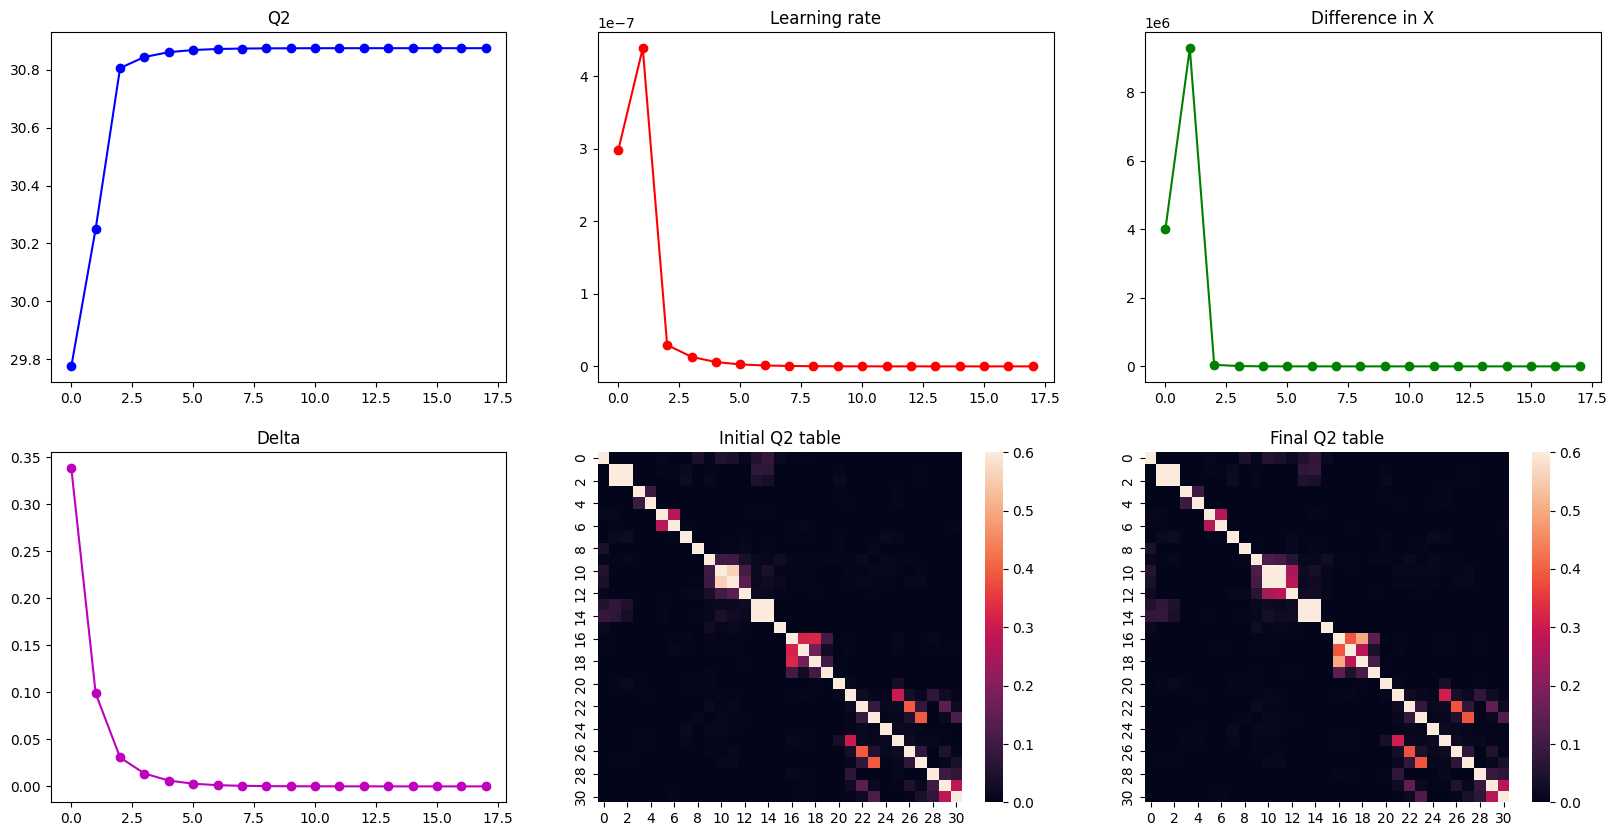

In [7]:
# Apply optimal scaling
X_before_scaling = X.copy()
X,cik = optimal_scaling(X,variable_types,verbose=True,vmax=0.6)

In [38]:
# saving the pre-processed data and encoding table
import pickle
np.save('data/infarction/'+dataset_name+'_X_processed.npy',X)
with open('data/infarction/'+dataset_name+'_cik.pkl', 'wb') as file:
    pickle.dump(cik, file)

FVE PC1 0.03767070932153583 FVE PC2 0.02880837632403253
FVE PC1 0.14722541672919123 FVE PC2 0.11258947033344943
[0.14722542 0.25981489 0.36519393 0.46059486 0.54788623 0.62820237
 0.69847125 0.76639124 0.83001273 0.88978513 0.94570304 1.        ]


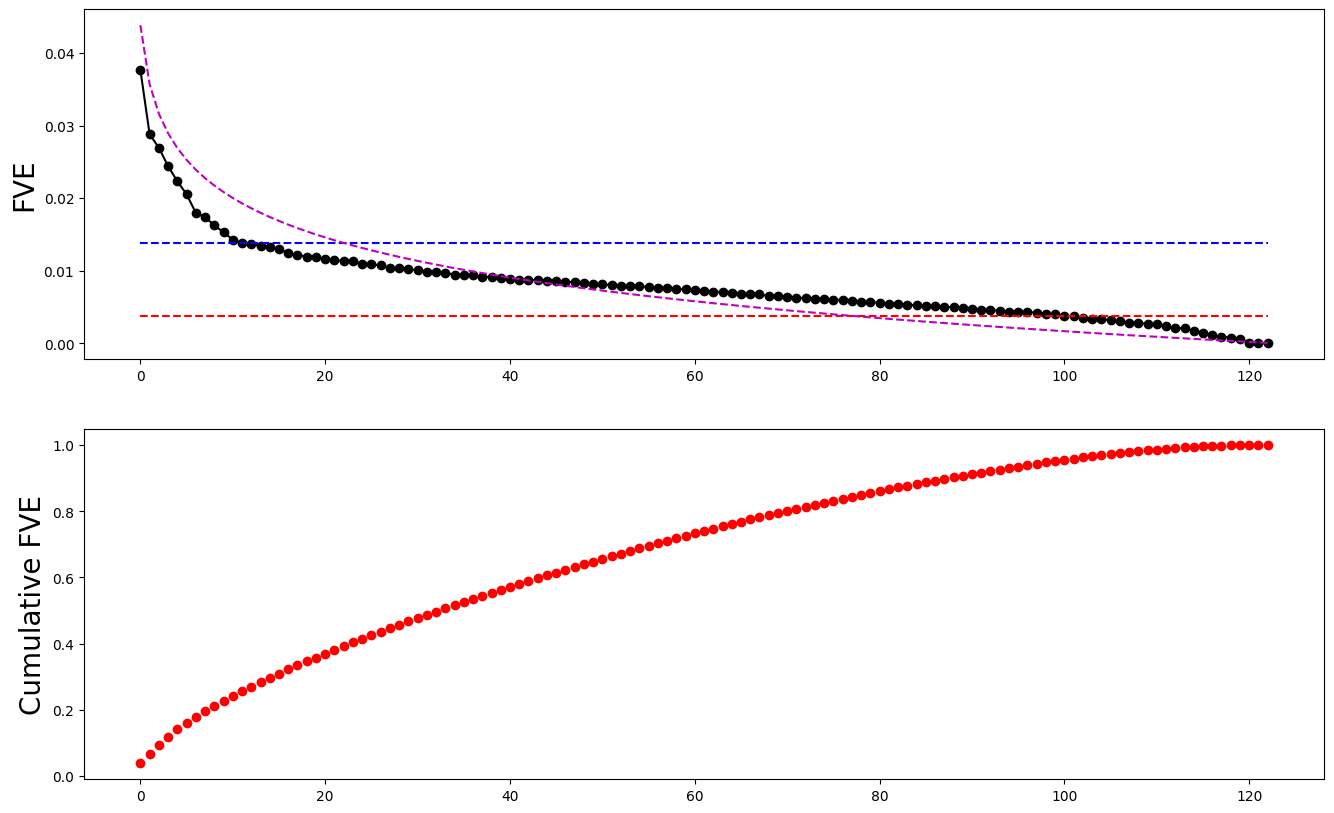

In [5]:
# reducing dimension via PCA
initial_dimension = 12

X = scipy.stats.zscore(X)

pca = PCA(n_components=X.shape[1],svd_solver='full')
Y = pca.fit_transform(X)
s = pca.explained_variance_ratio_
print('FVE PC1',s[0]/np.sum(s),'FVE PC2',s[1]/np.sum(s))
v = pca.components_.T
mean_val = np.mean(X,axis=0)

if 'X_before_scaling' in locals():
    X_before_scaling = scipy.stats.zscore(X_before_scaling)
    Ybs = pca.fit_transform(X_before_scaling)
    sbs = pca.explained_variance_ratio_
    vbs = pca.components_.T
    
fig = plt.figure(figsize=(16,10))
plt.subplot(211)
if 'X_before_scaling' in locals():
    plt.plot(sbs,'go-')
s = s/np.sum(s)
plt.plot(s,'ko-')
plt.plot([0,X.shape[1]-1],[s[0]/10,s[0]/10],'r--')
plt.plot([0,X.shape[1]-1],[s[initial_dimension-1],s[initial_dimension-1]],'b--')
plt.plot(brokenstick_distribution(len(s)),'m--')
plt.ylabel('FVE',fontsize=20)
plt.subplot(212)
plt.plot(np.cumsum(s),'ro')
plt.ylabel('Cumulative FVE',fontsize=20)

X = Y[:,0:initial_dimension]

# this is for applying ELMAP in MATLAB
ElMapFolder = '/mnt/c/MyPrograms/__github/ElMap'
if os.path.exists(ElMapFolder+'/tests/'):
    np.savetxt(ElMapFolder+'/tests/'+'_input.txt', X, delimiter="\t")
    
print('FVE PC1',s[0]/np.sum(s[0:initial_dimension]),'FVE PC2',s[1]/np.sum(s[0:initial_dimension]))
print(np.cumsum(s[0:initial_dimension]/np.sum(s[0:initial_dimension])))

# Definition of classes, depends on the nature of complications. Major class - black - corresponds to no complications case

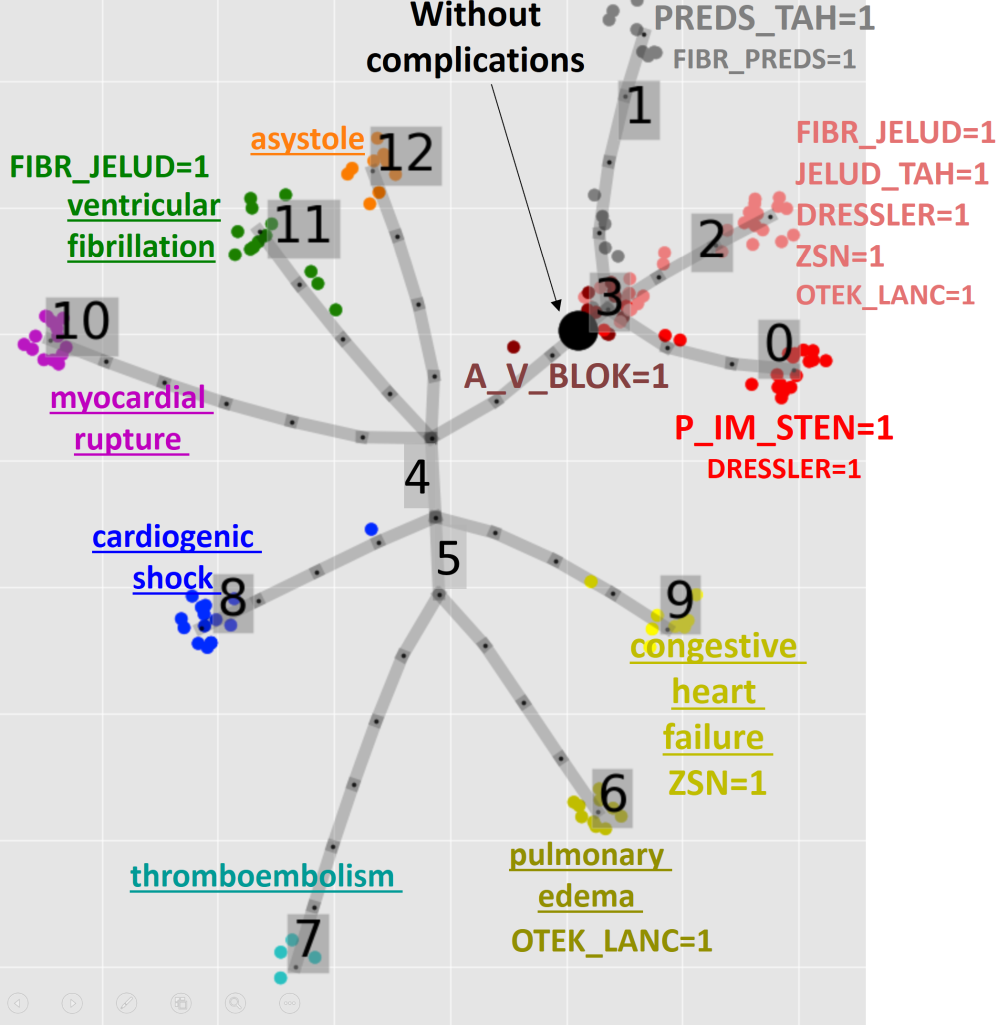

In [6]:
# Changing class colors for visualization

if True:
    clrs = []
    for c in color:
        if c==-1:
            clrs.append('k')
        if c==0:
            clrs.append('r')
        if c==1:
            clrs.append('tab:gray')
        if c==2:
            clrs.append('lightcoral')
        if c==3:
            clrs.append('darkred')
        if c==4: # this class number is absent
            clrs.append('k')
        if c==5:  # this class number is absent
            clrs.append('k')
        if c==6:
            clrs.append('y')
        if c==7:
            clrs.append('c')
        if c==8:
            clrs.append('b')
        if c==9:
            clrs.append('yellow')
        if c==10:
            clrs.append('m')
        if c==11:
            clrs.append('g')        
        if c==12:
            clrs.append('tab:orange')        
    color = clrs

if False:
    clrs = []
    for c in color:
        if c==-1:
            clrs.append('k')
        if c==1 or c==2 or c==3:
            clrs.append('r')
        if c>4:
            clrs.append('b')
    color = clrs

In [7]:
# Construct and post-process the principal tree

nnodes = 50

tree_elpi = elpigraph.computeElasticPrincipalTree(X,nnodes,alpha=0.01,Mu=0.1,Lambda=0.1,FinalEnergy='Penalized',verbose=True)
tree_elpi = tree_elpi[0]
# some additional pruning of the graph
prune_the_tree(tree_elpi)
# extend the leafs to reach the extreme data points
tree_extended = ExtendLeaves_modified(X, tree_elpi, Mode = "QuantDists", ControlPar = .5, DoSA = False)
# paritioning the data by tree branches
vec_labels_by_branches = partition_data_by_tree_branches(X,tree_extended)
print(len(set(vec_labels_by_branches)),'labels generated')
# paritioning the data by proximity to nodes
nodep = tree_elpi['NodePositions']
partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = nodep, MaxBlockSize = 100000000, TrimmingRadius = np.inf,SquaredX = np.sum(X**2,axis=1,keepdims=1))
partition_by_node = np.zeros(len(partition))
for i,p in enumerate(partition):
    partition_by_node[i] = p[0]

Generating the initial configuration
Creating a chain in the 1st PC with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
12 dimensions are being used
100.0 % of the original variance has been retained
Computing EPG with  50  nodes on  1574  points and  12  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	27.4666	4	3	2	0	0	0	26.1118	25.9744	0.1708	0.1752	1.1603	0.1945	0.7781	3.1125	0
0||5	26.8774	5	4	3	0	0	0	25.4366	25.3151	0.1923	0.1961	1.2518	0.189	0.9451	4.7253	0
1||6	26.1726	6	5	2	1	0	0	24.3777	24.2631	0.2259	0.2295	1.6487	0.1462	0.8771	5.2627	0
1||7	25.6989	7	6	3	1	0	0	23.8495	23.764	0.2427	0.2454	1.6985	0.1509	1.0565	7.3955	0
2||8	25.1643	8	7	2	2	0	0	23.1189	23.0427	0.2659	0.2683	1.9503	0.095	0.7603	6.0826	0
2||9	24.8228	9	8	3	2	0	0	22.7353	22.6528	0.2781	0.2807	1.9859	0.1016	0.9143	8.2287	0
3||10	24.5019	10	9	2	3	0	0	2

In [8]:
# Serialize the results if needed, for repeatitive use

import pickle as pkl
with open(dataset_name+'save_tree_extended.pickle', 'wb') as handle:
    pkl.dump(tree_extended, handle,protocol=pkl.HIGHEST_PROTOCOL)
with open(dataset_name+'save_X.pickle', 'wb') as handle:
    pkl.dump(X, handle,protocol=pkl.HIGHEST_PROTOCOL)
with open(dataset_name+'save_X_original.pickle', 'wb') as handle:
    pkl.dump(X_original, handle,protocol=pkl.HIGHEST_PROTOCOL)


/home/zinovyev/gits/ClinTrajan/code/clintraj_eltree.py:222: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x,y,c=color2,cmap=cmap,s=points_size, vmin=vmin, vmax=vmax,alpha=Transparency_Alpha_points)


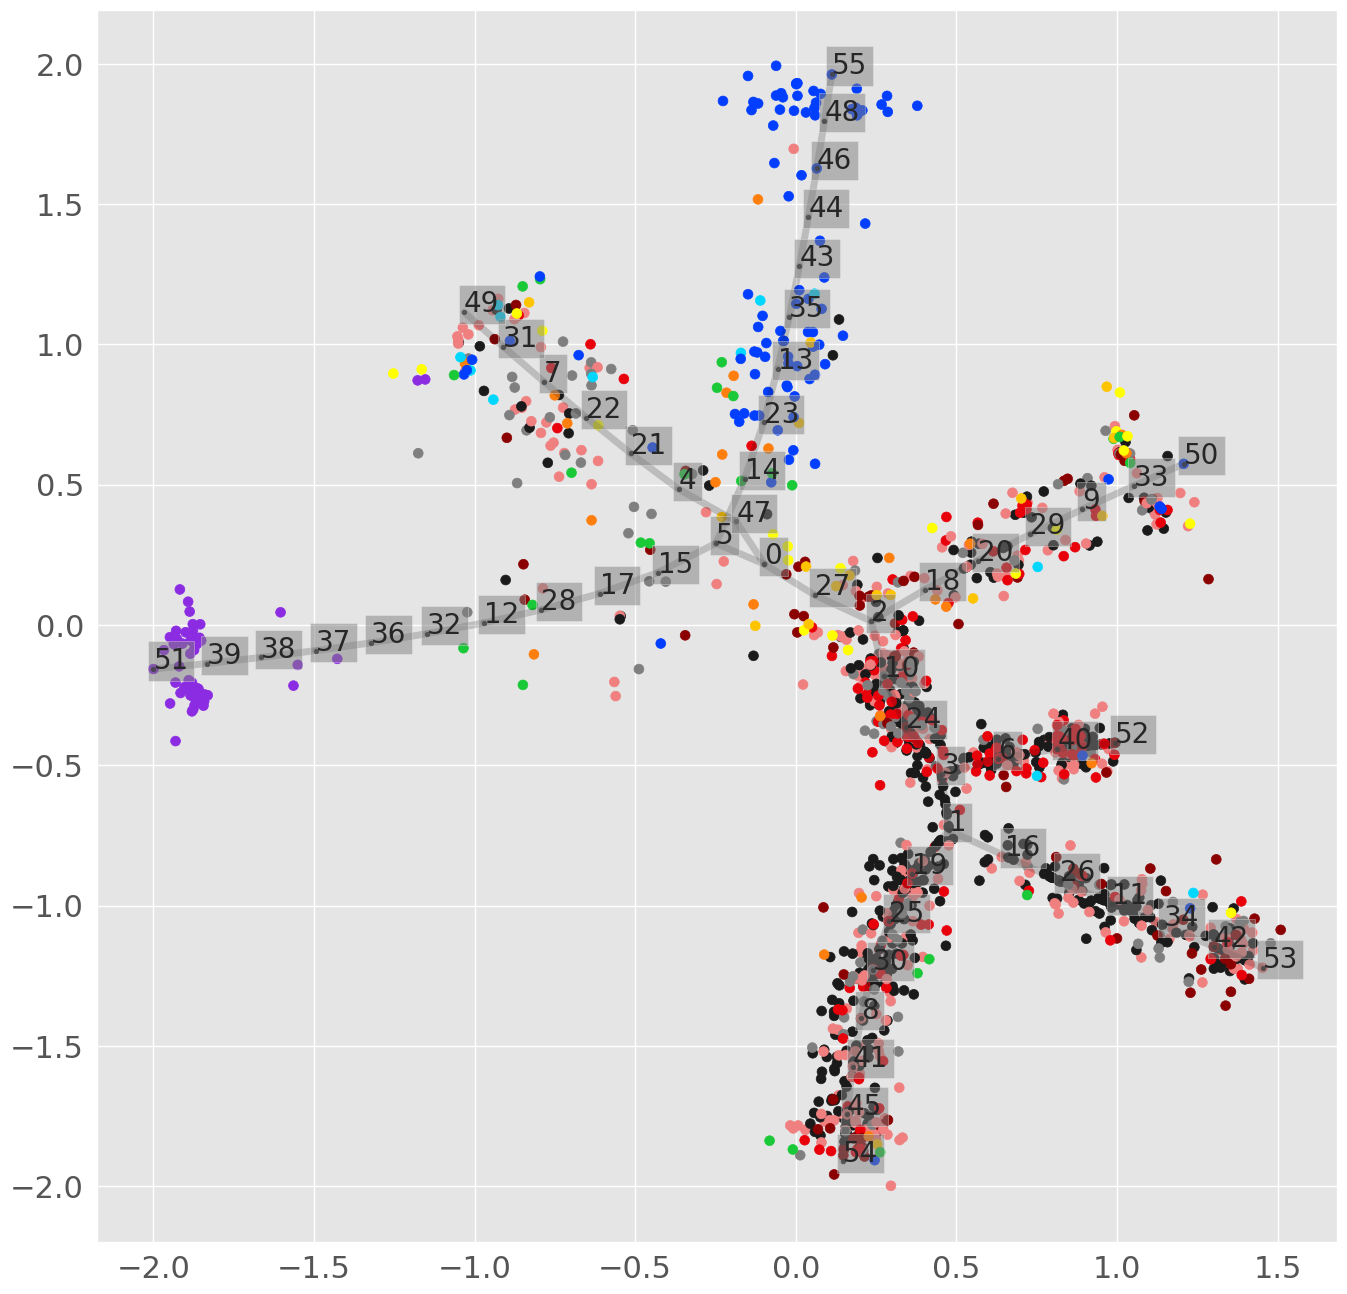

In [9]:
showEdgeNumbers=False
showNodeNumbers=True
showBranchNumbers=False
showPointNumbers=False
Color_by_feature = ''
Feature_Edge_Width = ''
Invert_Edge_Value = False
Min_Edge_Width = 5
Max_Edge_Width = 5
Big_Point_Size = 1000
Small_Point_Size = 100
Normal_Point_Size = 50
Visualize_Edge_Width_AsNodeCoordinates=True
Color_by_partitioning = False
Transparency_Alpha = 0.2
Visualize_Branch_Class_Associations = [] #list_of_branch_class_associations
cmap = 'hot'
highlight_subset = []
Color_by_partitioning=False
partitioning = vec_labels_by_branches
scatter_parameter = 0.03

sns.set(palette='bright',font_scale=2)

#feature = 'LET_IS_0'
feature = ''
fig = plt.figure(figsize=(16, 16))
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,principal_component_vectors=v,mean_vector=mean_val,Color_by_feature=feature, Feature_Edge_Width=feature,Invert_Edge_Value=Invert_Edge_Value,Min_Edge_Width=Min_Edge_Width,Max_Edge_Width=Max_Edge_Width,Visualize_Edge_Width_AsNodeCoordinates=Visualize_Edge_Width_AsNodeCoordinates, Color_by_partitioning=Color_by_partitioning, visualize_partition=partitioning, showBranchNumbers=showBranchNumbers,showEdgeNumbers=showEdgeNumbers,showNodeNumbers=showNodeNumbers,scatter_parameter=scatter_parameter,cmap=cmap,Normal_Point_Size=Normal_Point_Size,highlight_subset=highlight_subset,Big_Point_Size=Big_Point_Size,showPointNumbers=showPointNumbers,Visualize_Branch_Class_Associations=Visualize_Branch_Class_Associations)
plt.savefig('principal_tree.png', format='png', dpi=300)

In [10]:
# Associate nodes (vec_labels_by_branches) and classes (color)
# The aim is to identify the root_node (the node most enriched with 'k' class - which means no complications)

Negative_Enrichment = False
Threshold_Deviation = 0.2
Minimal_number_of_points = 20
partitioning = partition_by_node

list_of_node_class_associations,p,stat = associate_with_categorical_var(partitioning,'CLASS',color,'CATEGORICAL',
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points)
    
print(list_of_node_class_associations)

k_nodes_scores = [(asst[0],asst[2]) for asst in list_of_node_class_associations if asst[1]=='k']
max_score_node = int(k_nodes_scores[np.argmax([t[1] for t in k_nodes_scores])][0])

root_node = max_score_node

print('Suggested root_node=',root_node)
root_node = 8
print('Selected root_node=',root_node)

[(3.0, 'k', 0.25044687189672293), (6.0, 'k', 0.2285220493951051), (11.0, 'k', 0.26324237560192615), (19.0, 'k', 0.26979192286880804), (26.0, 'k', 0.2221726939391761), (30.0, 'k', 0.2078865036107121), (39.0, 'm', 0.9348494161032577), (40.0, 'r', 0.3951839267247747), (42.0, 'lightcoral', 0.20724326785949693), (45.0, 'lightcoral', 0.20141207900009536), (48.0, 'b', 0.8816497310221159)]
Suggested root_node= 19
Selected root_node= 8


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


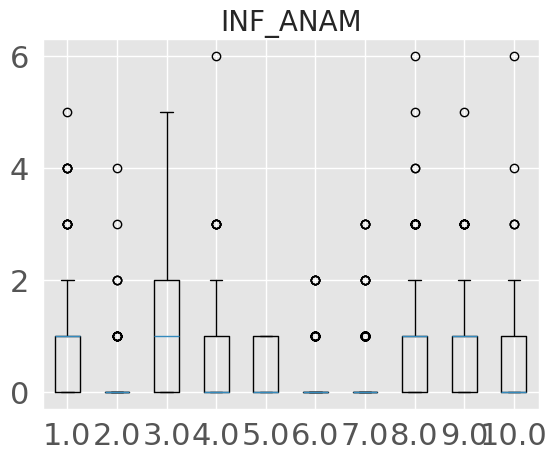

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:

INF_ANAM ORDINAL [(1.0, 'CONTINUOUS', 0.5625801799777831)] p-value= 7.104636006857351e-44


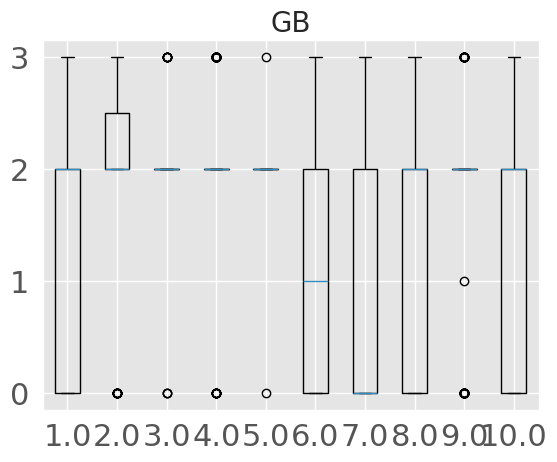

GB ORDINAL [(3.0, 'CONTINUOUS', 0.5551881521880088), (4.0, 'CONTINUOUS', 0.6029040009652251)] p-value= 2.176485620702694e-53


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


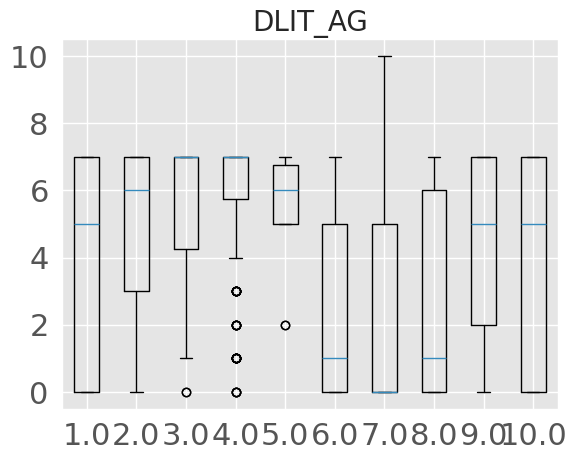

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


DLIT_AG ORDINAL [(4.0, 'CONTINUOUS', 0.5820643473027413)] p-value= 8.494083834669535e-69


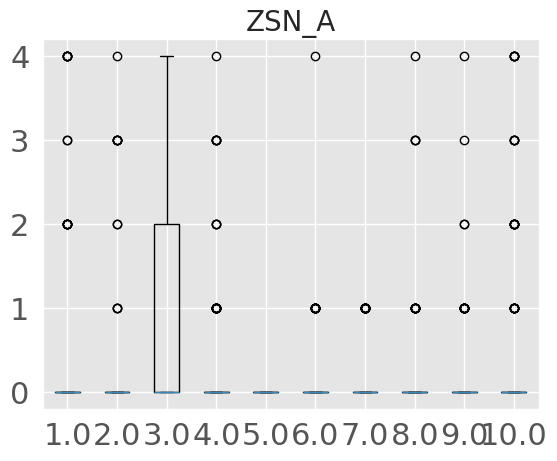

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


ZSN_A ORDINAL [(3.0, 'CONTINUOUS', 0.9009681326370365)] p-value= 1.062329321819101e-24


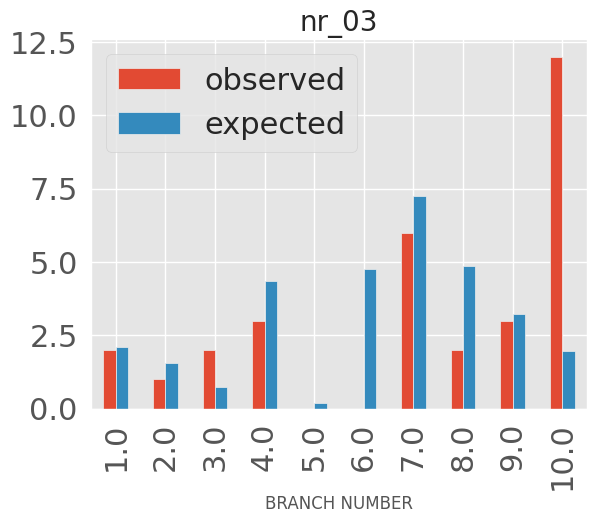

nr_03 BINARY [(10.0, 1.0, 0.7180280152810623)] p-value= 5.825381907129581e-10


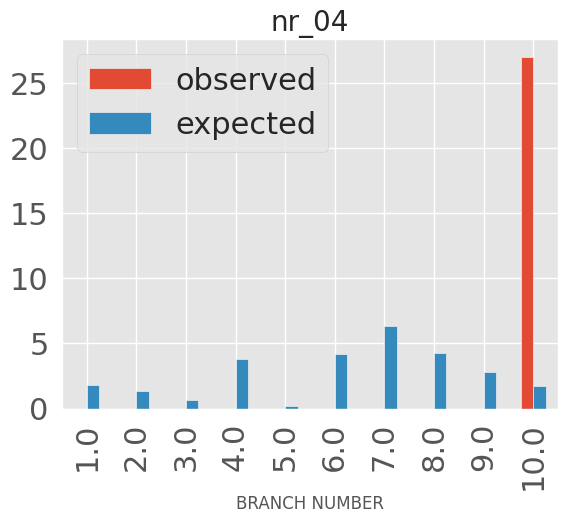

nr_04 BINARY [(10.0, 1.0, 0.8805256869772999)] p-value= 1.217692155291527e-81


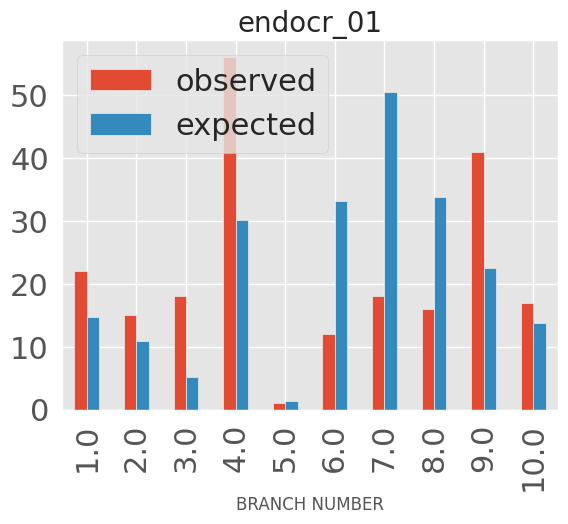

endocr_01 BINARY [(3.0, 1.0, 0.5507389162561576)] p-value= 3.564086808629435e-25


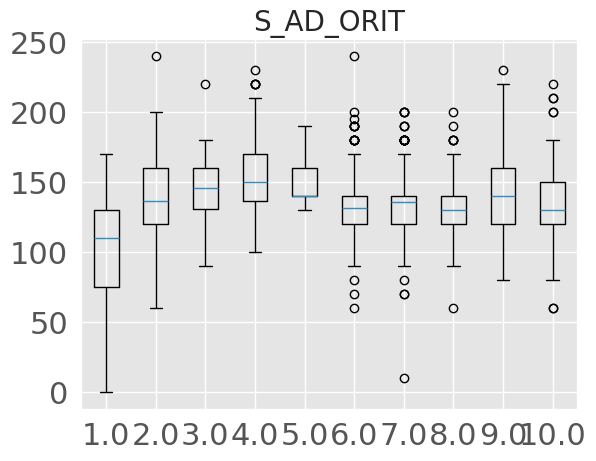

S_AD_ORIT CONTINUOUS [(2.0, 'CONTINUOUS', 1.284688536189038), (3.0, 'CONTINUOUS', 1.7237708965804395), (4.0, 'CONTINUOUS', 1.954282291257662), (5.0, 'CONTINUOUS', 1.8885691882430105), (6.0, 'CONTINUOUS', 1.2954176846516696), (7.0, 'CONTINUOUS', 1.3178242358638919), (8.0, 'CONTINUOUS', 1.1657485670638752), (9.0, 'CONTINUOUS', 1.5277881392552635), (10.0, 'CONTINUOUS', 1.3062273991468605)] p-value= 2.376198651069929e-65


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


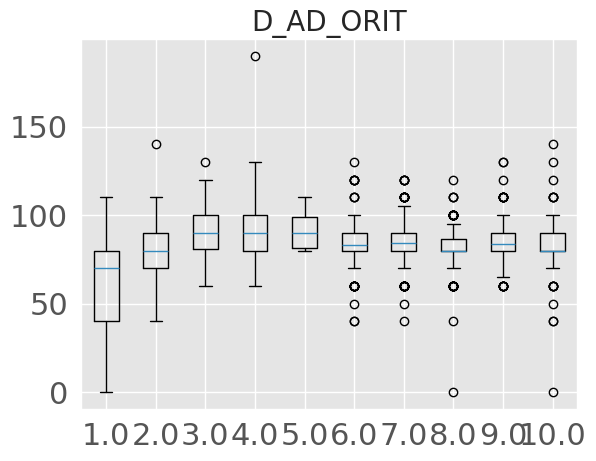

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


D_AD_ORIT CONTINUOUS [(2.0, 'CONTINUOUS', 1.2080965035129294), (3.0, 'CONTINUOUS', 1.858321770137), (4.0, 'CONTINUOUS', 1.8651960844213318), (5.0, 'CONTINUOUS', 1.8811027208497386), (6.0, 'CONTINUOUS', 1.4379925729422045), (7.0, 'CONTINUOUS', 1.4908035463423739), (8.0, 'CONTINUOUS', 1.2798347795506646), (9.0, 'CONTINUOUS', 1.5796559110134967), (10.0, 'CONTINUOUS', 1.4566041871368745)] p-value= 1.380863503962955e-61


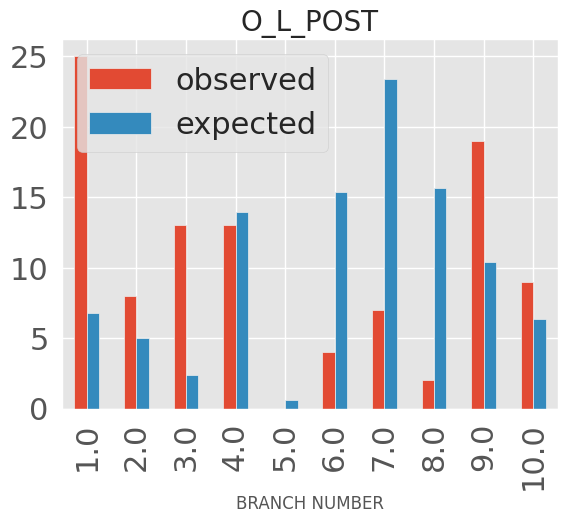

O_L_POST BINARY [(1.0, 1.0, 0.5724275724275724), (3.0, 1.0, 0.6867529469953013)] p-value= 3.8558824469881374e-27


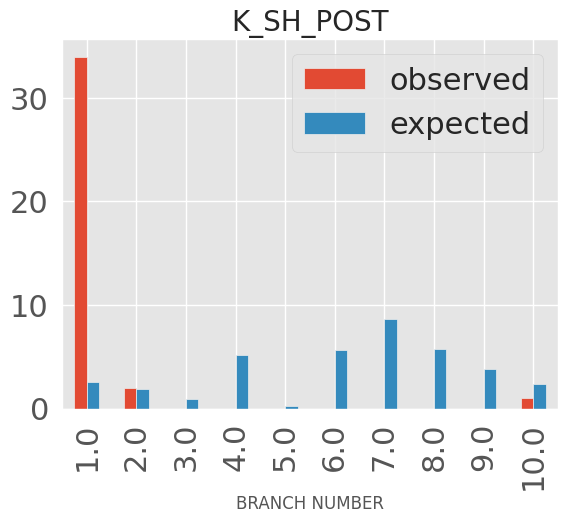

K_SH_POST BINARY [(1.0, 1.0, 0.862235754675946)] p-value= 3.7628252162688535e-88


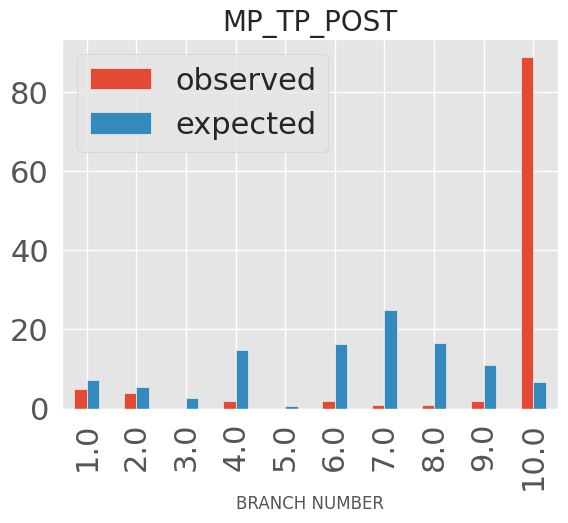

MP_TP_POST BINARY [(10.0, 1.0, 0.8593100885284631)] p-value= 4.982847646241263e-243


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:

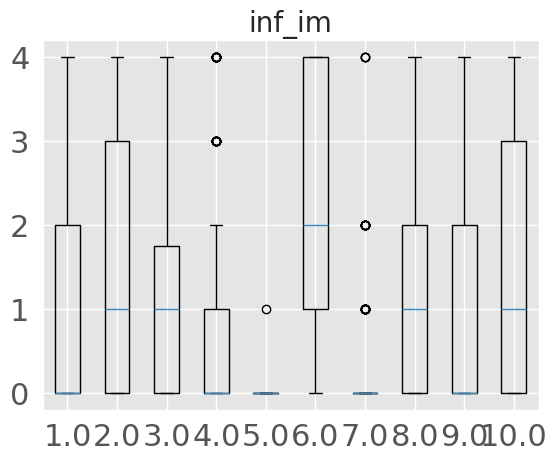

inf_im ORDINAL [(6.0, 'CONTINUOUS', 0.9985776759705799)] p-value= 4.898463692896984e-103


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


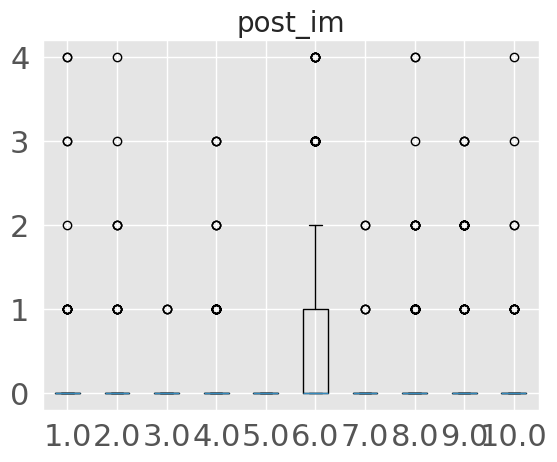

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


post_im ORDINAL [(6.0, 'CONTINUOUS', 0.8552437911003585)] p-value= 3.781056458089262e-45


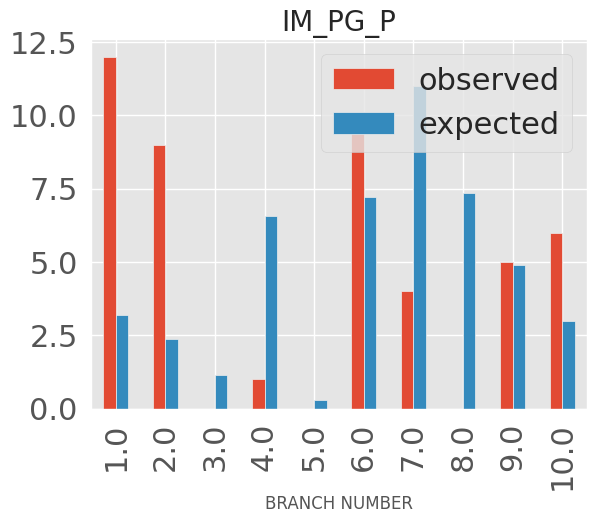

IM_PG_P BINARY [(1.0, 1.0, 0.579462307145545)] p-value= 5.838894383222459e-11


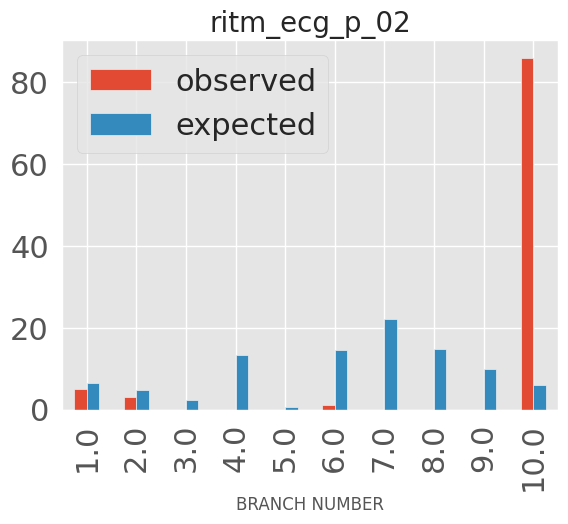

ritm_ecg_p_02 BINARY [(10.0, 1.0, 0.8688425005522422)] p-value= 1.2454439974367223e-254


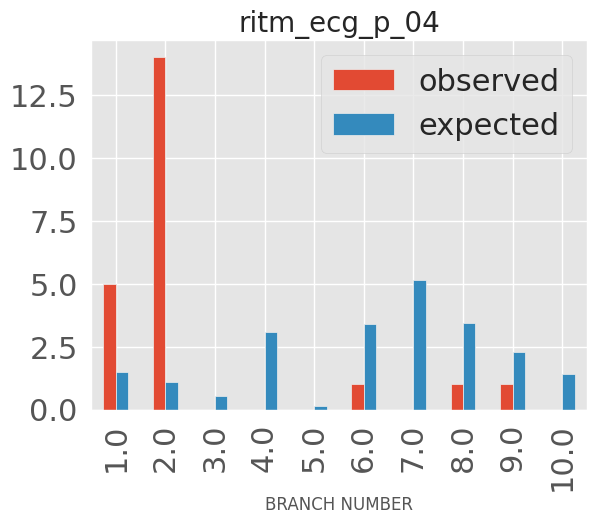

ritm_ecg_p_04 BINARY [(2.0, 1.0, 0.8537898544628586)] p-value= 4.000803743237672e-33


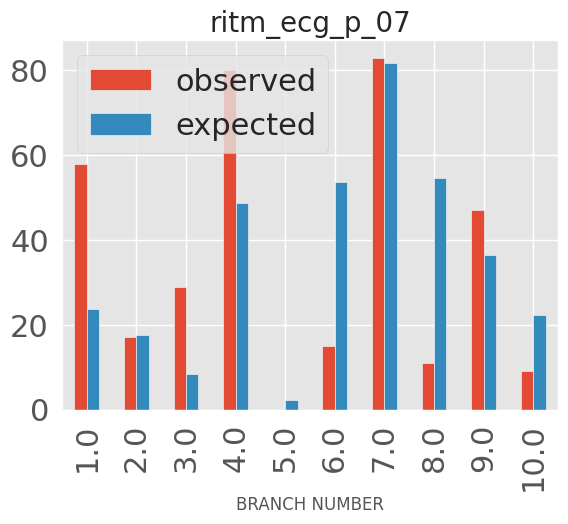

ritm_ecg_p_07 BINARY [(3.0, 1.0, 0.5497385754057175)] p-value= 5.414473784178656e-49


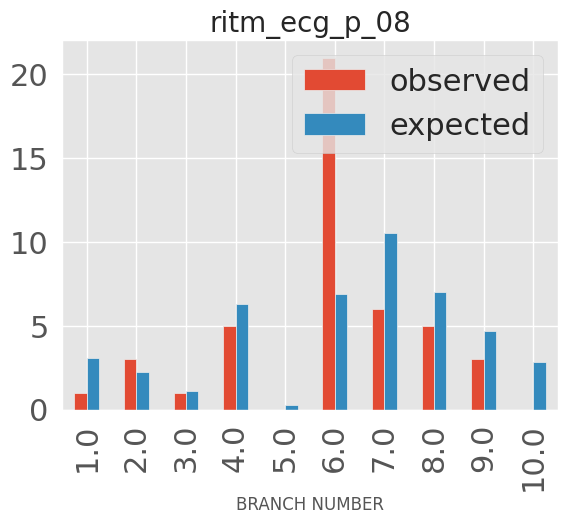

ritm_ecg_p_08 BINARY [(6.0, 1.0, 0.5043691971600218)] p-value= 1.796003984933699e-05


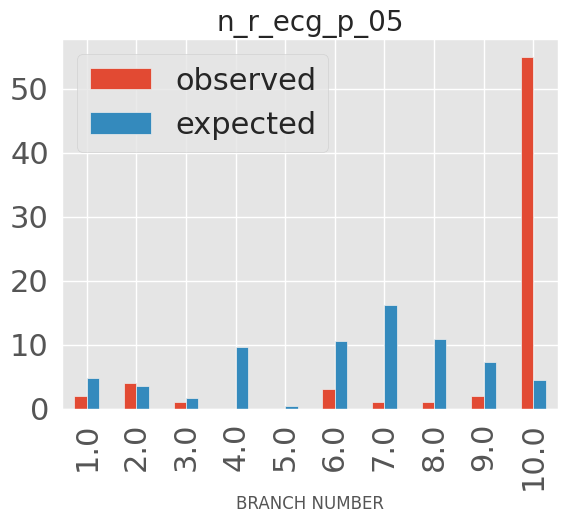

n_r_ecg_p_05 BINARY [(10.0, 1.0, 0.8523590456831068)] p-value= 9.381498893828991e-136


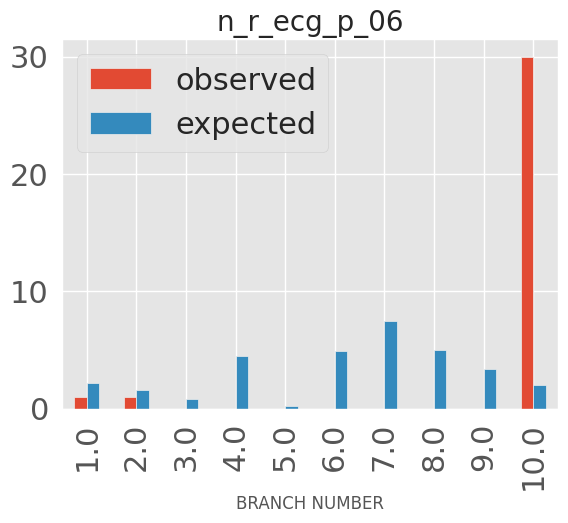

n_r_ecg_p_06 BINARY [(10.0, 1.0, 0.8730662435541452)] p-value= 6.313682891998833e-85


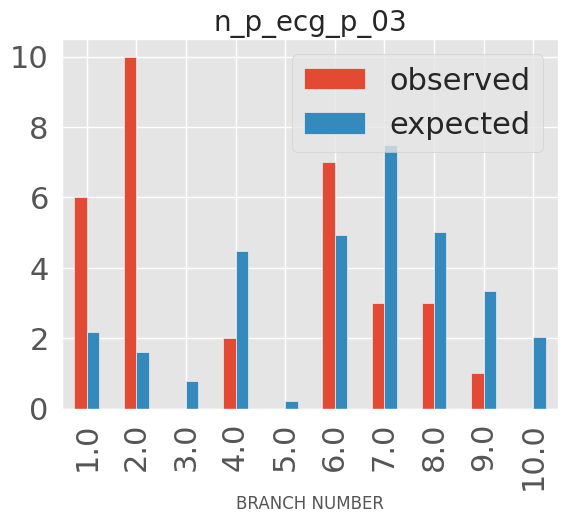

n_p_ecg_p_03 BINARY [(2.0, 1.0, 0.7232318808846071)] p-value= 4.966491388790128e-10


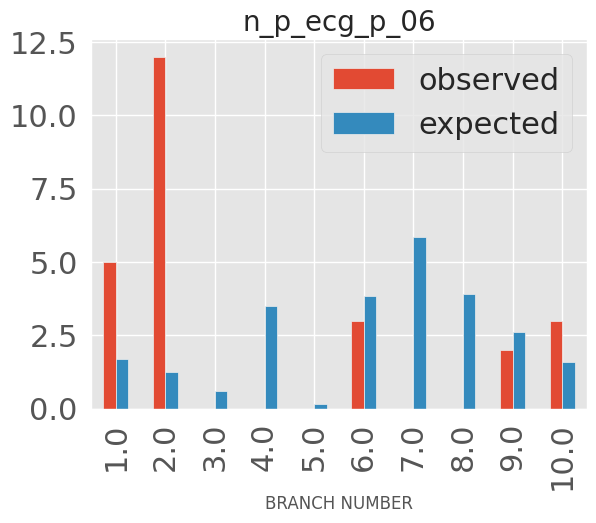

n_p_ecg_p_06 BINARY [(2.0, 1.0, 0.8106696064803719)] p-value= 9.400074086267367e-21


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:

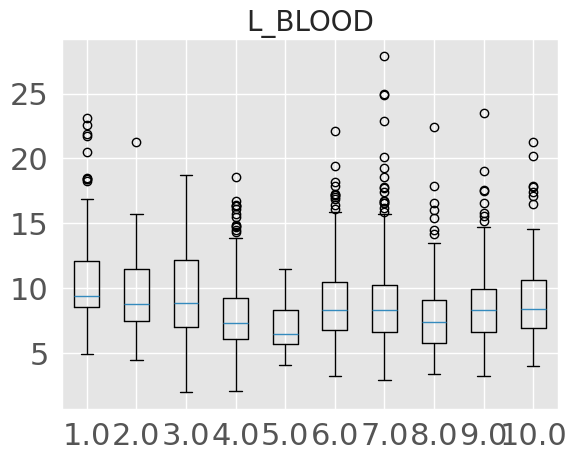

L_BLOOD CONTINUOUS [(1.0, 'CONTINUOUS', 0.5925089240329992)] p-value= 1.0675261792230727e-13


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


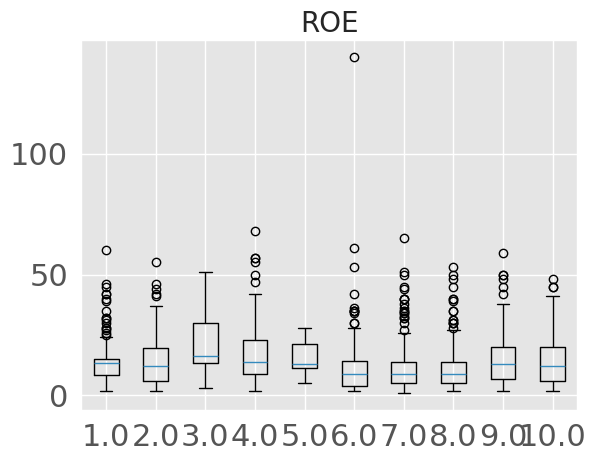

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


ROE CONTINUOUS [(3.0, 'CONTINUOUS', 0.5513009747327868)] p-value= 1.118976412135766e-14


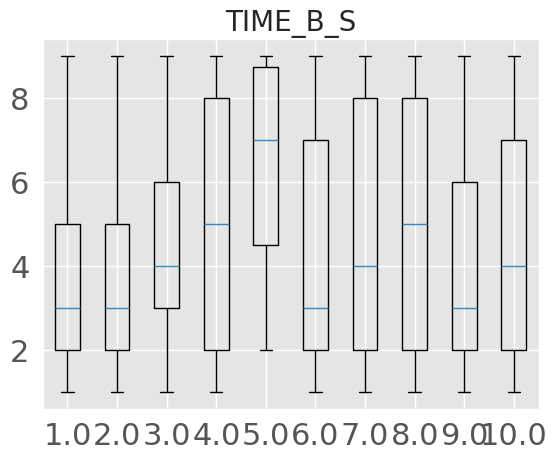

TIME_B_S ORDINAL [(4.0, 'CONTINUOUS', 0.6246198137796233), (5.0, 'CONTINUOUS', 1.0661266257803377), (7.0, 'CONTINUOUS', 0.5231834459821952), (8.0, 'CONTINUOUS', 0.6189298133118029)] p-value= 4.921203437062886e-09


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:

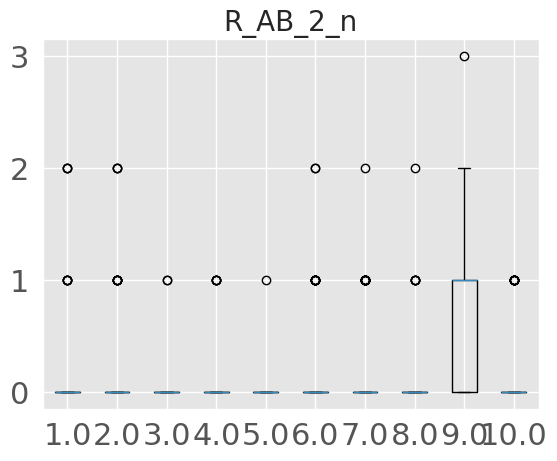

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


R_AB_2_n ORDINAL [(9.0, 'CONTINUOUS', 1.566061443604366)] p-value= 2.3278508751197156e-99


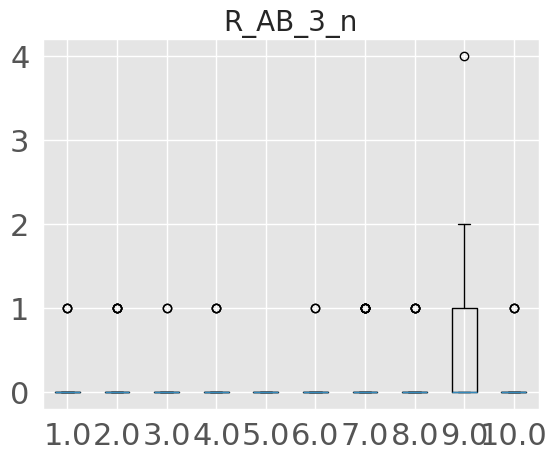

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


R_AB_3_n ORDINAL [(9.0, 'CONTINUOUS', 1.5145741950412774)] p-value= 4.39737046139604e-79


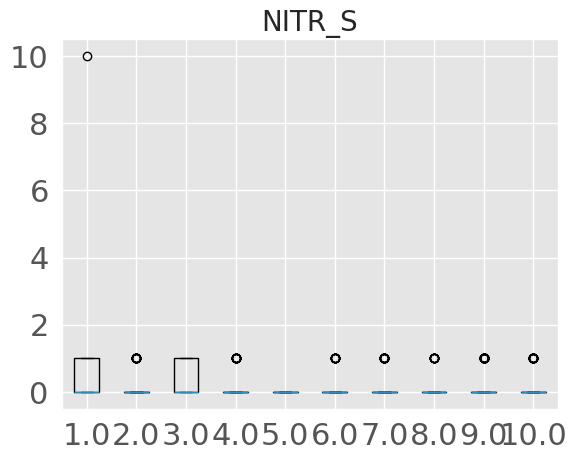

NITR_S ORDINAL [(1.0, 'CONTINUOUS', 0.7554436504813684)] p-value= 8.738412225742233e-25


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:

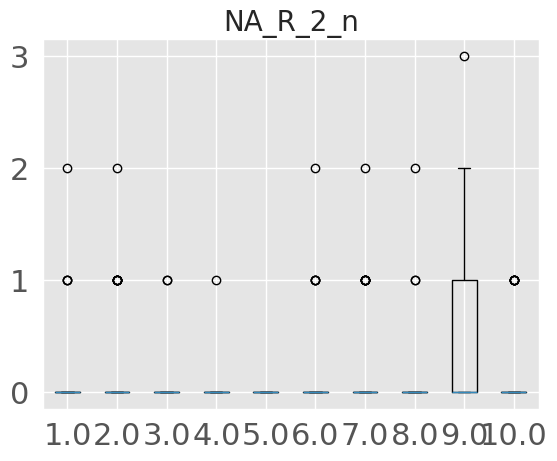

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


NA_R_2_n ORDINAL [(9.0, 'CONTINUOUS', 1.5488173191821655)] p-value= 4.27190089397694e-88


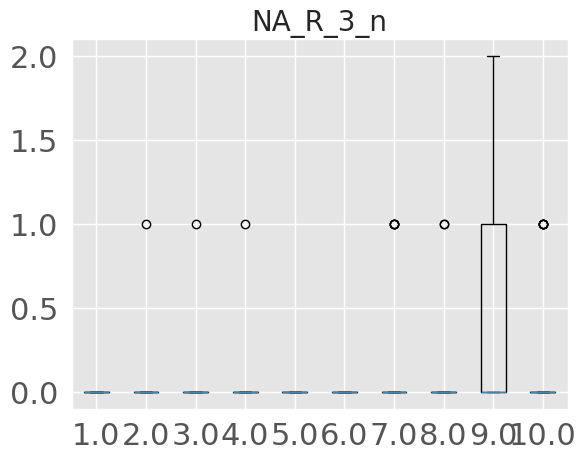

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


NA_R_3_n ORDINAL [(9.0, 'CONTINUOUS', 1.59834283817981)] p-value= 2.9647818900945055e-82


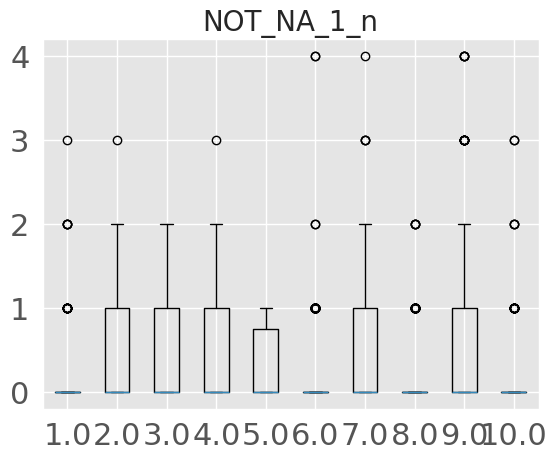

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


NOT_NA_1_n ORDINAL [(9.0, 'CONTINUOUS', 0.7432830789815161)] p-value= 6.513744883401387e-13


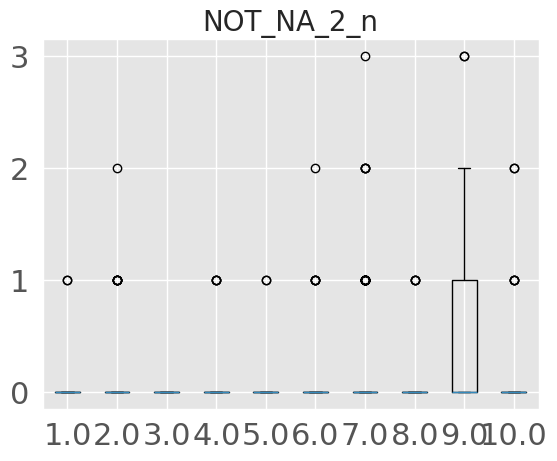

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


NOT_NA_2_n ORDINAL [(9.0, 'CONTINUOUS', 1.5153885315423692)] p-value= 1.9516695215474965e-70


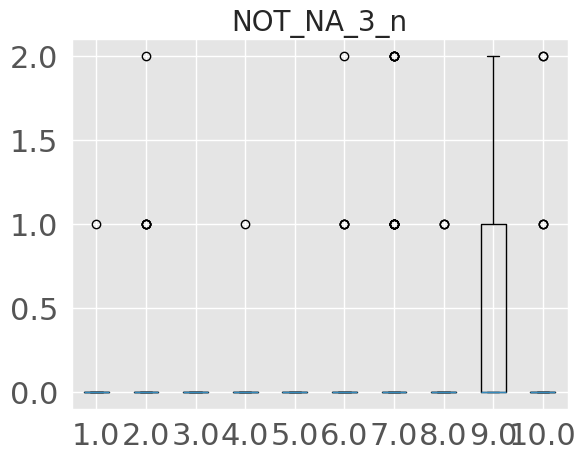

/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stat = aov_table.F[0]
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p = aov_table['PR(>F)'][0]


NOT_NA_3_n ORDINAL [(9.0, 'CONTINUOUS', 1.3960435362370291)] p-value= 1.2616660873796933e-57


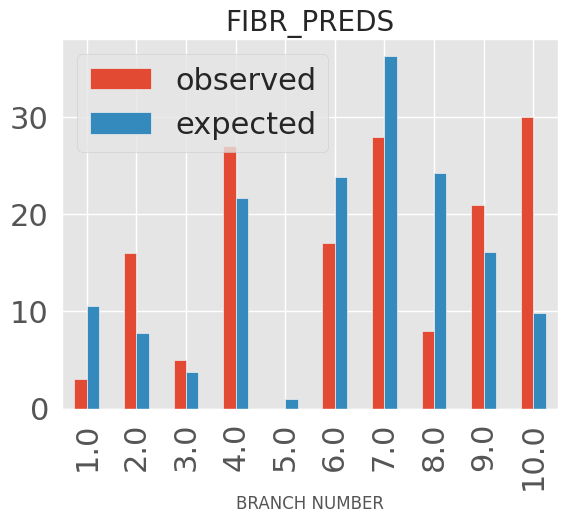

FIBR_PREDS BINARY [(10.0, 1.0, 0.5057397959183673)] p-value= 5.63931326456324e-14


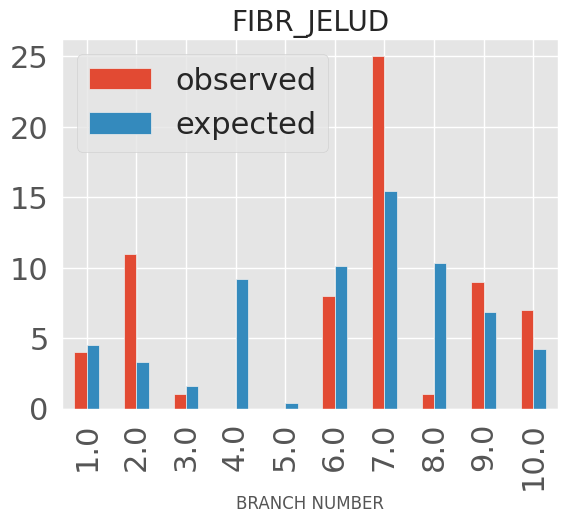

FIBR_JELUD BINARY [(2.0, 1.0, 0.537109375)] p-value= 3.8137531182881674e-07


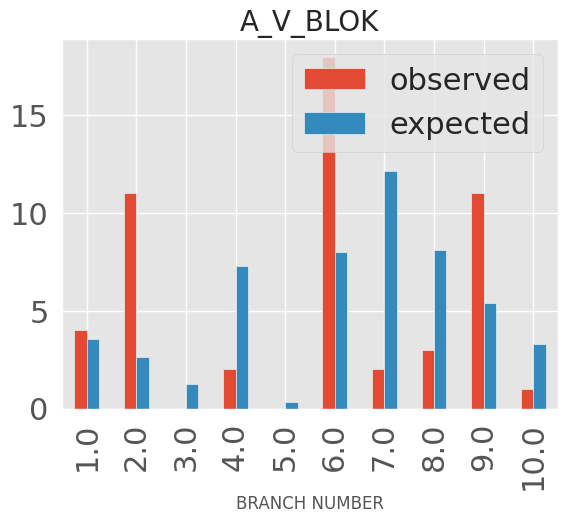

A_V_BLOK BINARY [(2.0, 1.0, 0.6164690505088226)] p-value= 8.33469255860842e-11


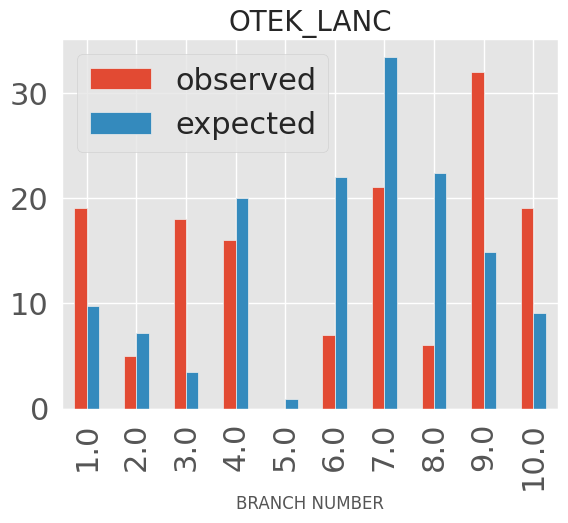

OTEK_LANC BINARY [(3.0, 1.0, 0.678137771723035)] p-value= 2.808497516021177e-26


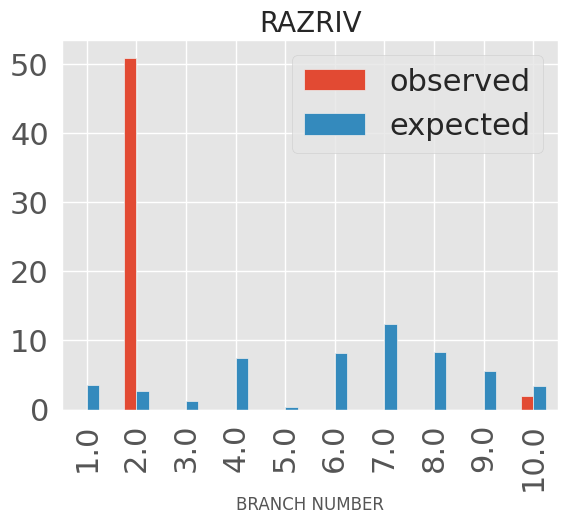

RAZRIV BINARY [(2.0, 1.0, 0.9008536484294527)] p-value= 1.740922162603803e-200


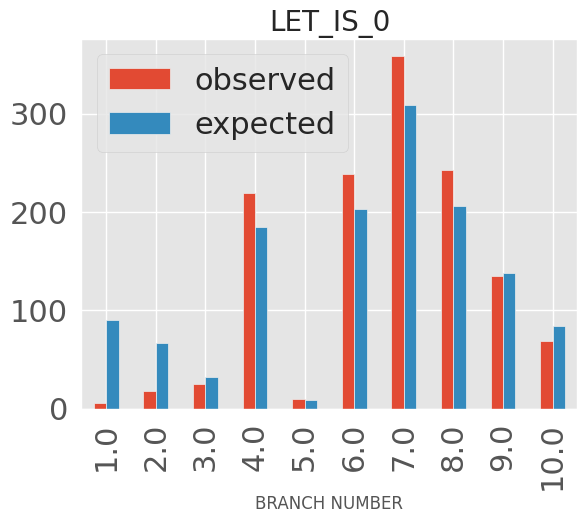

LET_IS_0 BINARY [(1.0, 0.0, 0.7089843854981321), (2.0, 0.0, 0.6553995224179101)] p-value= 8.148175890240235e-188


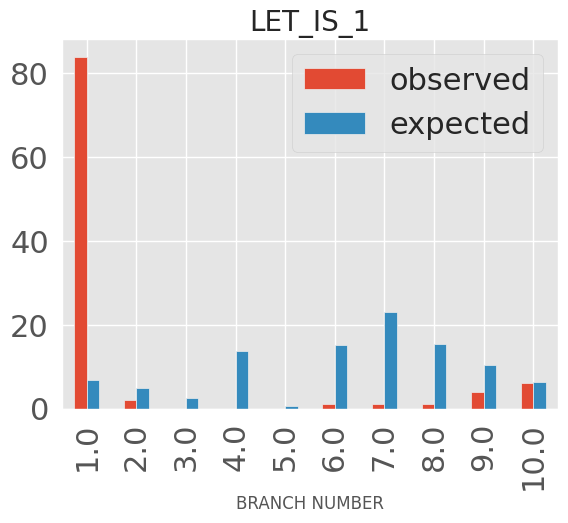

LET_IS_1 BINARY [(1.0, 1.0, 0.8516480053778123)] p-value= 3.146808097687476e-214


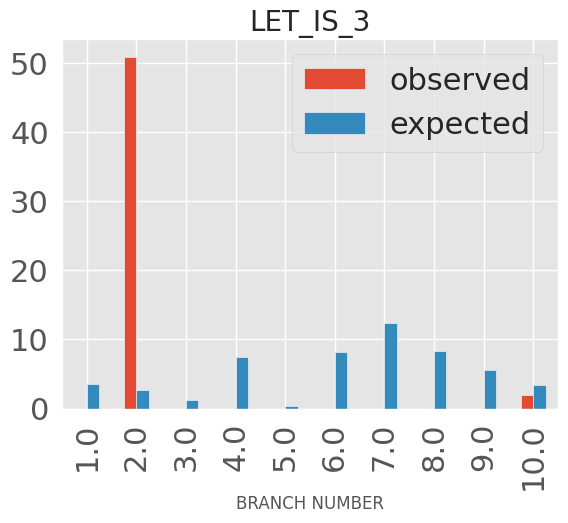

LET_IS_3 BINARY [(2.0, 1.0, 0.9008536484294527)] p-value= 1.740922162603803e-200


In [11]:
# Associate branches (vec_labels_by_branches) and variables (chi-square : binary, ordinal and categorical
# and ANOVA for continuous)

reload(clintraj_util)
from clintraj_util import associate_with_categorical_var


Negative_Enrichment = False
Threshold_Deviation = 0.5
Threshold_Parameter = 0.5
Minimal_number_of_points = 10
pvalue_threshold_parameter = 0.01
produce_plots = True

all_branch_var_associations = {}

for k,var in enumerate(variable_names):
    var_type = variable_types[k]
    vals = X_original[:,k]
    list_of_branch_var_associations=[]
    if var_type=='BINARY' or var_type=='CATEGORICAL':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Deviation,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if var_type=='ORDINAL' or var_type=='CONTINUOUS':
        list_of_branch_var_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,var,vals,var_type,
                                                            score_threshold=Threshold_Parameter,
                                                            verbose=False,
                                                            Negative_Enrichment=Negative_Enrichment,
                                                            Minimal_number_of_points=Minimal_number_of_points,
                                                            pvalue_threshold_parameter=pvalue_threshold_parameter,
                                                            produce_plot=produce_plots)
    if len(list_of_branch_var_associations)>0:
        print(var,var_type,list_of_branch_var_associations,'p-value=',p)
        all_branch_var_associations[var] = list_of_branch_var_associations

['LET_IS_1', 'IM_PG_P', 'O_L_POST', 'K_SH_POST', 'LET_IS_0', 'RAZRIV', 'LET_IS_3', 'ritm_ecg_p_02', 'nr_03', 'nr_04', 'FIBR_PREDS', 'n_r_ecg_p_06', 'MP_TP_POST', 'n_r_ecg_p_05', 'ZSN_A', 'NITR_S', 'NA_R_1_n', 'L_BLOOD', 'DLIT_AG', 'GB', 'INF_ANAM', 'FK_STENOK', 'NOT_NA_3_n', 'R_AB_3_n', 'NA_R_3_n', 'NOT_NA_2_n', 'R_AB_2_n', 'NA_R_2_n', 'ritm_ecg_p_04', 'n_p_ecg_p_06', 'ant_im', 'inf_im', 'post_im']



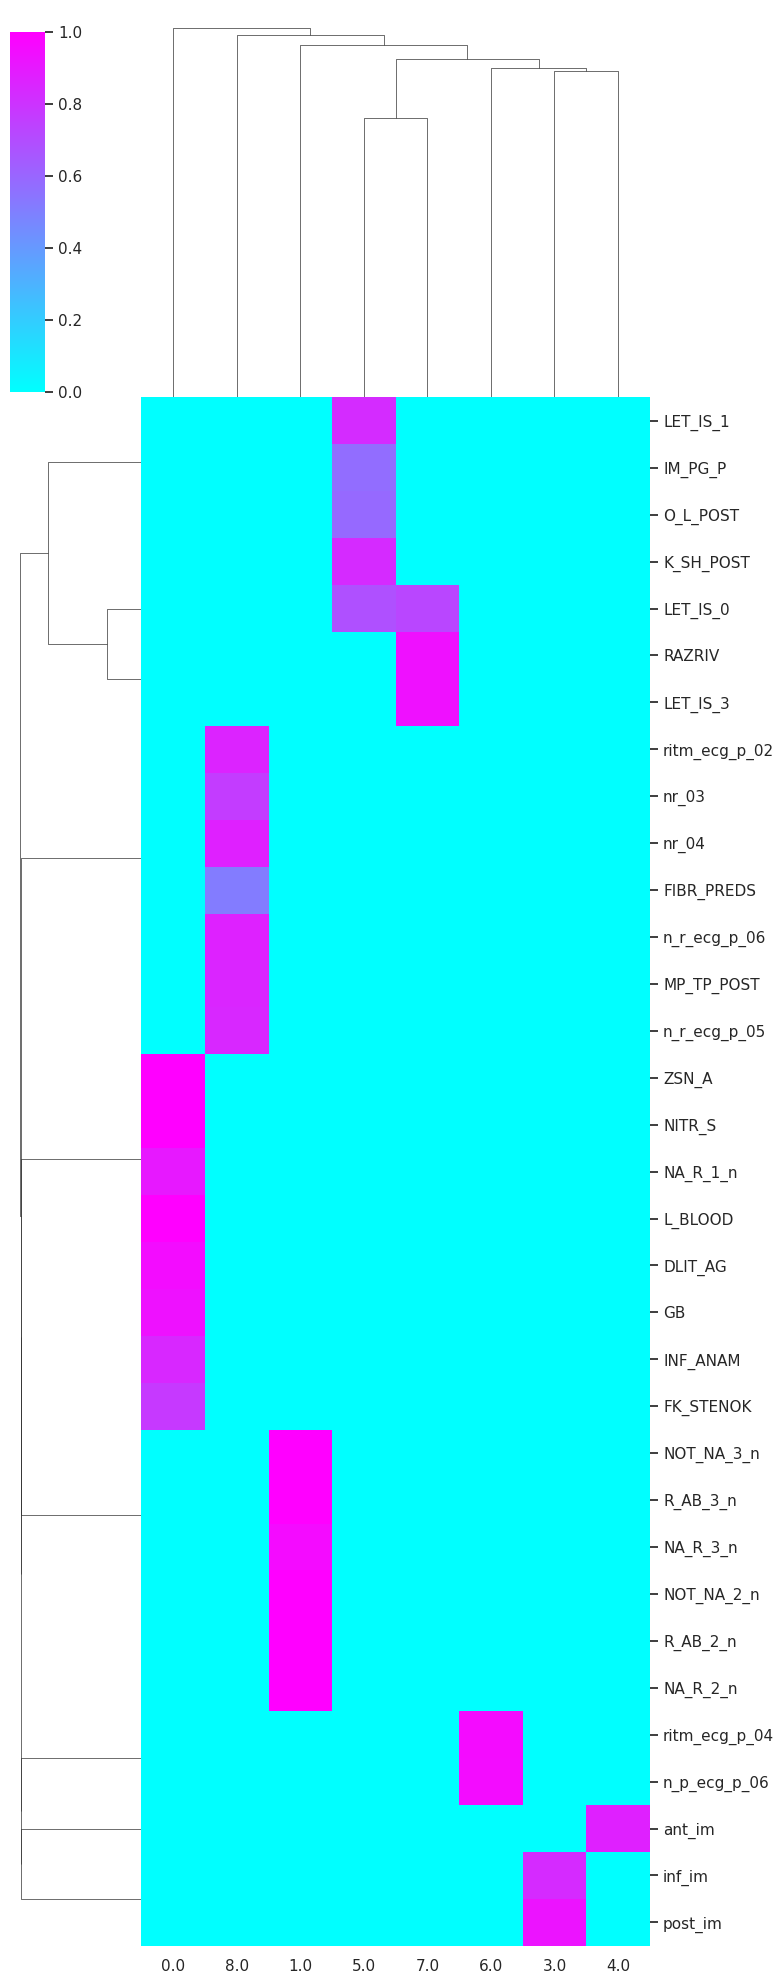

In [19]:
# Visualize associations between variables and tree branches

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_branch_var_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20),vmax=1,cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.savefig('assoc_branches.png', format='png', dpi=300)
print()

In [12]:
reload(clintraj_eltree)
from clintraj_eltree import convert_elpigraph_to_igraph, extract_trajectories, quantify_pseudotime

# Quantify pseudo-time

all_trajectories,all_trajectories_edges = extract_trajectories(tree_extended,root_node)
print(len(all_trajectories),' trajectories found.')
ProjStruct = project_on_tree(X,tree_extended)
PseudoTimeTraj = quantify_pseudotime(all_trajectories,all_trajectories_edges,ProjStruct)
# add information about bifurcation points
g = convert_elpigraph_to_igraph(tree_extended)
degs = g.degree()
for pss in PseudoTimeTraj:
    traj = pss['Trajectory']
    branching_marks = []
    for i,n in enumerate(traj):
        if degs[n]>2 and i>0:
            branching_marks.append(i)
    pss['BranchingPoints'] = branching_marks
    #print(n,branching_marks)

7  trajectories found.


/home/zinovyev/gits/ClinTrajan/code/clintraj_eltree.py:222: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x,y,c=color2,cmap=cmap,s=points_size, vmin=vmin, vmax=vmax,alpha=Transparency_Alpha_points)
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/zinovyev/gits/ClinTrajan/code/clintraj_eltree.py:222: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x,y,c=color2,cmap=cmap,s=points_size, vmin=vmin, vmax=vmax,alpha=Transparency_Alpha_points)
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504:

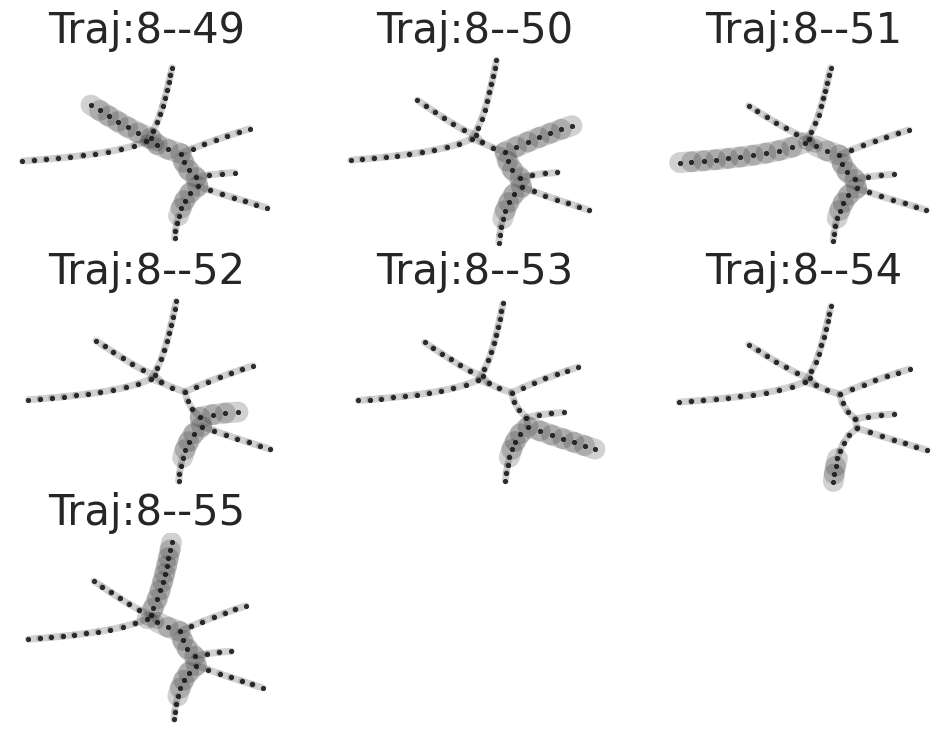

In [13]:
# Visualize all trajectories
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

n_subplots_x, n_subplots_y = 4, 3
plt.style.use('ggplot')
fig = plt.figure(figsize=(12, 12))

for i,pstt in enumerate(PseudoTimeTraj):
    points = list(pstt['Points'])
    X_fake = np.zeros((X.shape[0],1))
    X_fake[points,0] = 1.0
    TrajName = 'Traj:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    ax = fig.add_subplot(n_subplots_x,n_subplots_y,i+1)
    plt.title(TrajName,fontsize=30)
    visualize_eltree_with_data(tree_extended,X,X_fake,color,['Traj'],
                          principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=5,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)
    plt.axis('off')
    plt.savefig('trajectories.png', format='png', dpi=300)



/home/zinovyev/gits/ClinTrajan/code/clintraj_eltree.py:222: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x,y,c=color2,cmap=cmap,s=points_size, vmin=vmin, vmax=vmax,alpha=Transparency_Alpha_points)
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


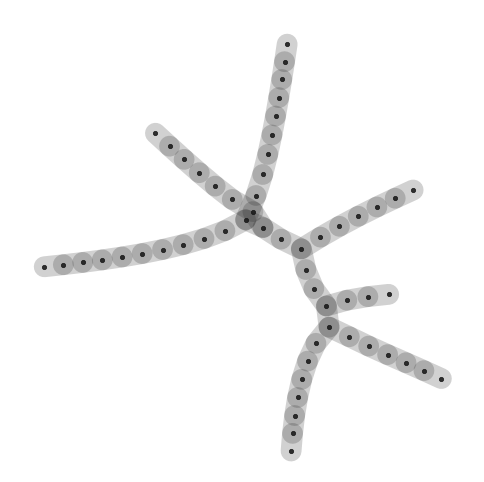

In [14]:
# produce principal tree scaffold image

fig = plt.figure(figsize=(6, 6))
visualize_eltree_with_data(tree_extended,X,X_fake,color,['Traj'],
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=15,Max_Edge_Width=15,Normal_Point_Size = 0,
                          Color_by_feature='', Feature_Edge_Width='Traj',
                          Visualize_Edge_Width_AsNodeCoordinates=False)
plt.axis('off')
plt.savefig('tree_structure.png', format='png', dpi=600)


AGE CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

SEX BINARY
INF_ANAM ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


STENOK_AN ORDINAL


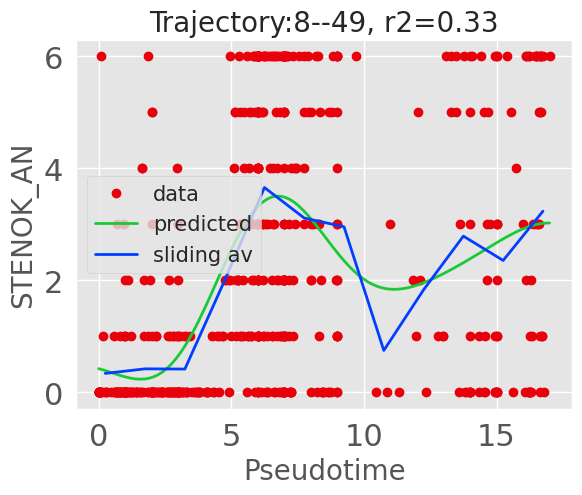

0 ('Trajectory:8--49', 'STENOK_AN', 0.3316140036756583)


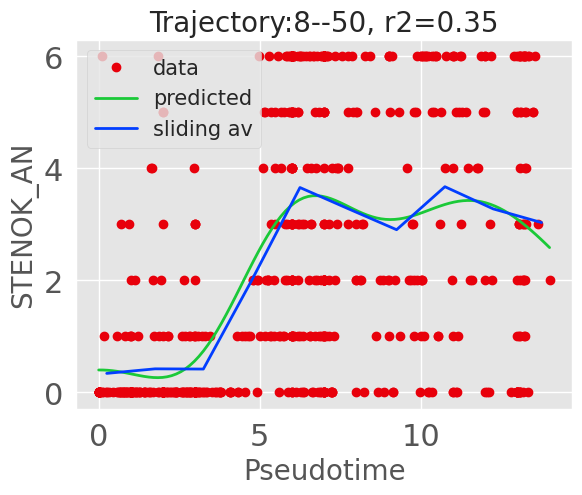

1 ('Trajectory:8--50', 'STENOK_AN', 0.3524288665225088)


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


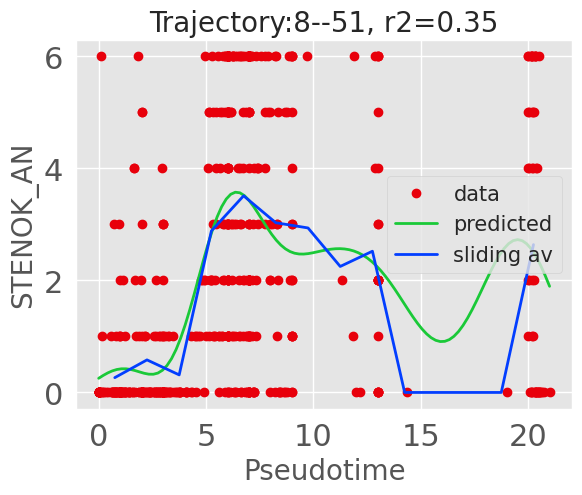

2 ('Trajectory:8--51', 'STENOK_AN', 0.3528680490406225)


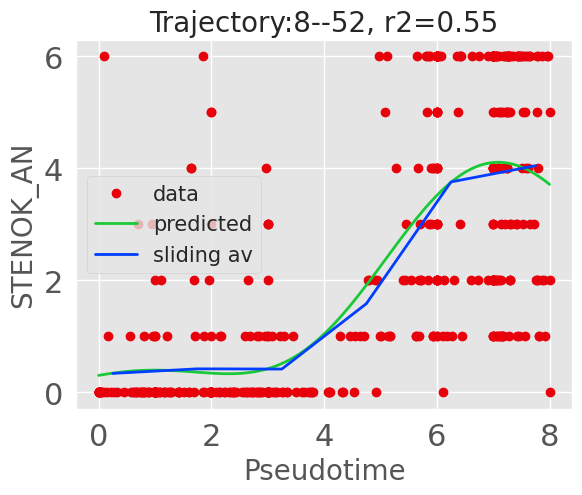

3 ('Trajectory:8--52', 'STENOK_AN', 0.551048811641768)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


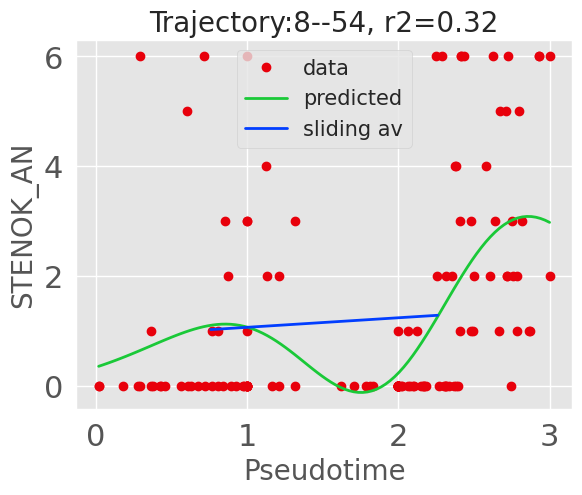

5 ('Trajectory:8--54', 'STENOK_AN', 0.3199780364014839)


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


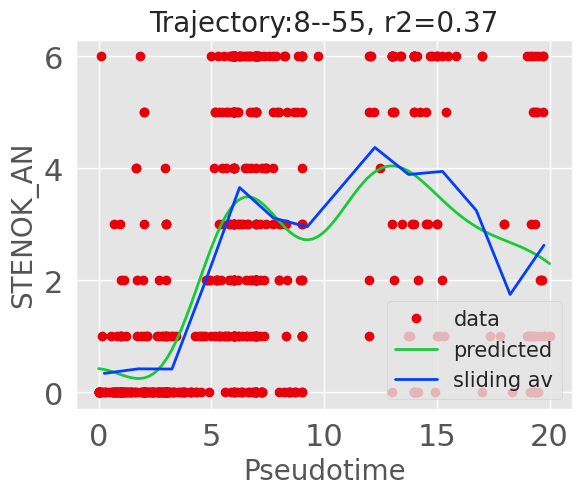

6 ('Trajectory:8--55', 'STENOK_AN', 0.3709200512450681)
[('Trajectory:8--49', 'STENOK_AN', 0.3316140036756583), ('Trajectory:8--50', 'STENOK_AN', 0.3524288665225088), ('Trajectory:8--51', 'STENOK_AN', 0.3528680490406225), ('Trajectory:8--52', 'STENOK_AN', 0.551048811641768), ('Trajectory:8--54', 'STENOK_AN', 0.3199780364014839), ('Trajectory:8--55', 'STENOK_AN', 0.3709200512450681)]
FK_STENOK ORDINAL


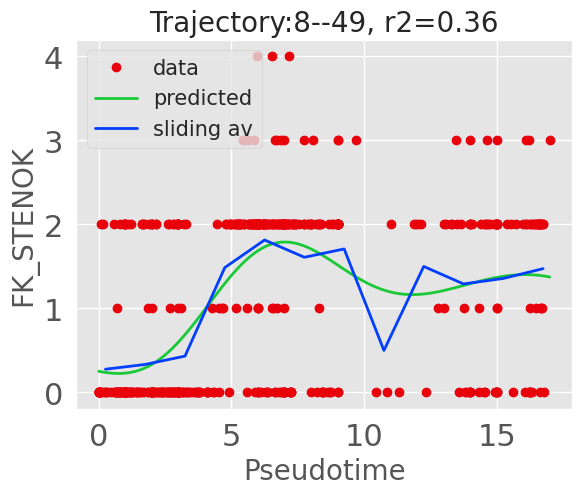

0 ('Trajectory:8--49', 'FK_STENOK', 0.3588016711530908)


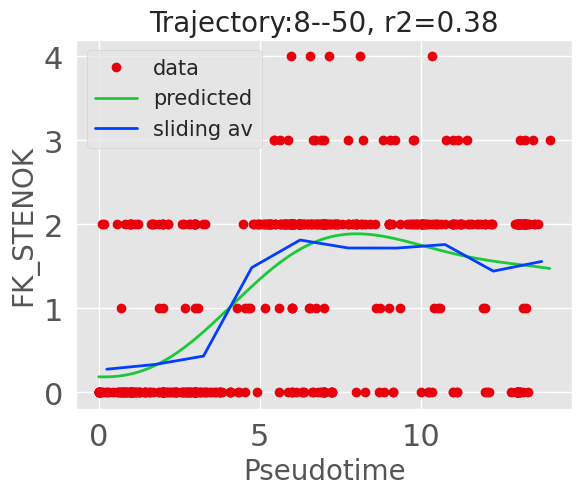

1 ('Trajectory:8--50', 'FK_STENOK', 0.38189732683161304)


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


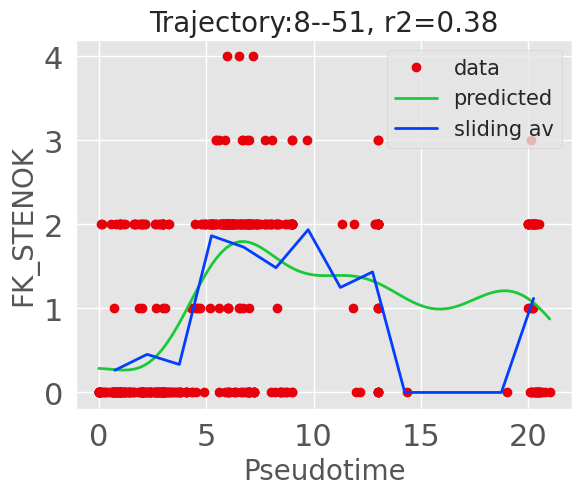

2 ('Trajectory:8--51', 'FK_STENOK', 0.3790782851194462)


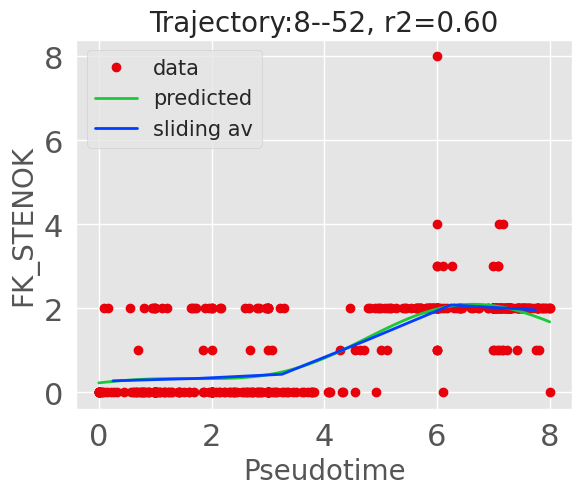

3 ('Trajectory:8--52', 'FK_STENOK', 0.5970612348381679)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


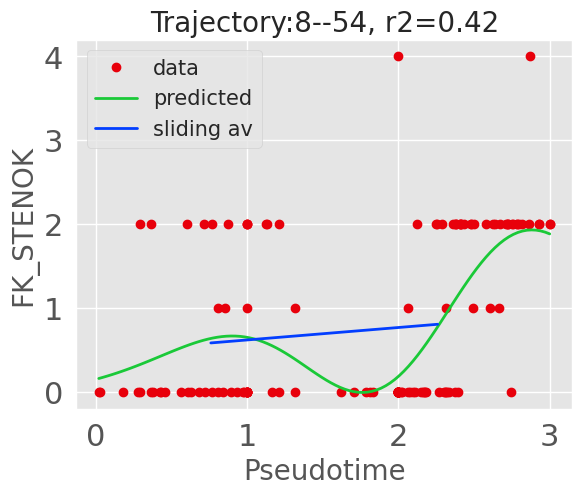

5 ('Trajectory:8--54', 'FK_STENOK', 0.4249444867766331)


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


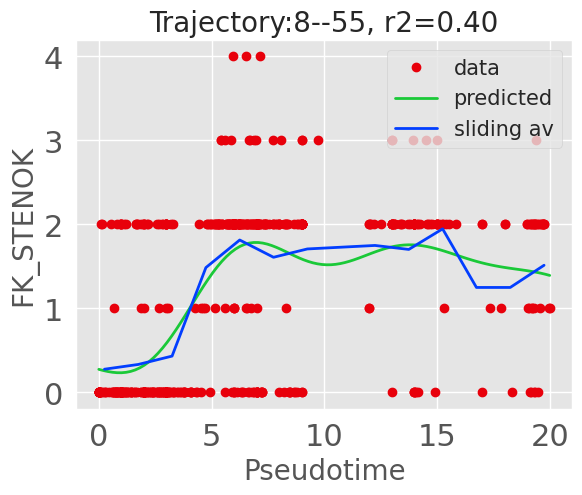

6 ('Trajectory:8--55', 'FK_STENOK', 0.4021847807559391)
[('Trajectory:8--49', 'FK_STENOK', 0.3588016711530908), ('Trajectory:8--50', 'FK_STENOK', 0.38189732683161304), ('Trajectory:8--51', 'FK_STENOK', 0.3790782851194462), ('Trajectory:8--52', 'FK_STENOK', 0.5970612348381679), ('Trajectory:8--54', 'FK_STENOK', 0.4249444867766331), ('Trajectory:8--55', 'FK_STENOK', 0.4021847807559391)]
IBS_POST ORDINAL


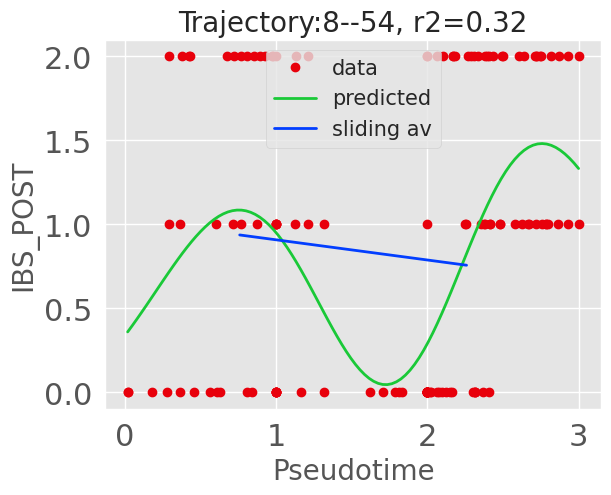

5 ('Trajectory:8--54', 'IBS_POST', 0.32120402051094754)
[('Trajectory:8--54', 'IBS_POST', 0.32120402051094754)]
GB ORDINAL


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


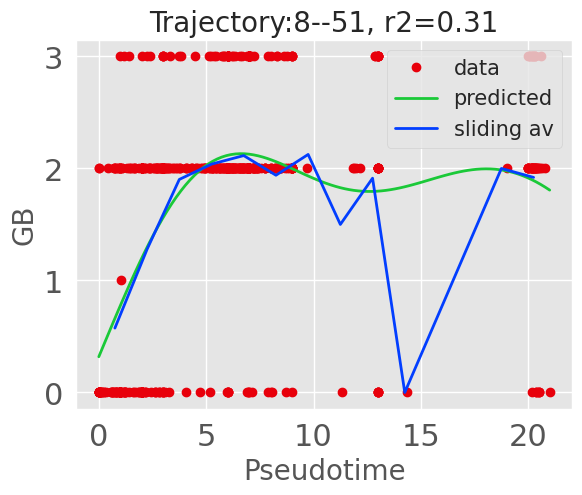

2 ('Trajectory:8--51', 'GB', 0.30655904888429697)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


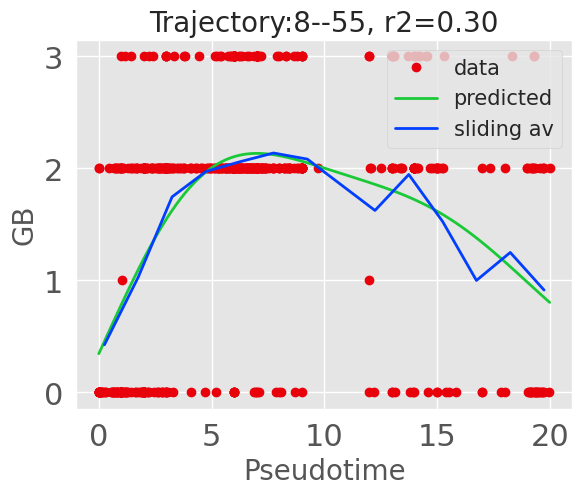

6 ('Trajectory:8--55', 'GB', 0.3049648552667562)
[('Trajectory:8--51', 'GB', 0.30655904888429697), ('Trajectory:8--55', 'GB', 0.3049648552667562)]
SIM_GIPERT BINARY
DLIT_AG ORDINAL


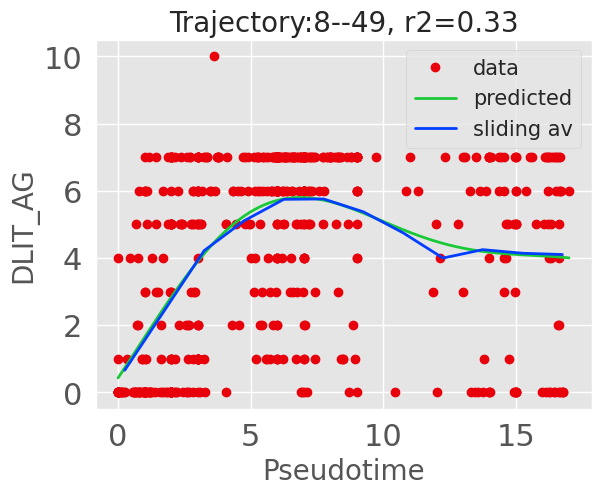

0 ('Trajectory:8--49', 'DLIT_AG', 0.33450607394714316)


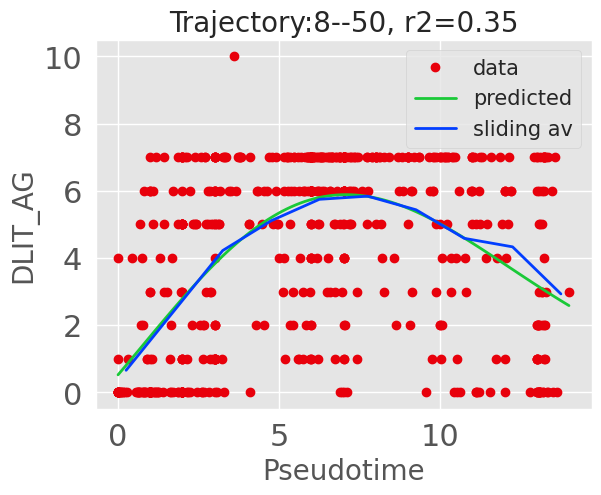

1 ('Trajectory:8--50', 'DLIT_AG', 0.34774446658591174)


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


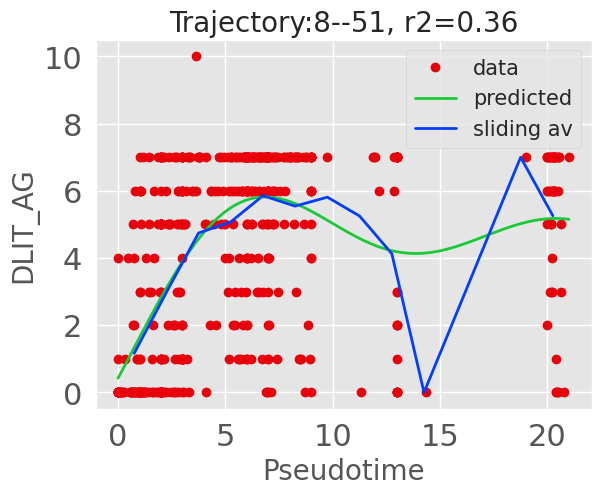

2 ('Trajectory:8--51', 'DLIT_AG', 0.36148950995898466)


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


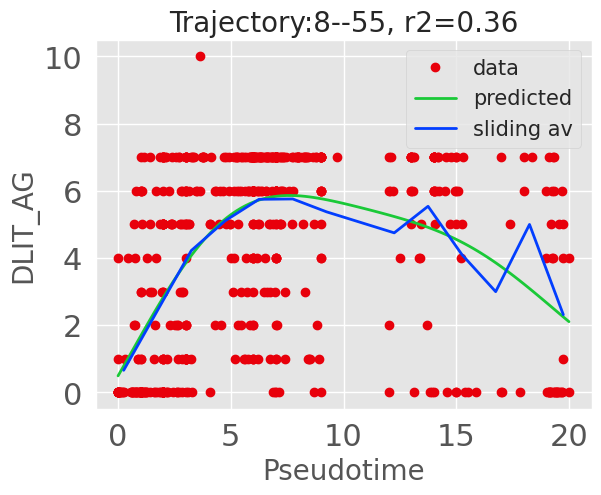

6 ('Trajectory:8--55', 'DLIT_AG', 0.3596560069034749)
[('Trajectory:8--49', 'DLIT_AG', 0.33450607394714316), ('Trajectory:8--50', 'DLIT_AG', 0.34774446658591174), ('Trajectory:8--51', 'DLIT_AG', 0.36148950995898466), ('Trajectory:8--55', 'DLIT_AG', 0.3596560069034749)]
ZSN_A ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


nr_11 BINARY
nr_01 BINARY
nr_02 BINARY
nr_03 BINARY
nr_04 BINARY


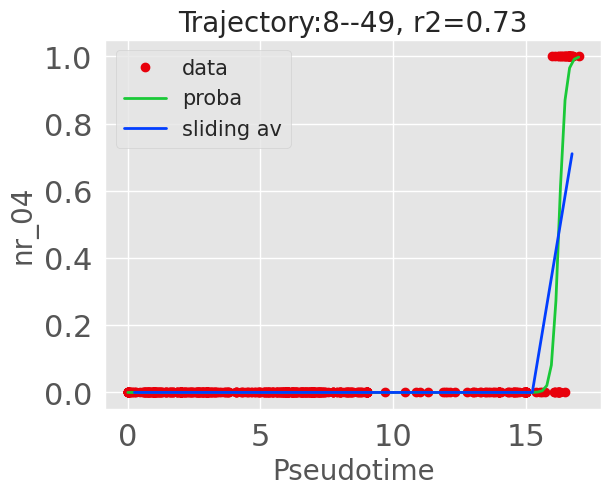

0 ('Trajectory:8--49', 'nr_04', 0.7285029785029786)
[('Trajectory:8--49', 'nr_04', 0.7285029785029786)]
nr_07 BINARY
nr_08 BINARY
np_01 BINARY
np_04 BINARY
np_05 BINARY
np_07 BINARY
np_08 BINARY
np_09 BINARY
np_10 BINARY
endocr_01 BINARY
endocr_02 BINARY
endocr_03 BINARY
zab_leg_01 BINARY
zab_leg_02 BINARY
zab_leg_03 BINARY
zab_leg_04 BINARY
zab_leg_06 BINARY
S_AD_ORIT CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

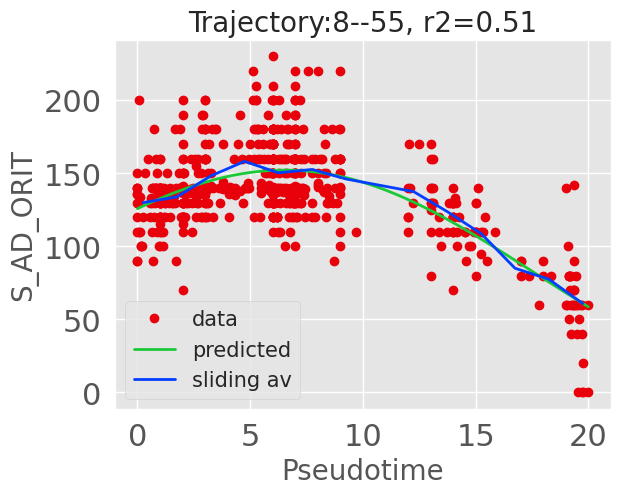

6 ('Trajectory:8--55', 'S_AD_ORIT', 0.5074240707353328)
[('Trajectory:8--55', 'S_AD_ORIT', 0.5074240707353328)]
D_AD_ORIT CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.w

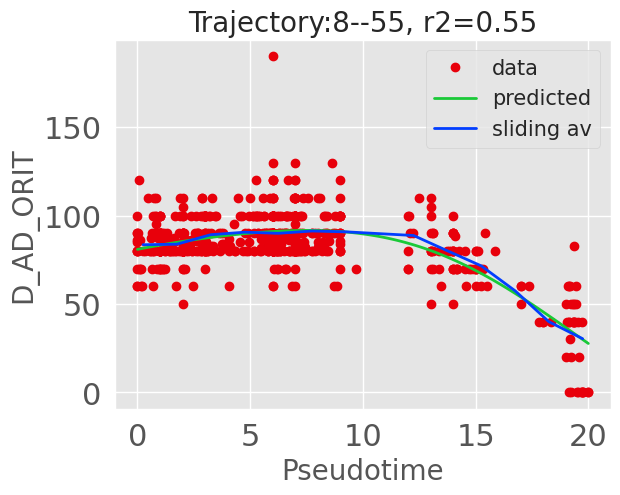

6 ('Trajectory:8--55', 'D_AD_ORIT', 0.5491121011287179)
[('Trajectory:8--55', 'D_AD_ORIT', 0.5491121011287179)]
O_L_POST BINARY
K_SH_POST BINARY


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


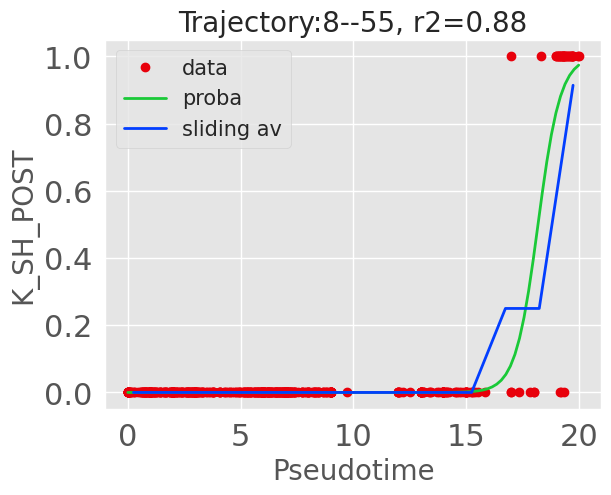

6 ('Trajectory:8--55', 'K_SH_POST', 0.8753599341834636)
[('Trajectory:8--55', 'K_SH_POST', 0.8753599341834636)]
MP_TP_POST BINARY


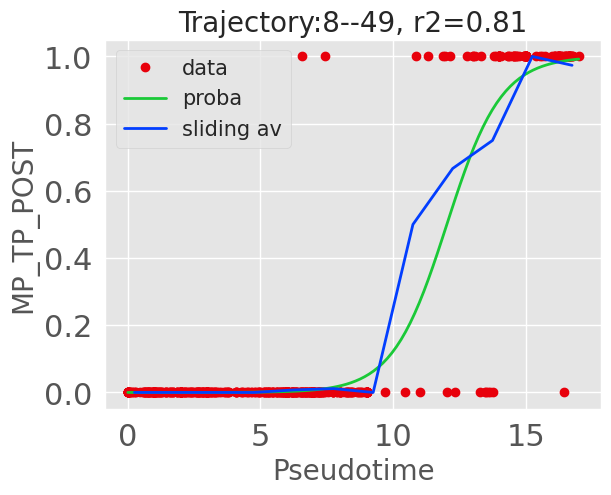

0 ('Trajectory:8--49', 'MP_TP_POST', 0.805637276109717)
[('Trajectory:8--49', 'MP_TP_POST', 0.805637276109717)]
SVT_POST BINARY
GT_POST BINARY
FIB_G_POST BINARY
ant_im ORDINAL


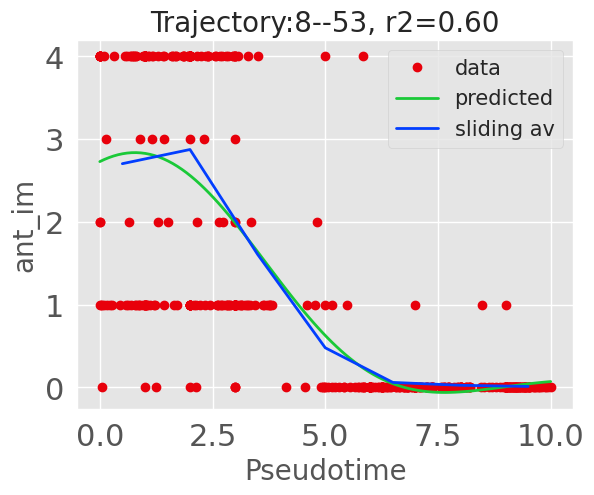

4 ('Trajectory:8--53', 'ant_im', 0.6027711905035971)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[('Trajectory:8--53', 'ant_im', 0.6027711905035971)]
lat_im ORDINAL


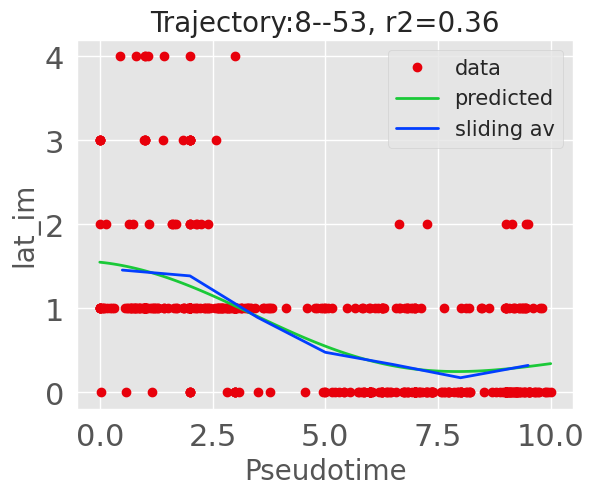

4 ('Trajectory:8--53', 'lat_im', 0.357534618746433)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[('Trajectory:8--53', 'lat_im', 0.357534618746433)]
inf_im ORDINAL


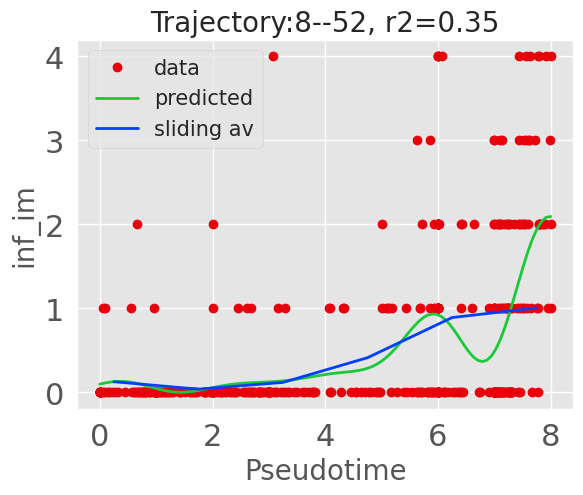

3 ('Trajectory:8--52', 'inf_im', 0.3481391586586212)


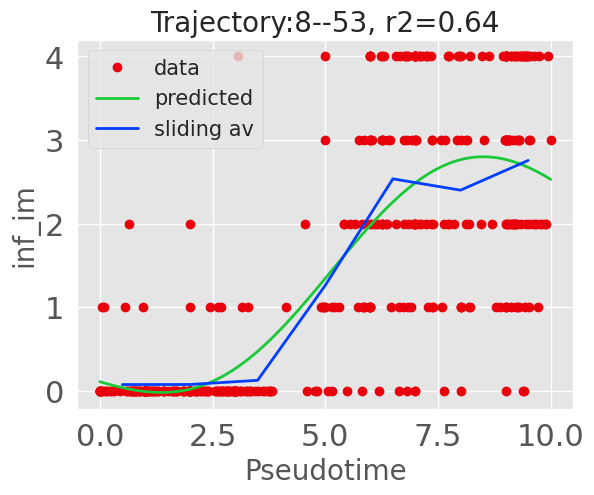

4 ('Trajectory:8--53', 'inf_im', 0.6404760574191943)
[('Trajectory:8--52', 'inf_im', 0.3481391586586212), ('Trajectory:8--53', 'inf_im', 0.6404760574191943)]
post_im ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


IM_PG_P BINARY
ritm_ecg_p_01 BINARY
ritm_ecg_p_02 BINARY


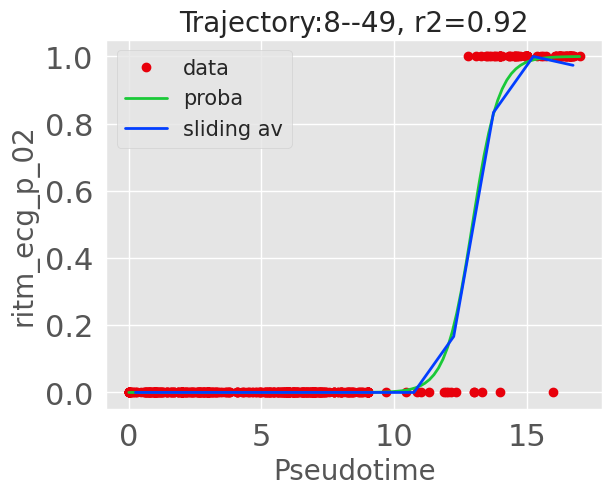

0 ('Trajectory:8--49', 'ritm_ecg_p_02', 0.9185366517067863)
[('Trajectory:8--49', 'ritm_ecg_p_02', 0.9185366517067863)]
ritm_ecg_p_04 BINARY
ritm_ecg_p_06 BINARY
ritm_ecg_p_07 BINARY
ritm_ecg_p_08 BINARY
n_r_ecg_p_01 BINARY
n_r_ecg_p_02 BINARY
n_r_ecg_p_03 BINARY
n_r_ecg_p_04 BINARY
n_r_ecg_p_05 BINARY
n_r_ecg_p_06 BINARY


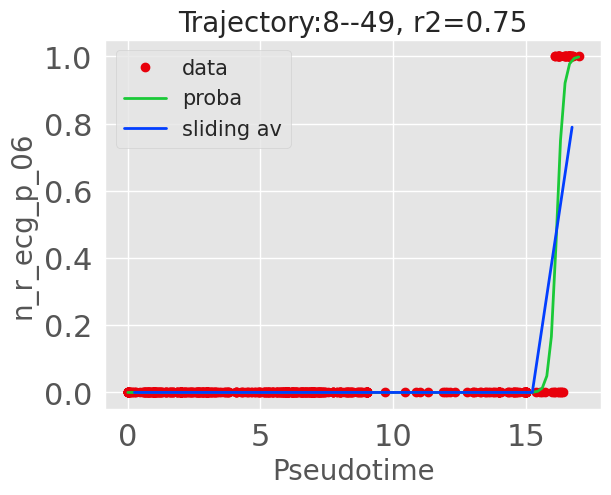

0 ('Trajectory:8--49', 'n_r_ecg_p_06', 0.754364381956649)
[('Trajectory:8--49', 'n_r_ecg_p_06', 0.754364381956649)]
n_r_ecg_p_08 BINARY
n_r_ecg_p_09 BINARY
n_r_ecg_p_10 BINARY
n_p_ecg_p_01 BINARY
n_p_ecg_p_03 BINARY
n_p_ecg_p_04 BINARY
n_p_ecg_p_05 BINARY
n_p_ecg_p_06 BINARY
n_p_ecg_p_07 BINARY
n_p_ecg_p_08 BINARY
n_p_ecg_p_09 BINARY
n_p_ecg_p_10 BINARY
n_p_ecg_p_11 BINARY
n_p_ecg_p_12 BINARY
fibr_ter_01 BINARY
fibr_ter_02 BINARY
fibr_ter_03 BINARY
fibr_ter_05 BINARY
fibr_ter_06 BINARY


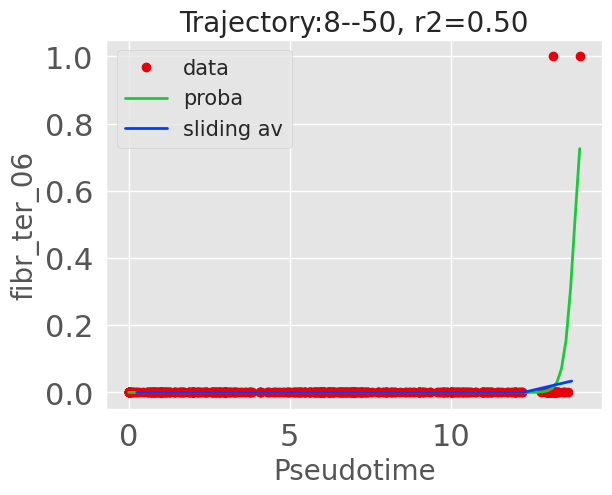

1 ('Trajectory:8--50', 'fibr_ter_06', 0.4983948635634029)
[('Trajectory:8--50', 'fibr_ter_06', 0.4983948635634029)]
fibr_ter_07 BINARY
fibr_ter_08 BINARY
GIPO_K BINARY
K_BLOOD CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GIPER_NA BINARY
NA_BLOOD CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn

ALT_BLOOD CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


AST_BLOOD CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


L_BLOOD CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/hom

ROE CONTINUOUS


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


TIME_B_S ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


R_AB_1_n ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


R_AB_2_n ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


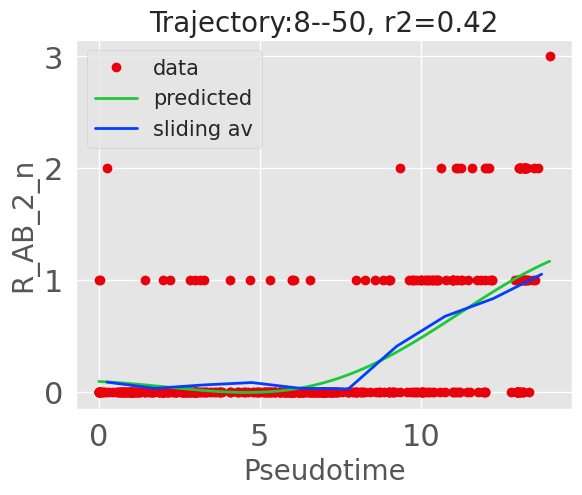

1 ('Trajectory:8--50', 'R_AB_2_n', 0.42204219825499745)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/hom

[('Trajectory:8--50', 'R_AB_2_n', 0.42204219825499745)]
R_AB_3_n ORDINAL


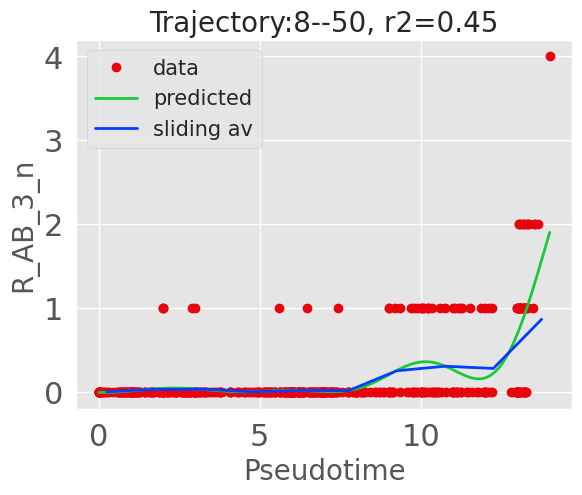

1 ('Trajectory:8--50', 'R_AB_3_n', 0.4549657318307927)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[('Trajectory:8--50', 'R_AB_3_n', 0.4549657318307927)]
NITR_S ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


NA_R_1_n ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


NA_R_2_n ORDINAL


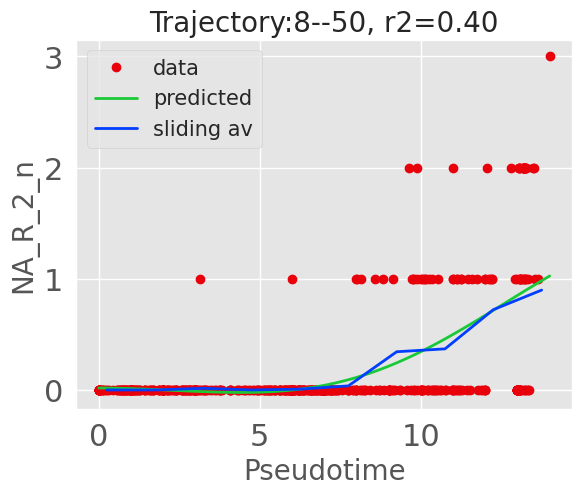

1 ('Trajectory:8--50', 'NA_R_2_n', 0.3969907593716182)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[('Trajectory:8--50', 'NA_R_2_n', 0.3969907593716182)]
NA_R_3_n ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


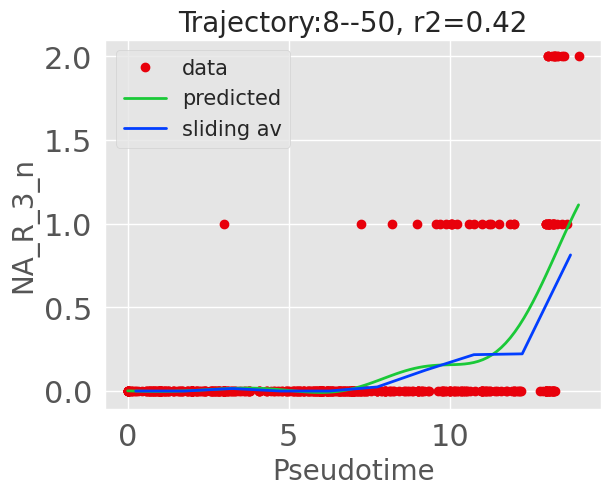

1 ('Trajectory:8--50', 'NA_R_3_n', 0.41723432604331656)


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[('Trajectory:8--50', 'NA_R_3_n', 0.41723432604331656)]
NOT_NA_1_n ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/hom

NOT_NA_2_n ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


NOT_NA_3_n ORDINAL


/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/hom

LID_S_n BINARY
B_BLOK_S_n BINARY
ANT_CA_S_n BINARY
GEPAR_S_n BINARY
ASP_S_n BINARY
TIKL_S_n BINARY
TRENT_S_n BINARY
FIBR_PREDS BINARY
PREDS_TAH BINARY
JELUD_TAH BINARY
FIBR_JELUD BINARY
A_V_BLOK BINARY
OTEK_LANC BINARY
RAZRIV BINARY


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


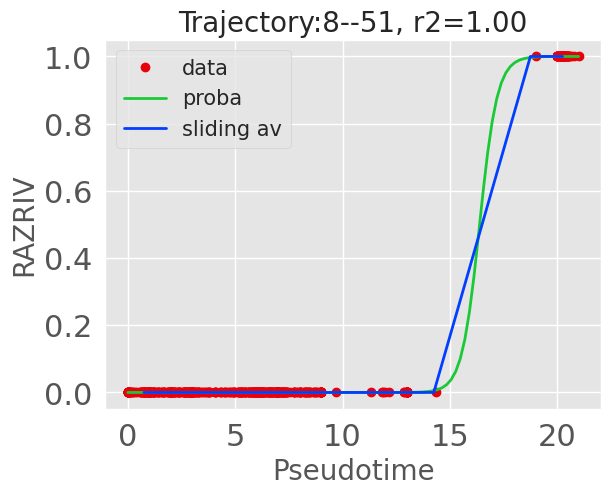

2 ('Trajectory:8--51', 'RAZRIV', 1.0)
[('Trajectory:8--51', 'RAZRIV', 1.0)]
DRESSLER BINARY
ZSN BINARY
REC_IM BINARY
P_IM_STEN BINARY
LET_IS_0 BINARY


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


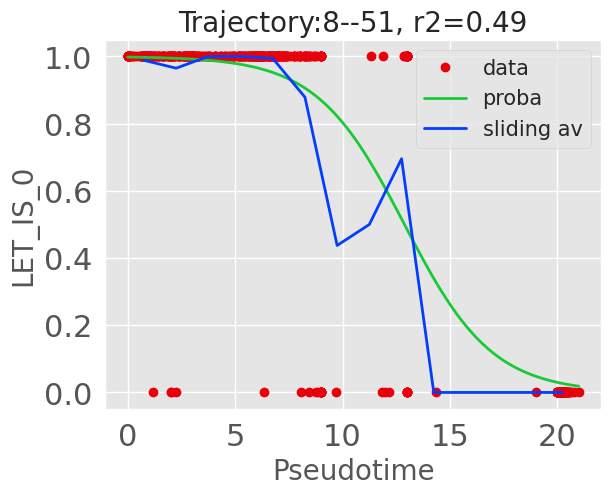

2 ('Trajectory:8--51', 'LET_IS_0', 0.48682174475533335)


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


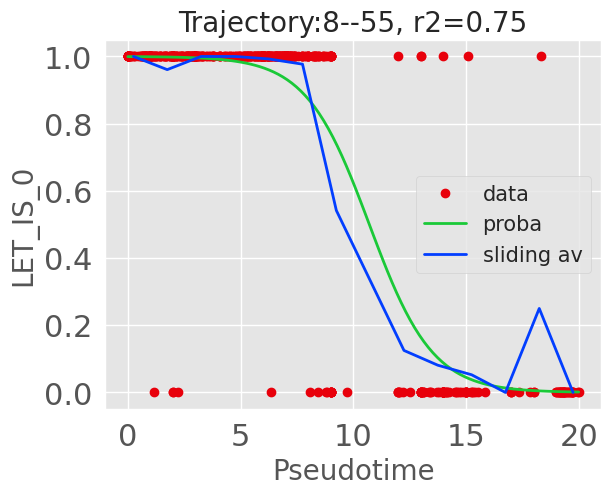

6 ('Trajectory:8--55', 'LET_IS_0', 0.7490380135627146)
[('Trajectory:8--51', 'LET_IS_0', 0.48682174475533335), ('Trajectory:8--55', 'LET_IS_0', 0.7490380135627146)]
LET_IS_1 BINARY


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


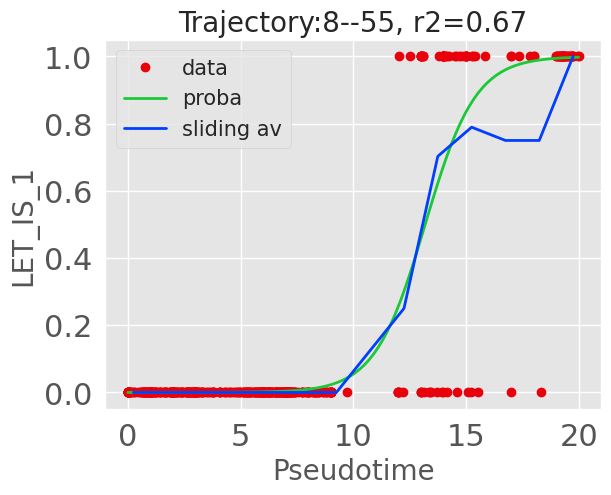

6 ('Trajectory:8--55', 'LET_IS_1', 0.6683087027914615)
[('Trajectory:8--55', 'LET_IS_1', 0.6683087027914615)]
LET_IS_2 BINARY
LET_IS_3 BINARY


/home/zinovyev/gits/ClinTrajan/code/clintraj_util.py:128: RuntimeWarning: invalid value encountered in divide
  bin_avgs = vals / counts


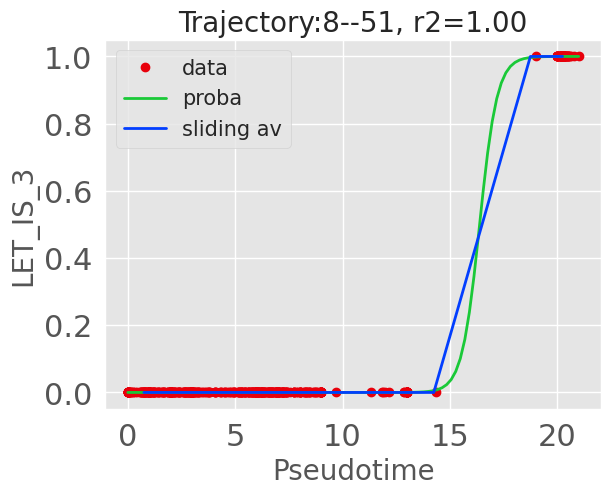

2 ('Trajectory:8--51', 'LET_IS_3', 1.0)
[('Trajectory:8--51', 'LET_IS_3', 1.0)]
LET_IS_4 BINARY
LET_IS_5 BINARY
LET_IS_6 BINARY
LET_IS_7 BINARY


In [15]:
# associate trajectories with variables by regression

reload(clintraj_eltree)
from clintraj_eltree import regression_of_variable_with_trajectories


R2_Threshold = 0.3
R2_Threshold_For_Complications = 0.1
producePlot = True
all_trajectory_variable_associations = {}
complication_variables = ['LET_IS_0','LET_IS_1','LET_IS_2','LET_IS_3','LET_IS_4','LET_IS_5','LET_IS_6','LET_IS_7','FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD','A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN','REC_IM','P_IM_STEN']

for k,var in enumerate(variable_names):
    print(var,variable_types[variable_names.index(var)])
    if var in complication_variables:
        r2th = R2_Threshold_For_Complications
    else:
        r2th = R2_Threshold
    List_of_Associations = regression_of_variable_with_trajectories(PseudoTimeTraj,var,variable_names,
                                                                    variable_types,X_original,R2_Threshold=r2th,
                                                                    producePlot=producePlot,
                                                                    Continuous_Regression_Type='gpr',
                                                                    verbose=True)
    if len(List_of_Associations)>0:
        print(List_of_Associations)
        all_trajectory_variable_associations[var]=List_of_Associations

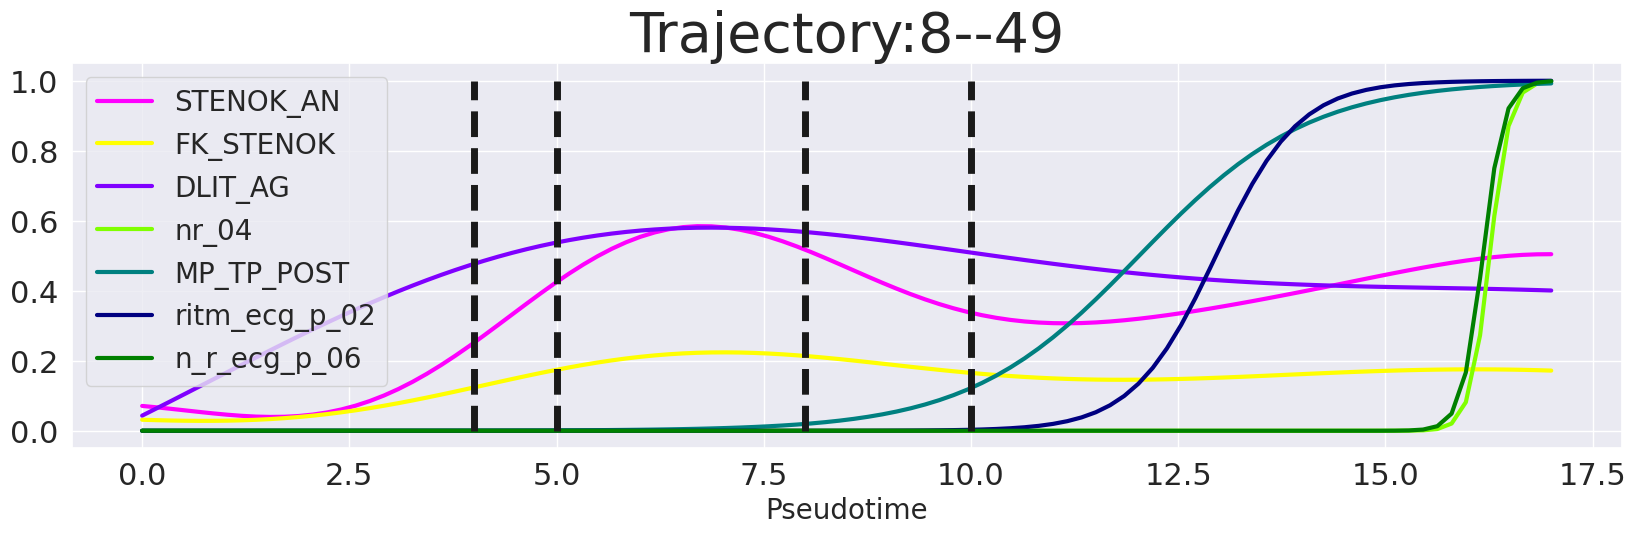

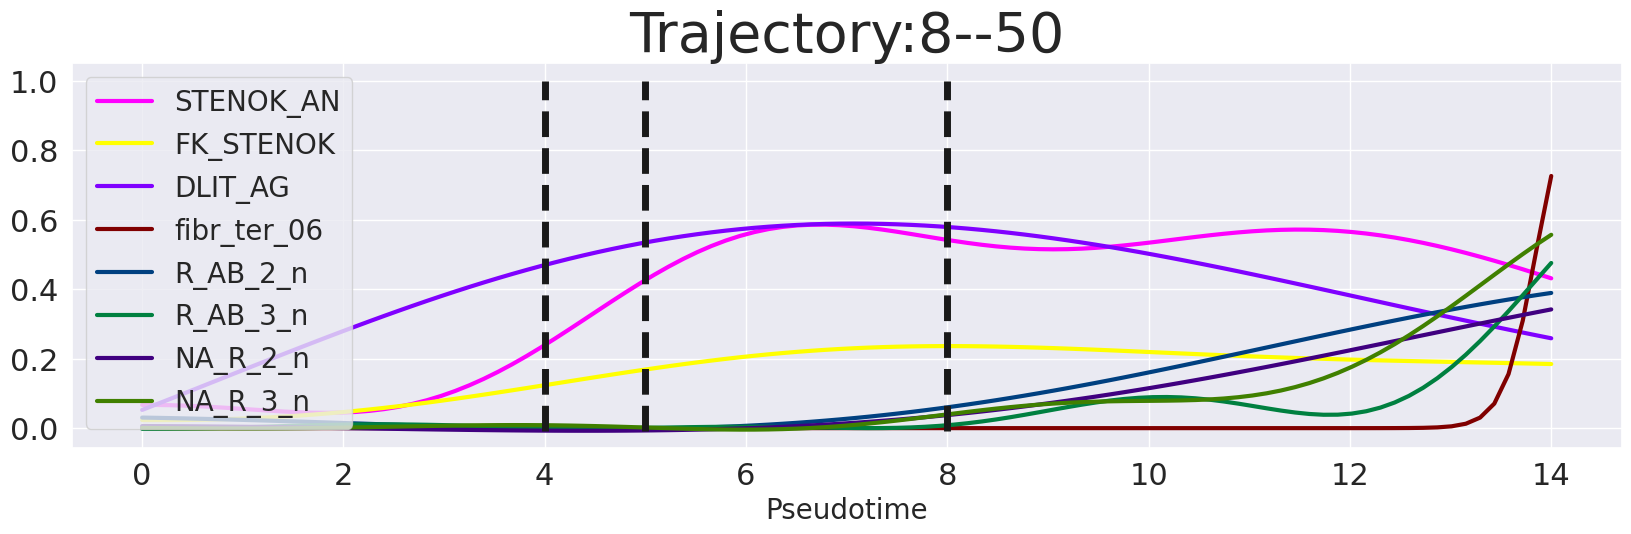

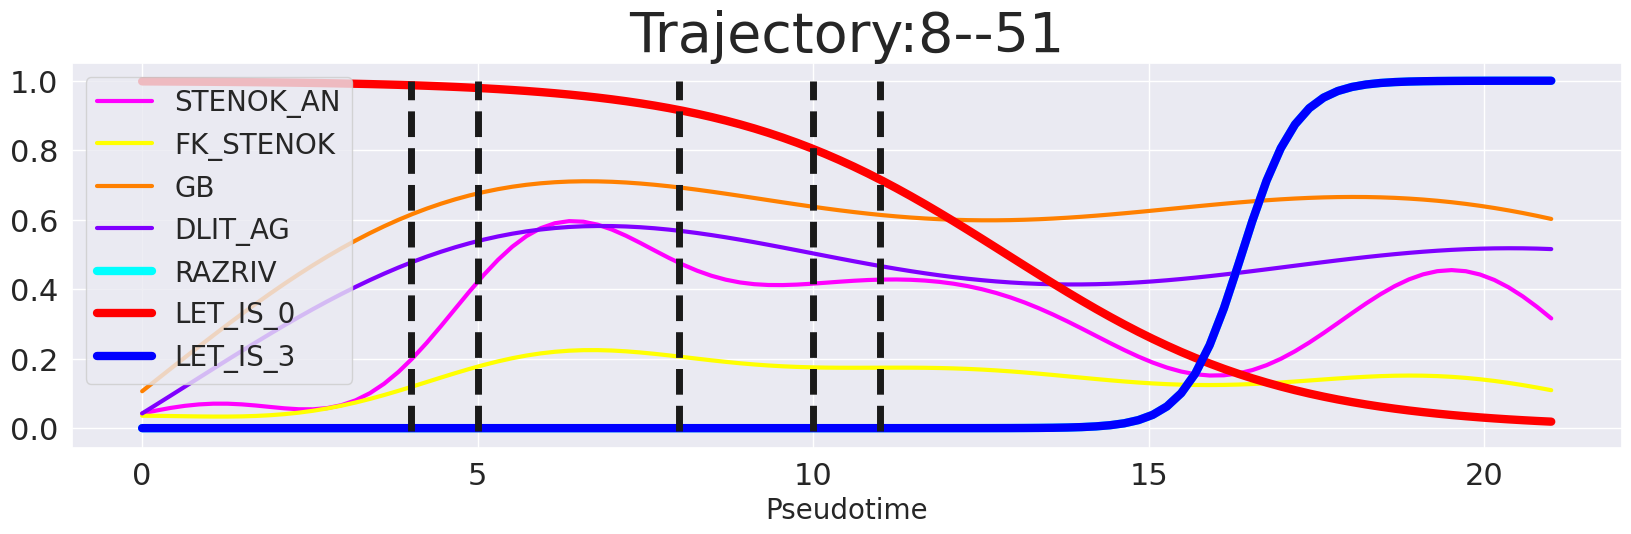

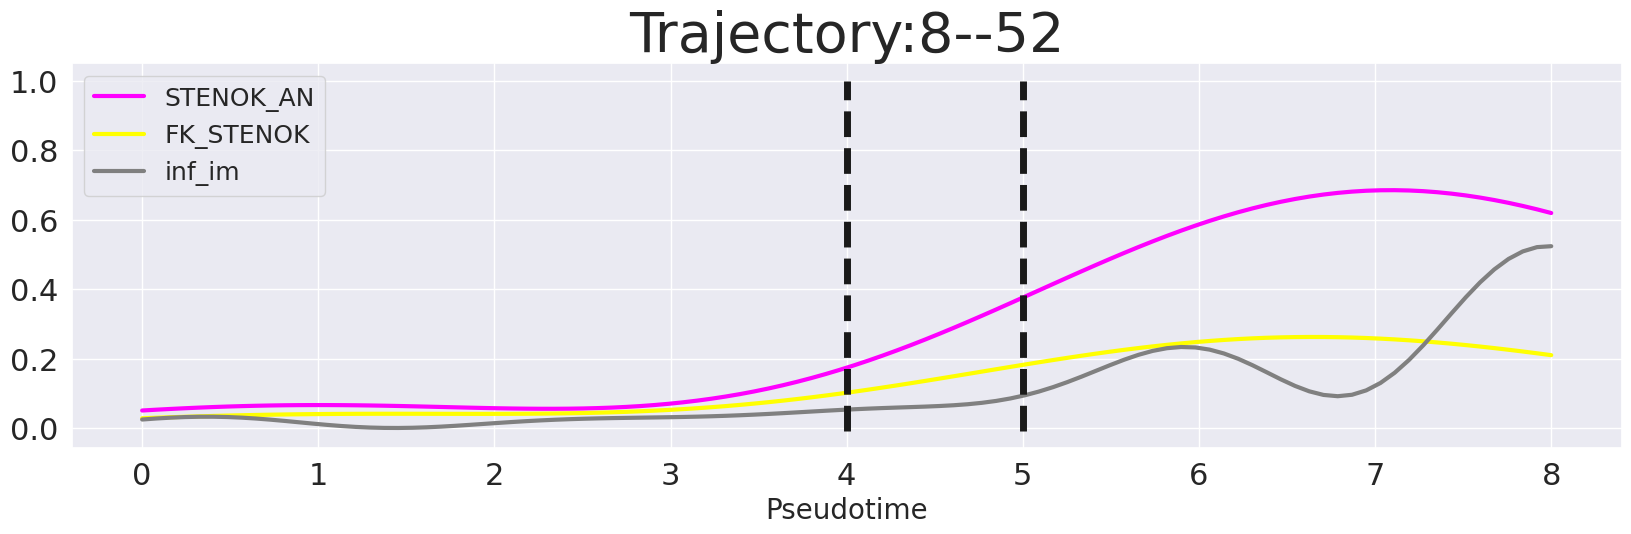

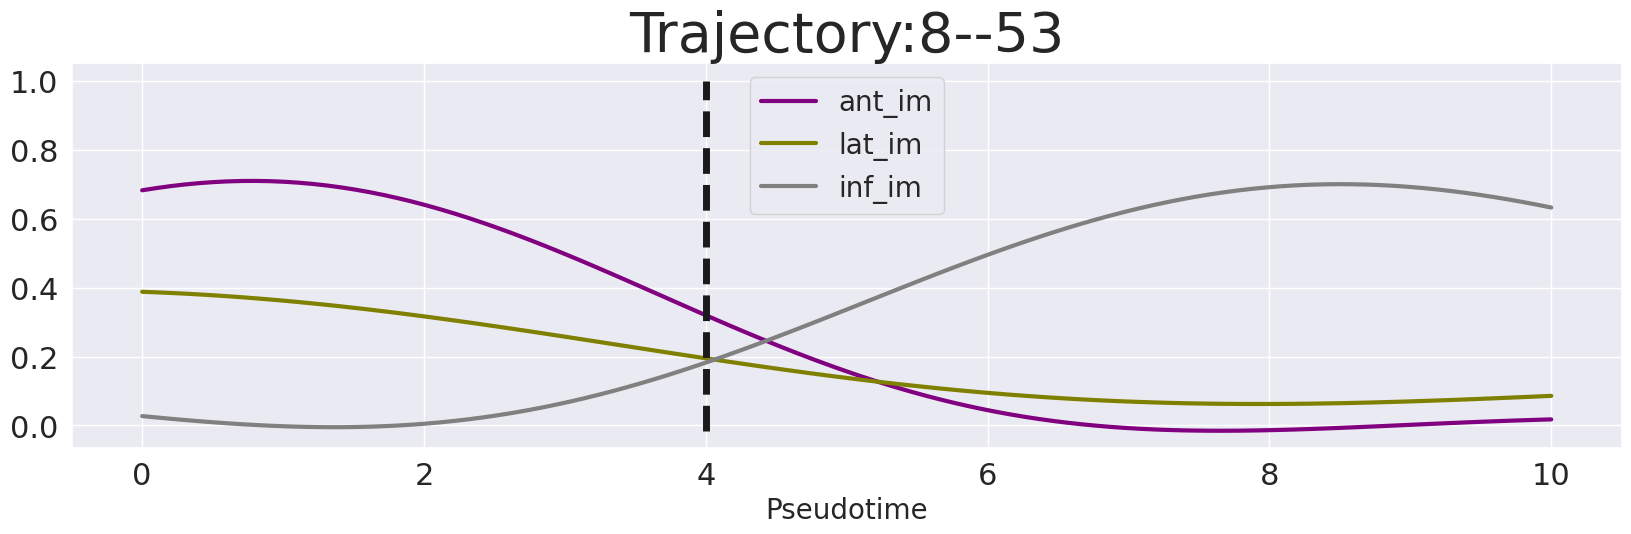

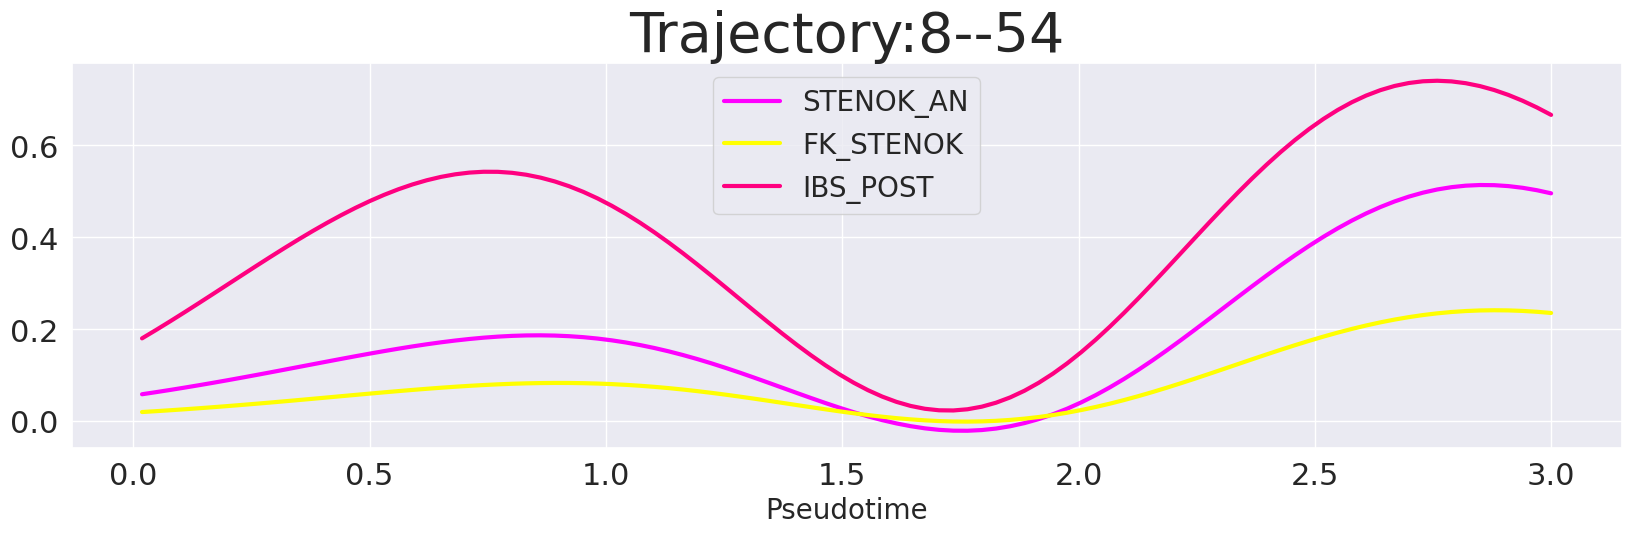

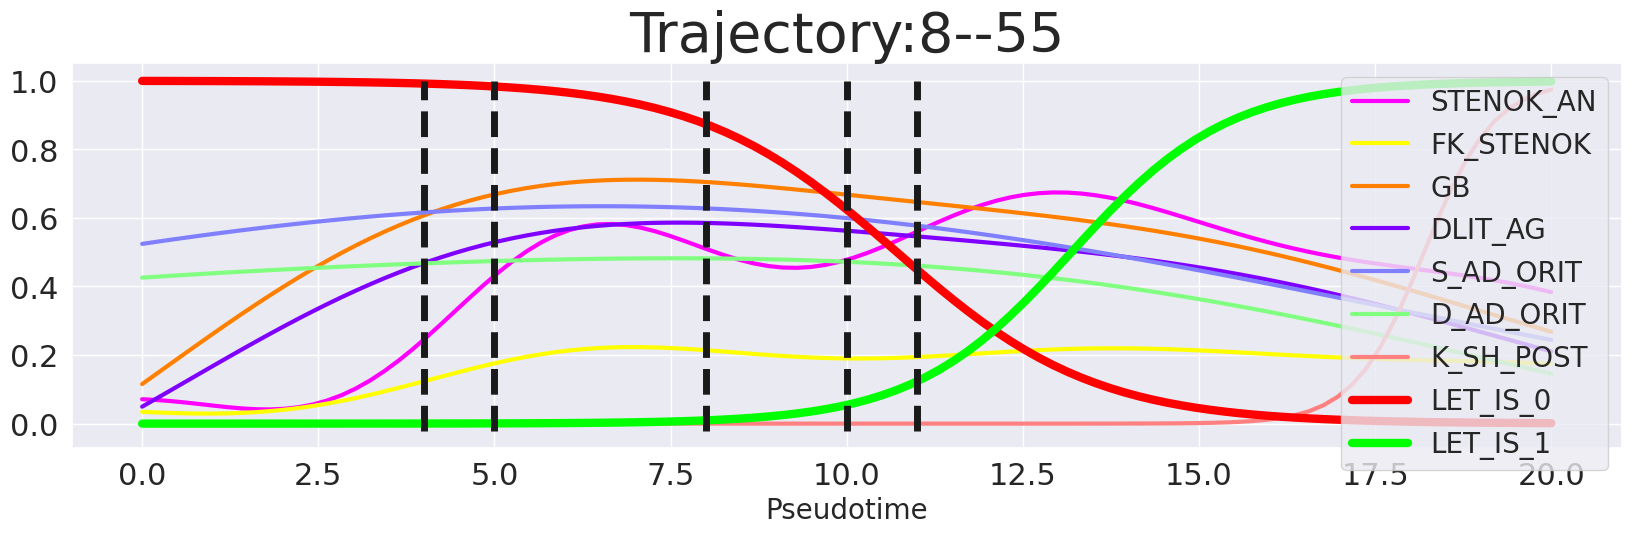

In [32]:
# Draw pseudotime dependencies of variables significantly associated with trajectories

reload(clintraj_util)
from clintraj_util import get_standard_color_seq


color_seq = get_standard_color_seq()
var_colors = {}
all_vars = list(all_trajectory_variable_associations.keys())
complication_variables = ['LET_IS_0','LET_IS_1','LET_IS_2','LET_IS_3','LET_IS_4','LET_IS_5','LET_IS_6','LET_IS_7','FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD','A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN','REC_IM','P_IM_STEN']
k=0
for var in complication_variables:
    if var in all_trajectory_variable_associations:
        #print(k)
        var_colors[var] = color_seq[k]
        k = k+1
        if k>len(color_seq)-1:
            k=0
for var in all_vars:
    if not var in complication_variables:
        #print(k)
        var_colors[var] = color_seq[k]
        k = k+1
        if k>len(color_seq)-1:
            k=0

sns.set(font_scale=2)

min_val = 1
max_val = 0

for pstt in PseudoTimeTraj:
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    fig = plt.figure(figsize=(20, 5))
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn==TrajName:
                var = assoc[1]
                if var in complication_variables:
                    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                               linewidth=6,draw_datapoints=False)
                else:
                    vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                               linewidth=3,draw_datapoints=False)
                if vals is not None:
                    min_val = min(min_val,min(vals))
                    max_val = max(max_val,max(vals))
                #else:
                #    print(var,TrajName,' regressor is not found')
    bp = pstt['BranchingPoints']
    for x in bp:
        plt.plot([x,x],[min_val,max_val],'k--',linewidth=5)
    if TrajName.endswith('52'):
        plt.legend(fontsize=18,loc='upper left')
    else:
        plt.legend(fontsize=20)
    plt.title(TrajName,fontsize=40)
    plt.savefig(TrajName+'.png', format='png', dpi=300)
    plt.show()

In [17]:
## Show selected variable dynamics on several trajectories simultaneously

reload(clintraj_eltree)
from clintraj_eltree import draw_pseudotime_dependence


color_seq = get_standard_color_seq()
var_colors = {}
line_styles = ['-','--','-.',':']

trajs_endpoints = [56,50,55,52]
trajs_endpoints_str = [str(ep) for ep in trajs_endpoints]
trajs = len(trajs_endpoints)*[None]
for pstt in PseudoTimeTraj:
    traj = pstt['Trajectory']
    if traj[-1] in trajs_endpoints:
        trajs[trajs_endpoints.index(traj[-1])] = pstt


#all_vars = ['MP_TP_POST','ritm_ecg_p_01','ritm_ecg_p_07']
#all_vars = ['MP_TP_POST','ritm_ecg_p_01',  'ritm_ecg_p_07', 'NA_R_2_n']
all_vars = ['LET_IS_2','LET_IS_4']
if False:
    all_vars = []
    for var in all_trajectory_variable_associations:
        associations = all_trajectory_variable_associations[var]
        for assoc in associations:
            trajn = assoc[0]
            if trajn[-2:] in trajs_endpoints_str:
                all_vars.append(var)
    all_vars = list(set(all_vars))

for k,var in enumerate(all_vars):
    var_colors[var] = color_seq[k]
var_colors[all_vars[0]] = [1,0,1]
var_colors[all_vars[1]] = [0,0,1]
#var_colors[all_vars[0]] = [0,1,0]
#var_colors[all_vars[1]] = [0,0.5,0.5]
#var_colors[all_vars[2]] = [0.5,0.5,0]
#var_colors[all_vars[3]] = [0.5,0,0.5]
    
title = 'Trajectories_'+'-'.join(trajs_endpoints_str)
fig = plt.figure(figsize=(20, 5))
bp = []
for var in all_vars:
    for p,pstt in enumerate(trajs):
        if var in complication_variables:
            vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                       linewidth=6,draw_datapoints=False,label=var+'_'+trajs_endpoints_str[p],
                                       linestyle=line_styles[p])
        else:
            vals = draw_pseudotime_dependence(pstt,var,variable_names,variable_types,X_original,var_colors[var],
                                       linewidth=3,draw_datapoints=False,label=var+'_'+trajs_endpoints_str[p],
                                       linestyle=line_styles[p])
            #plt.legend(fontsize=20)
            #plt.ylim([0,1])
        if vals is not None:
            min_val = min(min_val,min(vals))
            max_val = max(max_val,max(vals))
        bp1 = pstt['BranchingPoints']
        bp = bp+bp1
    for x in bp:
        plt.plot([x,x],[min_val,max_val],'k--',linewidth=5)
    #plt.legend(fontsize=20)
    plt.title(title,fontsize=40)
    plt.savefig(title+'.png', format='png', dpi=300)
plt.show()
    

TypeError: 'NoneType' object is not subscriptable

<Figure size 2000x500 with 0 Axes>

['inf_im', 'ant_im', 'lat_im', 'IBS_POST', 'n_r_ecg_p_06', 'ritm_ecg_p_02', 'nr_04', 'MP_TP_POST', 'NA_R_3_n', 'NA_R_2_n', 'R_AB_3_n', 'fibr_ter_06', 'R_AB_2_n', 'RAZRIV', 'LET_IS_3', 'STENOK_AN', 'FK_STENOK', 'DLIT_AG', 'D_AD_ORIT', 'S_AD_ORIT', 'K_SH_POST', 'LET_IS_1', 'GB', 'LET_IS_0']



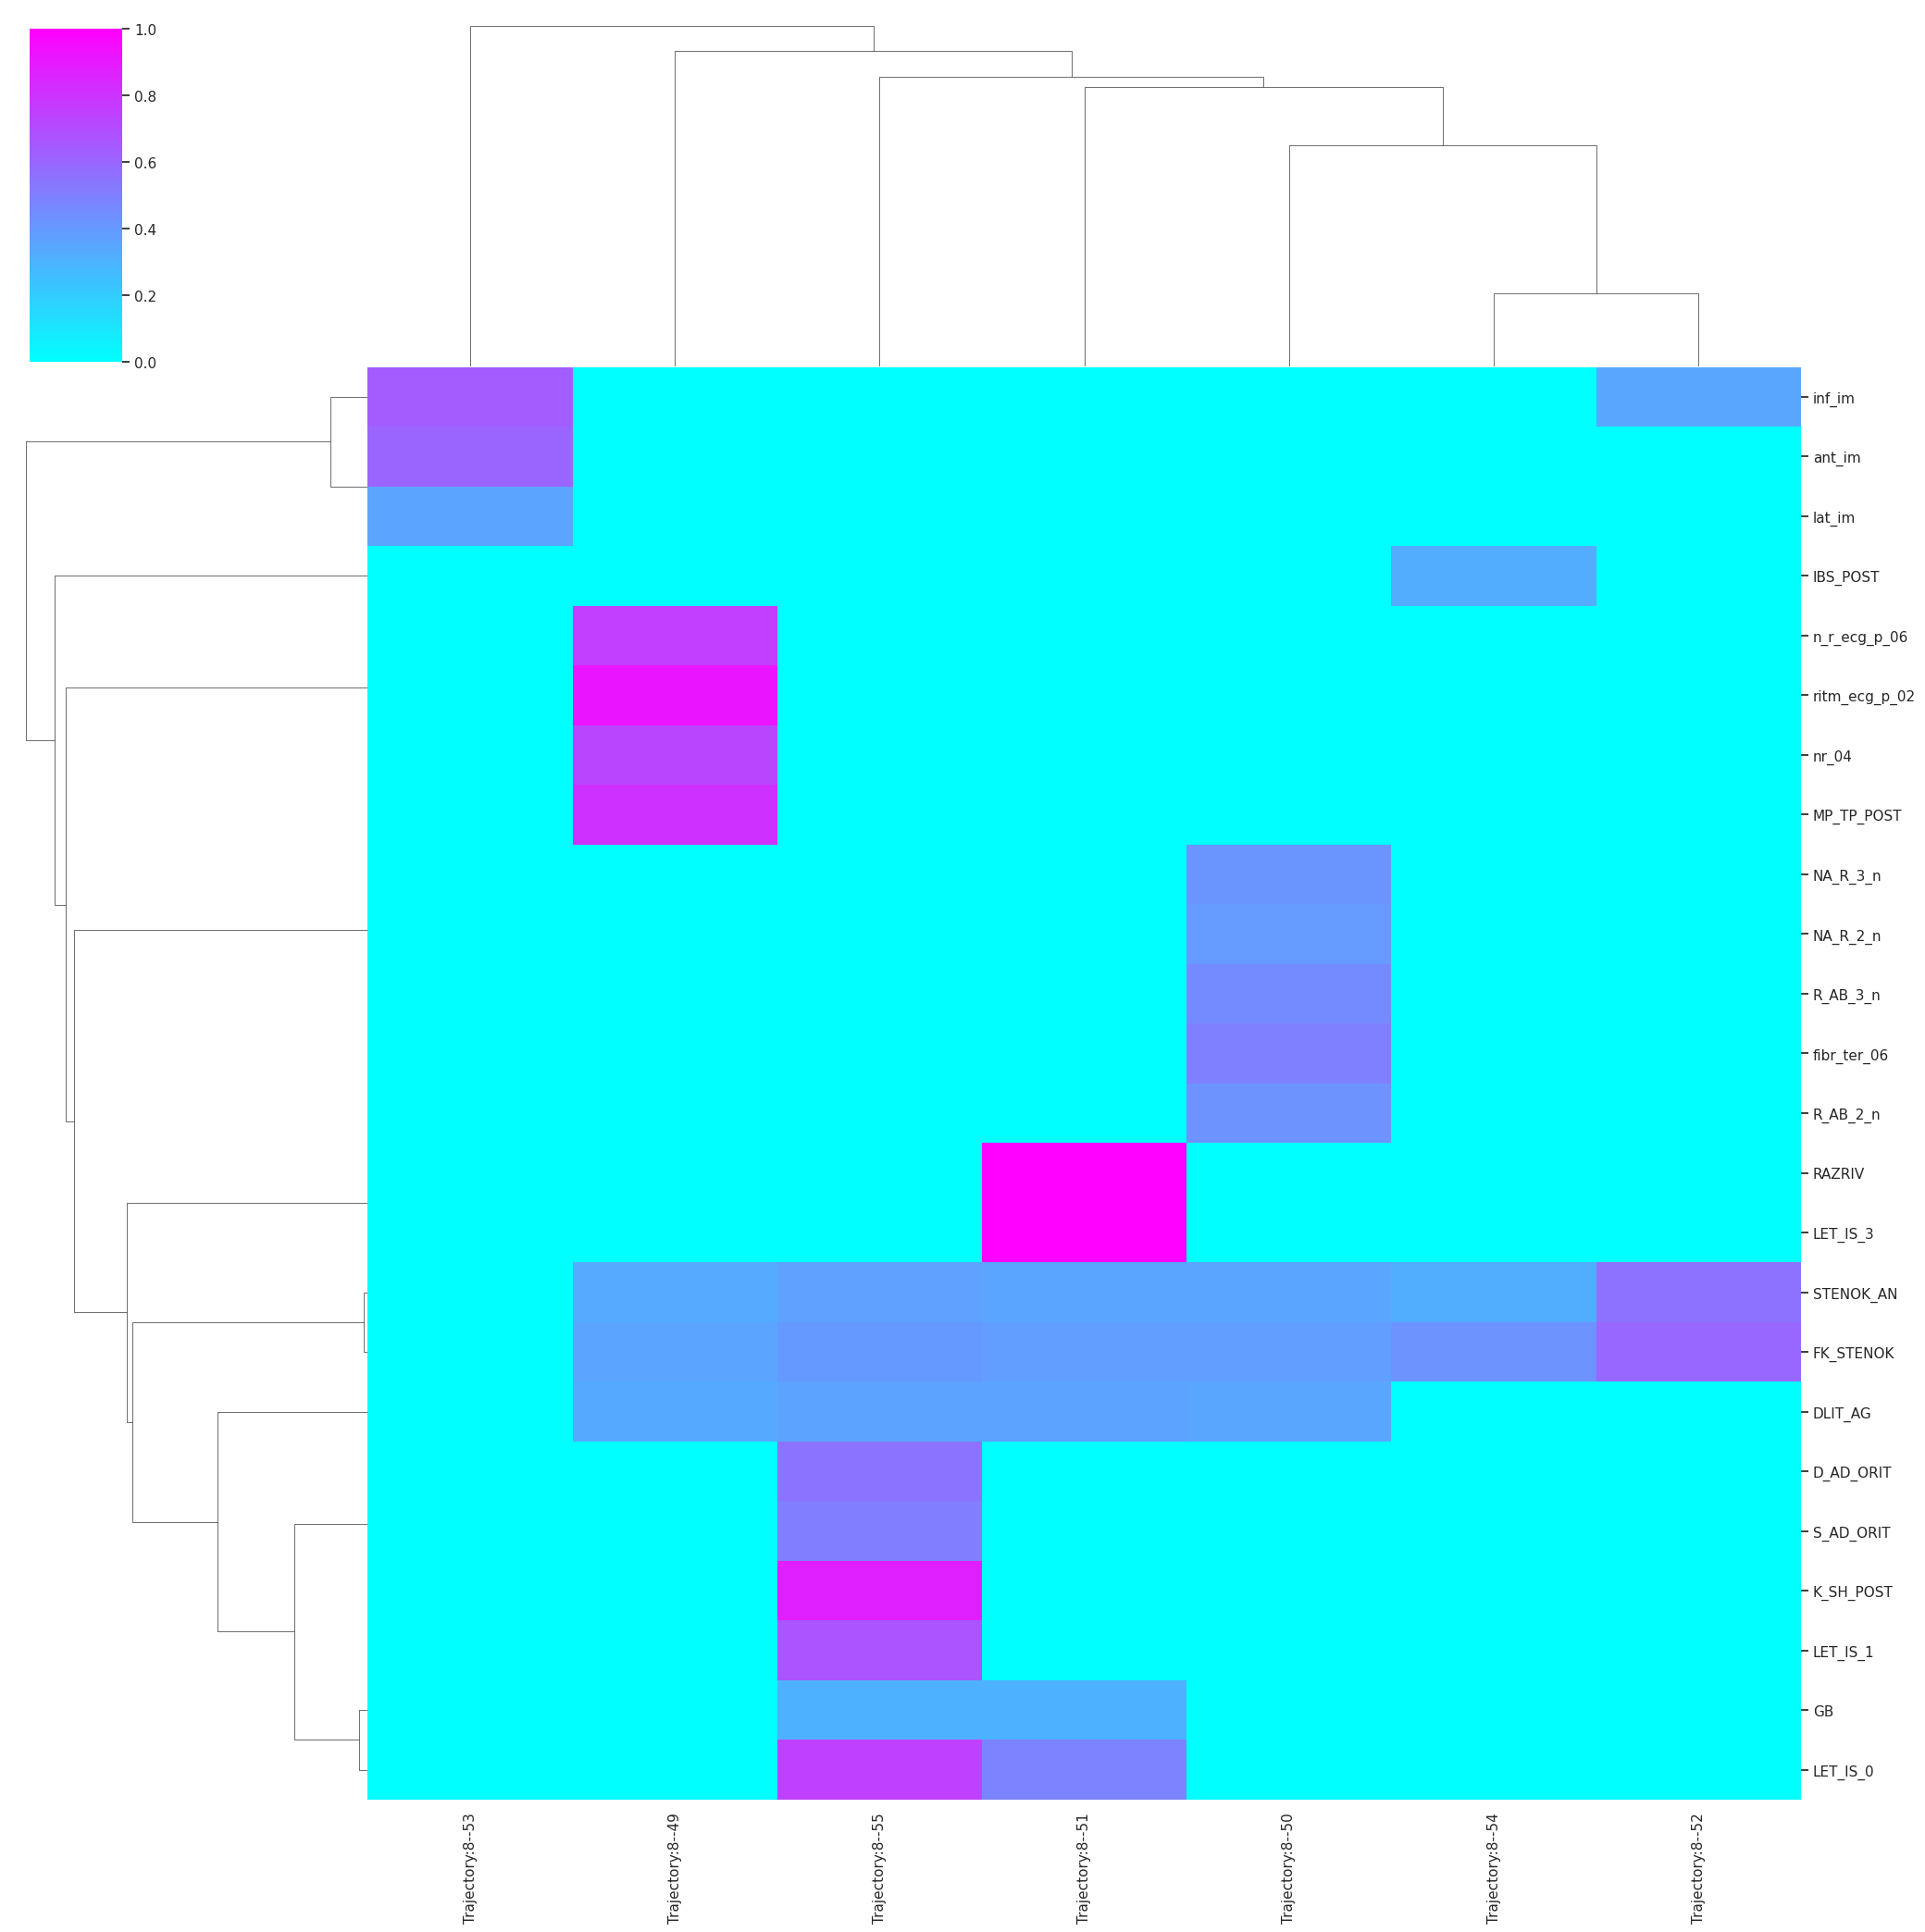

In [46]:
# Visualize associations between variables and trajectories

matrix_of_scores,keys,objects = get_matrix_of_association_scores(all_trajectory_variable_associations)

sns.set(color_codes=True)
#g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(7, 20))
g = sns.clustermap(matrix_of_scores,metric="correlation",figsize=(20, 20),cmap='cool')
objects_reordered = [objects[ind] for ind in g.dendrogram_col.reordered_ind]
keys_reordered = [keys[ind] for ind in g.dendrogram_row.reordered_ind]
g.ax_heatmap.set_xticklabels(objects_reordered)
g.ax_heatmap.set_yticklabels(keys_reordered)
print(keys_reordered)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig('associations_trajectories.png', format='png', dpi=300)
print()


/home/zinovyev/gits/ClinTrajan/code/clintraj_eltree.py:222: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x,y,c=color2,cmap=cmap,s=points_size, vmin=vmin, vmax=vmax,alpha=Transparency_Alpha_points)
/home/zinovyev/gits/ClinTrajan/code/clintraj_eltree.py:222: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x,y,c=color2,cmap=cmap,s=points_size, vmin=vmin, vmax=vmax,alpha=Transparency_Alpha_points)
/home/zinovyev/gits/ClinTrajan/code/clintraj_eltree.py:222: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x,y,c=color2,cmap=cmap,s=points_size, vmin=vmin, vmax=vmax,alpha=Transparency_Alpha_points)
/home/zinovyev/gits/ClinTrajan/code/clintraj_eltree.py:229: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[highlight_subset],y[highlight_subset],c=color_subset,cmap=cmap,s=B

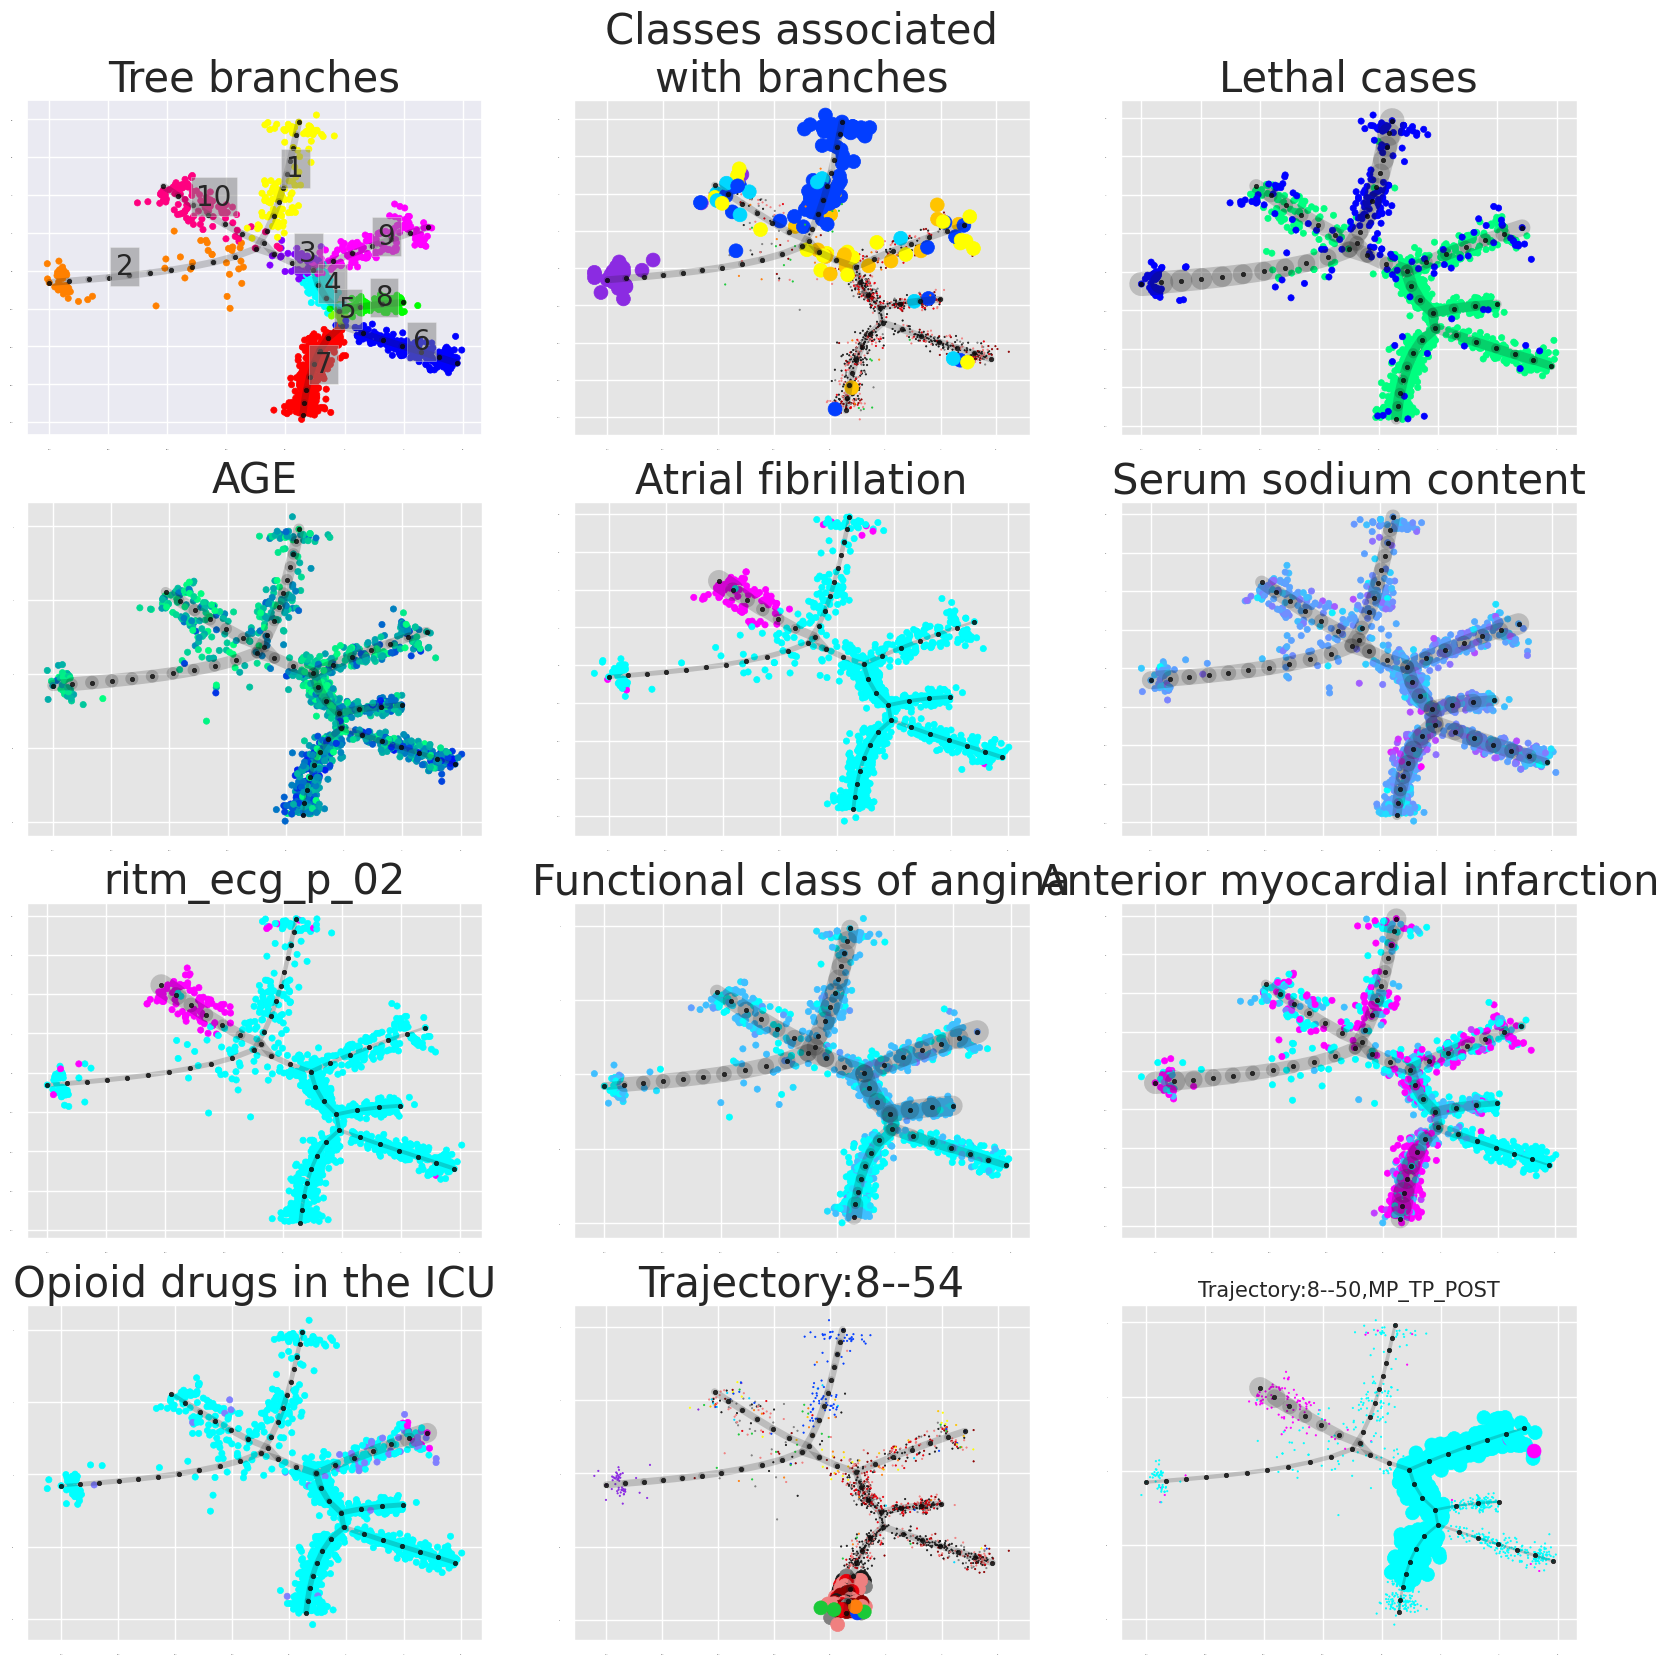

In [16]:
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

# visualizing some of the results on top of the tree

n_subplots_x, n_subplots_y = 4, 3
plt.style.use('ggplot')
fig = plt.figure(figsize=(20, 20))
title_font_size = 30

sns.set(font_scale=0,palette='bright')

# Visualize partionining of data by branches
i=1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          showBranchNumbers=True,Color_by_partitioning=True,visualize_partition=vec_labels_by_branches)
plt.title('Tree branches',fontsize=title_font_size)

# Show only points of classes strongly associated with branches
i=i+1
list_of_node_class_associations,p,stat = associate_with_categorical_var(vec_labels_by_branches,'CLASS',color,'CATEGORICAL',
                                                            score_threshold=0.7,
                                                            Negative_Enrichment=False,
                                                            Minimal_number_of_points=5,verbose=False)
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Classes associated\nwith branches',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Visualize_Branch_Class_Associations=list_of_node_class_associations)


# Visualize survival risk
i=i+1
feature='LET_IS_0'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Lethal cases',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Invert_Edge_Value=True,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature,cmap='winter')

# Visualize patient age
i=i+1
feature='AGE'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('AGE',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=1,Max_Edge_Width=10,Color_by_feature=feature, Feature_Edge_Width=feature,
                          vmin=30,vmax=80,cmap='winter')


# Visualize cases of cardiogenic shock
i=i+1
feature='ritm_ecg_p_02'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Atrial fibrillation',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize Serum sodium content NA_BLOOD
i=i+1
feature='NA_BLOOD'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Serum sodium content',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# ritm_ecg_p_02 - example of a strong association with binary variable
i=i+1
feature='ritm_ecg_p_02'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title(feature,fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize Functional class of angina FK_STENOK
i=i+1
feature='FK_STENOK'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Functional class of angina',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)


# Visualize anterior myocardial infarction ant_im
i=i+1
feature='ant_im'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Anterior myocardial infarction',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)

# Visualize use of Opioid drugs in the ICU NA_R_3_n
i=i+1
feature='NA_R_3_n'
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title('Opioid drugs in the ICU',fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)


# visualize a particular trajectory
pstt = PseudoTimeTraj[5]
points = list(pstt['Points'])
TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
i=i+1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.title(TrajName,fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          highlight_subset=points,Big_Point_Size = 100,Normal_Point_Size = 1)

# visualize a particular trajectory with an associated variable 
pstt = PseudoTimeTraj[1]
points = list(pstt['Points'])
TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
i=i+1
ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
feature = 'MP_TP_POST'
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          highlight_subset=points,Big_Point_Size = 100,Normal_Point_Size = 1,
                          Min_Edge_Width=1,Max_Edge_Width=20,Color_by_feature=feature, Feature_Edge_Width=feature)
plt.title(TrajName+','+feature,fontsize=15)

plt.savefig('principal_tree_visexamples.png', format='png', dpi=400)
plt.show()

min: 0.0
max: 1.0


array([[ 0.22815431,  0.12347477],
       [ 0.16976198, -1.75744626],
       [ 0.99673146,  0.63530491],
       ...,
       [ 0.19060349,  1.80597446],
       [-0.82609183,  1.10475615],
       [ 0.10351806,  2.13947872]])

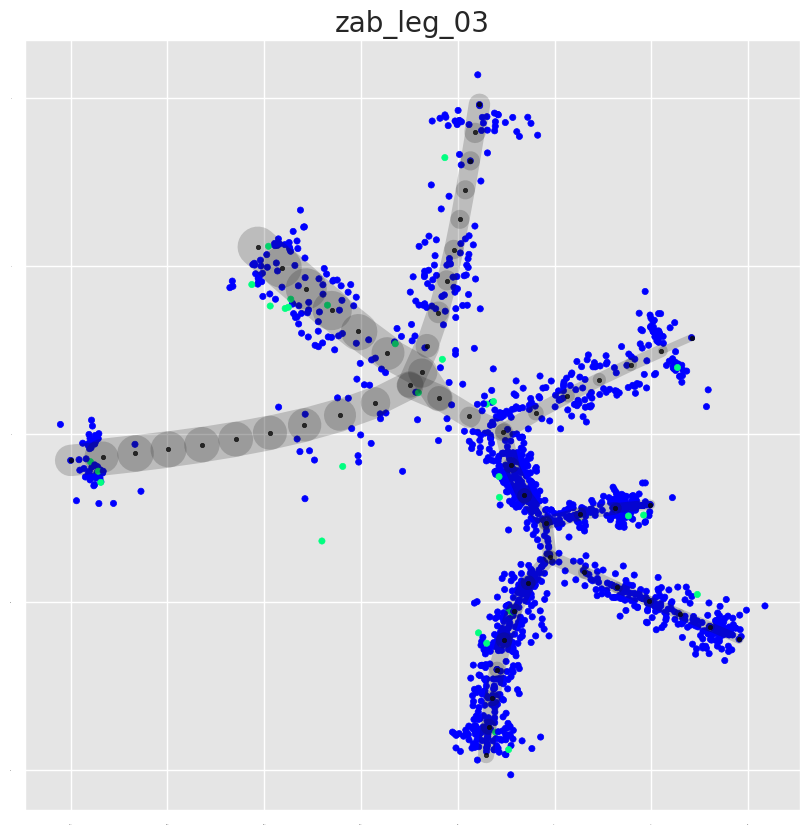

In [18]:
reload(clintraj_eltree)
from clintraj_eltree import visualize_eltree_with_data,pseudo_time_trajectory,extract_trajectories,quantify_pseudotime

title_font_size=20
#feature = 'MP_TP_POST'
#feature ='ritm_ecg_p_01'
#feature ='REC_IM'
feature ='zab_leg_03'

print('min:',min(X_original[:,variable_names.index(feature)]))
print('max:',max(X_original[:,variable_names.index(feature)]))

#ax = fig.add_subplot(n_subplots_x,n_subplots_y,i)
plt.figure(figsize=(10,10))
plt.title(feature,fontsize=title_font_size)
visualize_eltree_with_data(tree_extended,X,X_original,color,variable_names,
                           principal_component_vectors=v,mean_vector=mean_val,
                          Min_Edge_Width=1,Max_Edge_Width=30,showNodeNumbers=False,
                           Color_by_feature=feature, Feature_Edge_Width=feature,cmap='winter')

Start computations...
PCA: 0.0035 sec
Computing LLE...


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:129: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_PCA[:, 0], Y_PCA[:, 1], c=color1, cmap=cmap,s=points_size)


LLE: 0.37 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:151: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_LLE[:, 0], Y_LLE[:, 1], c=color1, cmap=cmap,s=points_size)


Modified LLE: 2.4 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:172: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_MLLE[:, 0], Y_MLLE[:, 1], c=color1, cmap=cmap,s=points_size)


Isomap: 1.2 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:191: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_ISOMAP[:, 0], Y_ISOMAP[:, 1], c=color1, cmap=cmap,s=points_size)


MDS: 4.9 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:211: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_MDS[:, 0], Y_MDS[:, 1], c=color1, cmap=cmap,s=points_size)


SpectralEmbedding: 0.31 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:231: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_se[:, 0], Y_se[:, 1], c=color1, cmap=cmap,s=points_size)


t-SNE: 6 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:252: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_TSNE[:, 0], Y_TSNE[:, 1], c=color1, cmap=cmap,s=points_size)
/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP: 8 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:274: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_UMAP[:, 0], Y_UMAP[:, 1], c=color1, cmap=cmap,s=points_size)


TRIMAP: 1.2 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:292: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_TRIMAP[:, 0], Y_TRIMAP[:, 1], c=color1, cmap=cmap,s=points_size)


ArpackError: ARPACK error -9: Starting vector is zero.

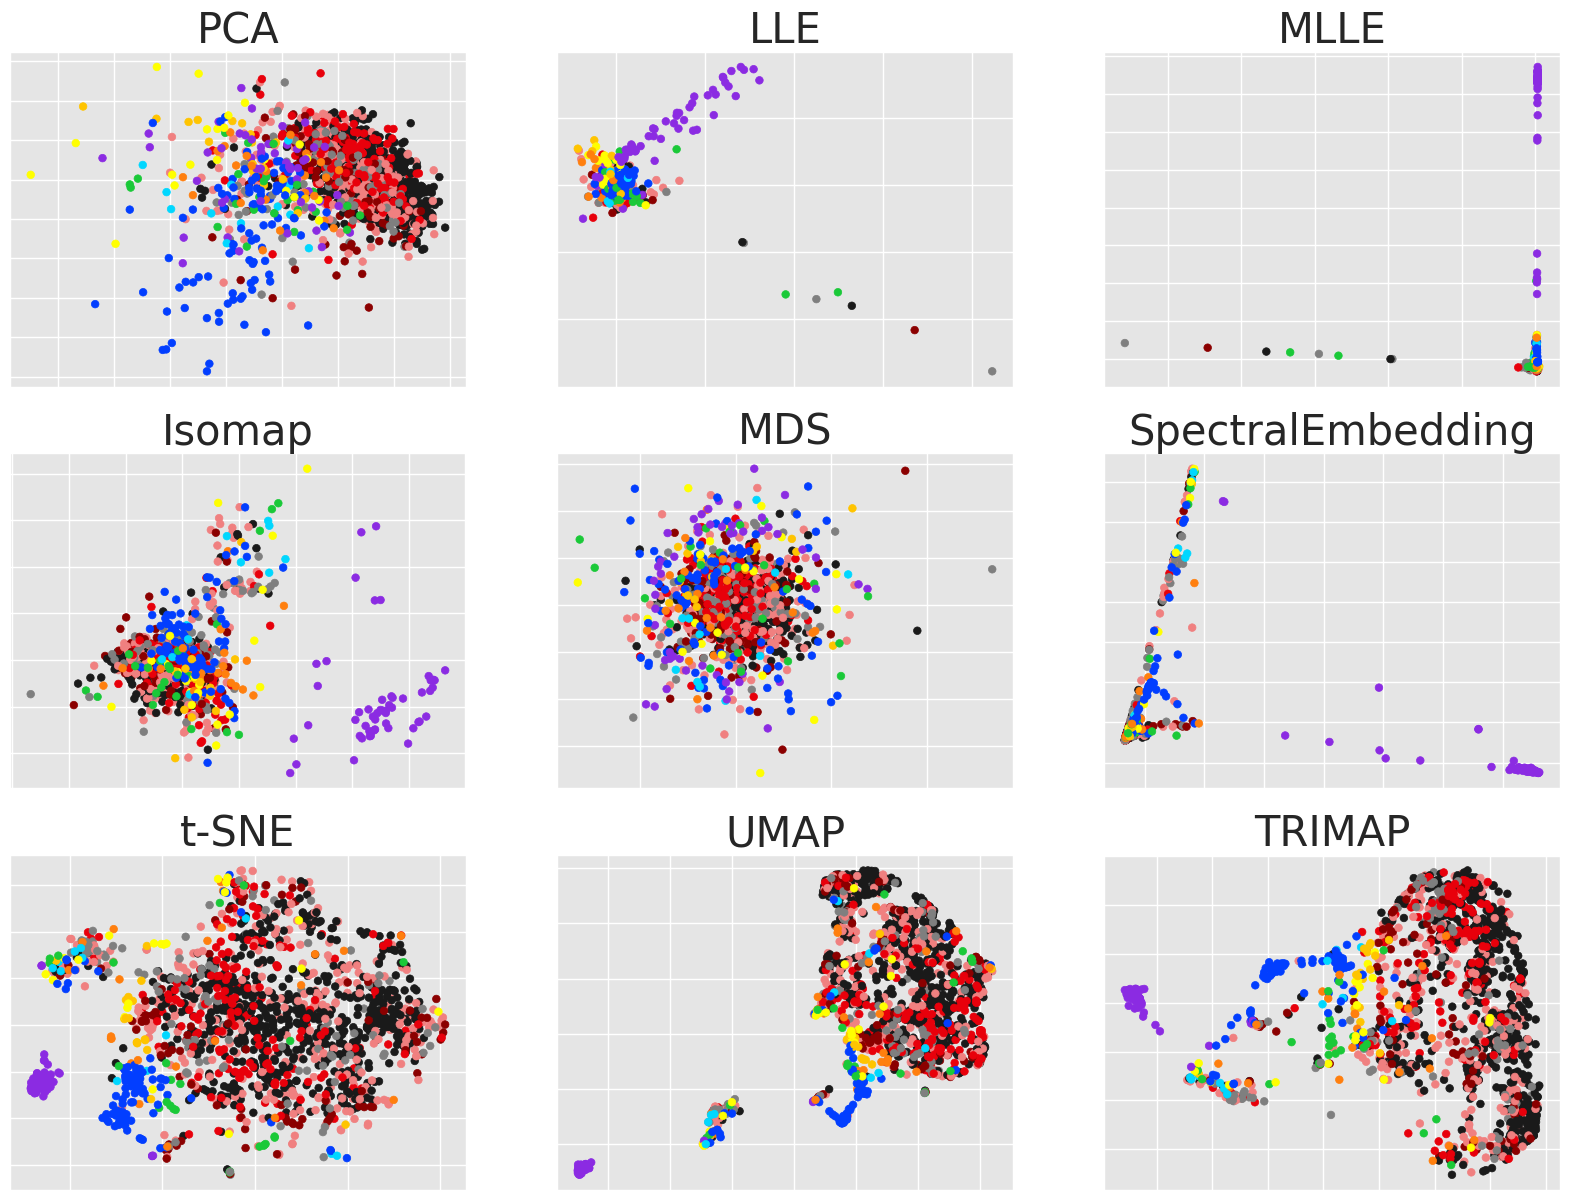

In [19]:
# Here the manifold learning is computed and saved in viz_results

sns.set(palette='bright')

viz_results = apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=[],precomputed_results=viz_results,color_map='cool',ColorByFeature='', variable_names=[],
    ElMapFolder=ElMapFolder)
plt.savefig('manifolds_color_by_class.png', format='png', dpi=300)
plt.show()

Start computations...
PCA: 2.9e-06 sec
LLE: 2.4e-06 sec
Modified LLE: 1.7e-06 sec
Isomap: 1.4e-06 sec
MDS: 1.4e-06 sec
SpectralEmbedding: 7.2e-07 sec
t-SNE: 4.8e-07 sec
UMAP: 1.4e-06 sec
TRIMAP: 4.8e-07 sec


/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:129: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_PCA[:, 0], Y_PCA[:, 1], c=color1, cmap=cmap,s=points_size)
/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:151: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_LLE[:, 0], Y_LLE[:, 1], c=color1, cmap=cmap,s=points_size)
/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:172: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_MLLE[:, 0], Y_MLLE[:, 1], c=color1, cmap=cmap,s=points_size)
/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:191: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(Y_ISOMAP[:, 0], Y_ISOMAP[:, 1], c=color1, cmap=cmap,s=points_size)
/home/zinovyev/gits/ClinTrajan/code/clintraj_ml.py:211: UserWarning: No data for colormapping provided via '

ArpackError: ARPACK error -9: Starting vector is zero.

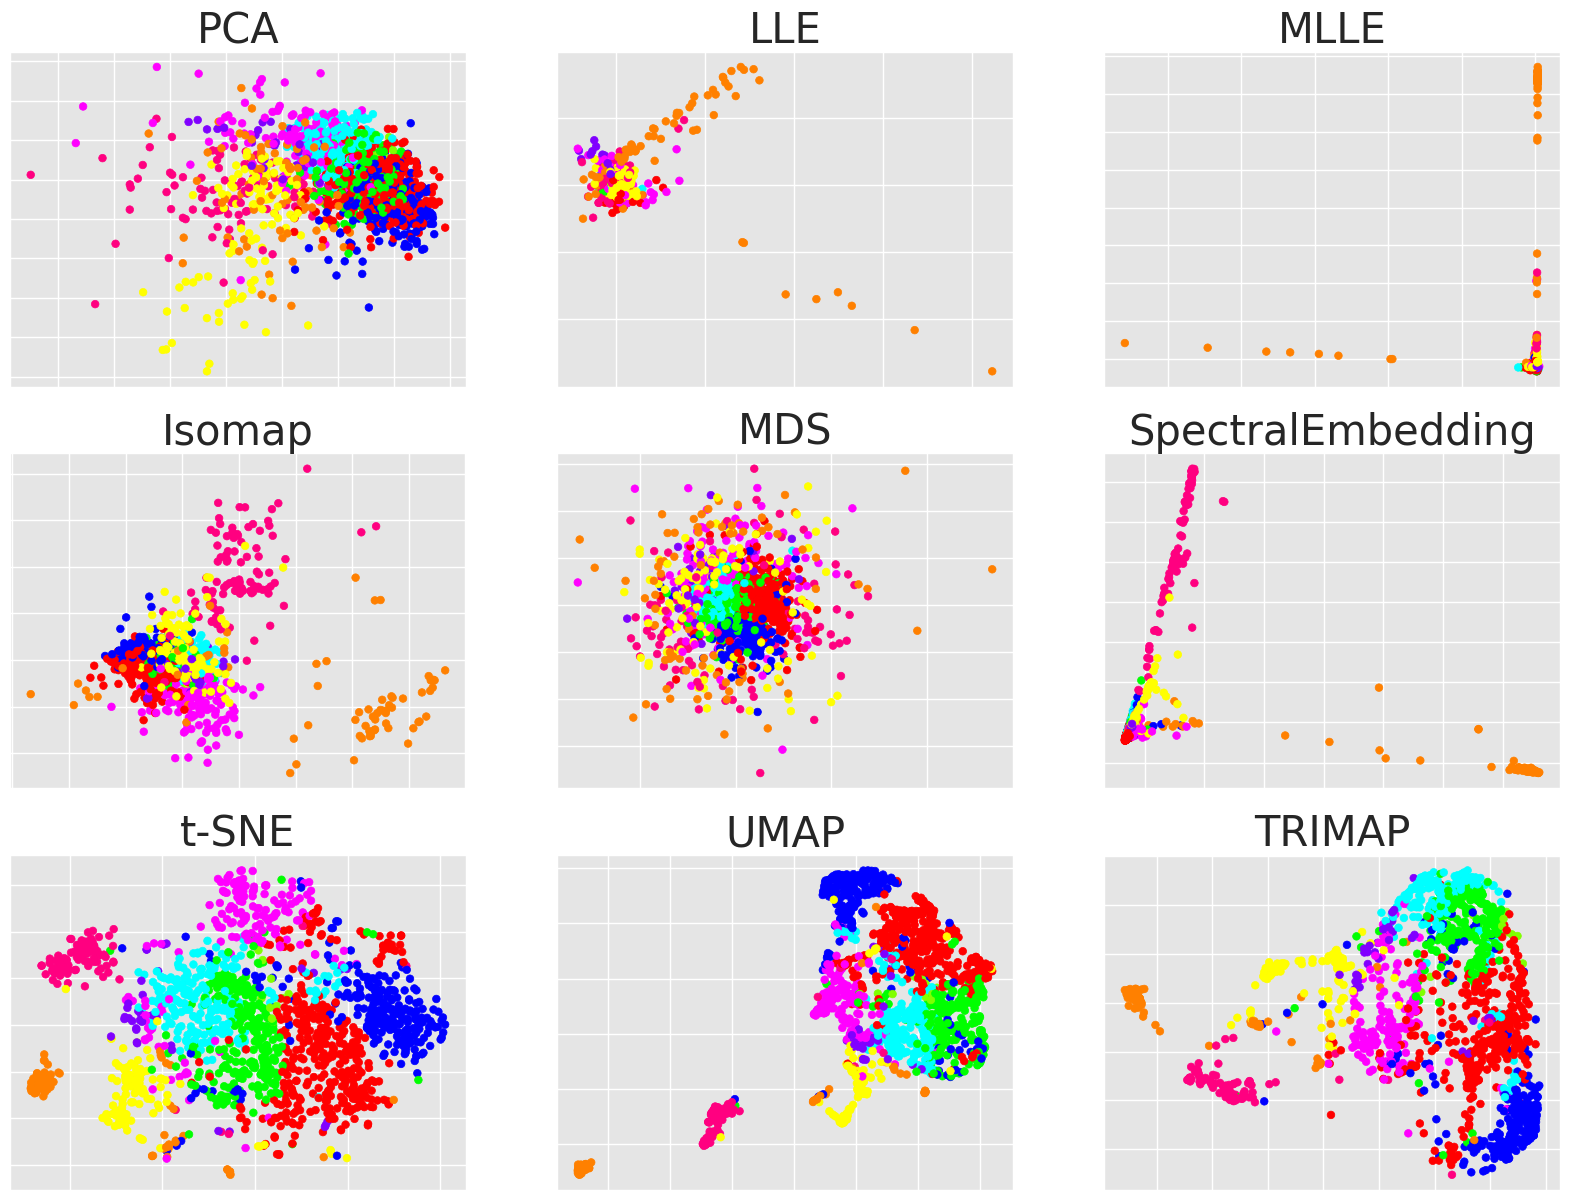

In [20]:
# Now we color by branches of the principal tree
# Here we use the results of the previous computations by specifying 'precomputed_results'

apply_panel_of_manifold_learning_methods(X,color,
    Color_by_branches=vec_labels_by_branches,precomputed_results=viz_results,color_map='cool',ColorByFeature='', variable_names=[],
    ElMapFolder=ElMapFolder)
plt.savefig('manifolds_color_by_tree_branch.png', format='png', dpi=300)
plt.show()

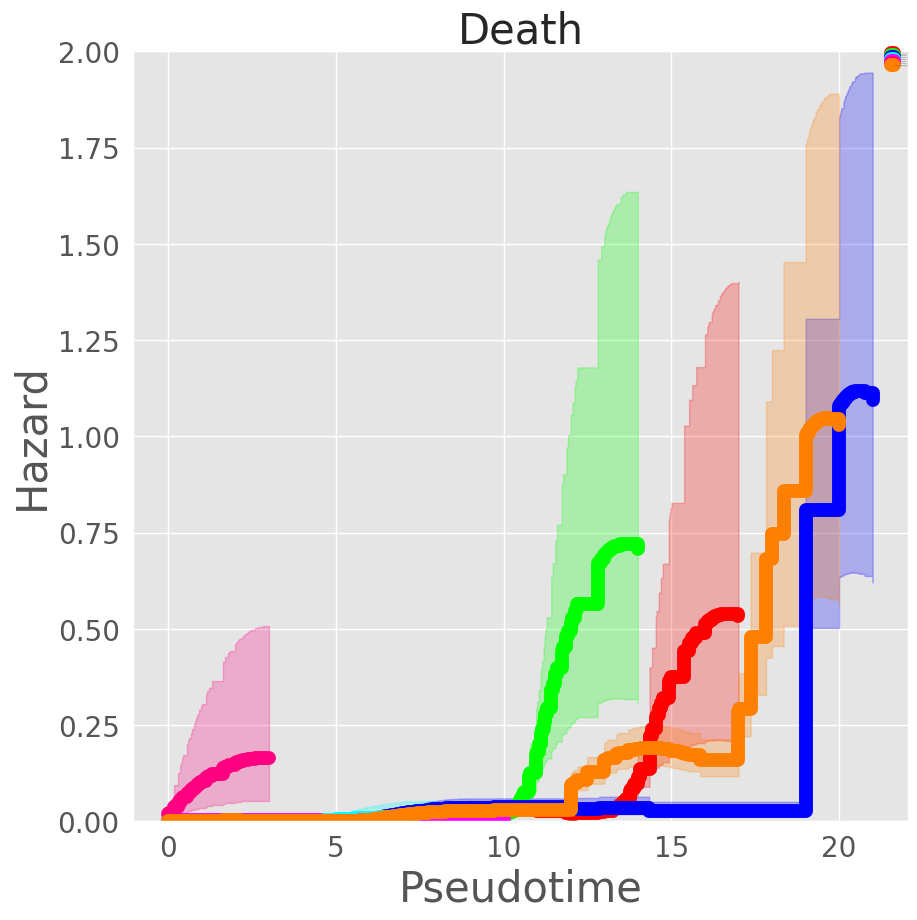

In [21]:
import lifelines
from lifelines import SplineFitter
from lifelines import NelsonAalenFitter
from lifelines import KaplanMeierFitter

color_seq = [[1,0,0],[0,1,0],[0,0,1],[0,1,1],[1,0,1],
             [1,0,0.5],[1,0.5,0],[0.5,0,1],
             [0.5,0.5,1],
             [0.2,0.2,0.2],[0,0.5,0.5],[0.5,0,0.5],
             [0.5,0.5,0],[0.5,0.5,0.5],[0,0,0.5],
             [0,0.5,0],[0.5,0,0],[0,0.25,0.5],
             [0,0.5,0.25],[0.25,0,0.5],[0.25,0.5,0],
             [0.5,0,0.25],[0.5,0.25,0],[0.25,0.25,0.5],
             [0.25,0.5,0.25],[0.5,0.25,0.25],[0.25,0.25,0.5],
             [0.25,0.5,0.25],[0.25,0.25,0.5],[0.25,0.5,0.25],
             [0.5,0,0.25],[0.5,0.25,0.25],
             [1,0,0.25],[1,0.25,0],[1,0.25,0.25],
             [0,1,0.25],[0.25,1,0],[0.25,1,0.25],
             [0,0.25,1],[0.25,0,1],[0.25,0.25,1],
             ]


event_data = np.zeros((len(df),2))
events = 1-np.array(df['LET_IS_0'])
label = 'Death'

#complications = ['FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD','A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN','REC_IM','P_IM_STEN']
#event_complication = np.array(df[complications].sum(axis=1))
#event_complication[event_complication>0]=1
#events = event_complication
#label = 'Complications'

#label = 'PREDS_TAH'
#events = np.array(df[label])




#events = np.array(df['LET_IS_1'])
#label = 'cardiogenic shock'

#events = np.array(df['LET_IS_2'])
#label = 'pulmonary edema'

#events = np.array(df['LET_IS_3'])
#label = 'myocardial rupture'

#events = np.array(df['LET_IS_4'])
#label = 'progress of congestive heart failure'

#events = np.array(df['LET_IS_5'])
#label = 'thromboembolism'

#events = np.array(df['LET_IS_6'])
#label = 'asystole'

#events = np.array(df['LET_IS_7'])
#label = 'ventricular fibrillation'




for i,pstt in enumerate(PseudoTimeTraj):
    points = pstt['Points']
    times = pstt['Pseudotime']
    for i,p in enumerate(points):
        event_data[p,0] = times[i]
        event_data[p,1] = events[p]

plt.figure(figsize=(10,10))

for i,pstt in enumerate(PseudoTimeTraj):
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    points = pstt['Points']
    #kmf = KaplanMeierFitter()
    kmf = NelsonAalenFitter()
    T = event_data[points,0]
    E = event_data[points,1]
    #kmf = SplineFitter(knot_locations=[0,50,100])
    kmf.fit(event_data[points,0], event_observed=event_data[points,1],label=TrajName)  
    pstt['KMF'] = kmf
    kmf.plot_hazard(bandwidth=3.0,fontsize=20,linewidth=10,color=tuple(color_seq[i]))
    #kmf.plot_survival_function()
plt.xlabel('Pseudotime',fontsize=30)
plt.ylim(0,2)
plt.ylabel('Hazard',fontsize=30)
plt.title(label,fontsize=30)
plt.legend(fontsize=0)
plt.show()

In [22]:
df1 = df[df.columns[1:116]]
df1['PSEUDOTIME'] = event_data[:,0]
df1['DEATH_EVENT'] = event_data[:,1]
df1 = df1.drop(['FK_STENOK','S_AD_ORIT','ritm_ecg_p_02'],axis=1)
display(df1)

/tmp/ipykernel_73801/2139654114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['PSEUDOTIME'] = event_data[:,0]
/tmp/ipykernel_73801/2139654114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['DEATH_EVENT'] = event_data[:,1]


AGE  SEX  INF_ANAM  STENOK_AN  IBS_POST  GB  SIM_GIPERT  DLIT_AG  \
0     77.0    1         2          1         2   3           0        7   
1     55.0    1         1          0         0   0           0        0   
2     52.0    1         0          0         2   2           0        2   
3     68.0    0         0          0         2   2           0        3   
4     60.0    1         0          0         2   3           0        7   
...    ...  ...       ...        ...       ...  ..         ...      ...   
1569  77.0    0         0          0         0   2           0        7   
1570  77.0    0         0          4         1   2           0        7   
1571  70.0    0         0          6         1   2           0        7   
1572  79.0    0         2          2         1   2           0        7   
1573  63.0    1         2          1         1   2           0        4   

      ZSN_A  nr_11  ...  FIBR_JELUD  A_V_BLOK  OTEK_LANC  RAZRIV  DRESSLER  \
0         0      0  ...           0         0          0       0         0   
1         0      0  ...           0         0          0       0         0   
2         0      0  ...           0         0          0       0         0   
3         1      0  ...           0         0          0       0         0   
4         0      0  ...           0         0          0       0         0   
...     ...    ...  ...         ...       ...        ...     ...       ...   
1569      0      0  ...           0         0          0       1         0   
1570      0      0  ...           0         1          0       1         0   
1571      0      0  ...           0         0          0       0         0   
1572      0      0  ...           0         0          1       0         0   
1573      4      0  ...           0         0          0       0         0   

      ZSN  REC_IM  P_IM_STEN  PSEUDOTIME  DEATH_EVENT  
0       0       0          0    8.290125          0.0  
1       0       0          0    2.076713          0.0  
2       0       0          0   13.000000          0.0  
3       1       0          0    4.955127          0.0  
4       0       0          0    6.900364          0.0  
...   ...     ...        ...         ...          ...  
1569    0       0          0   20.372183          1.0  
1570    0       0          0   20.048124          1.0  
1571    0       0          0   19.135428          1.0  
1572    0       0          0   16.119091          1.0  
1573    0       0          0   20.000000          1.0  

[1574 rows x 114 columns]

Trajectory: Trajectory:8--52
Number of points= 472
Number of lethal cases= 7
Removing  20 columns
Num of variables 43


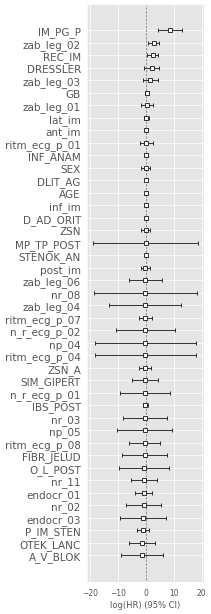

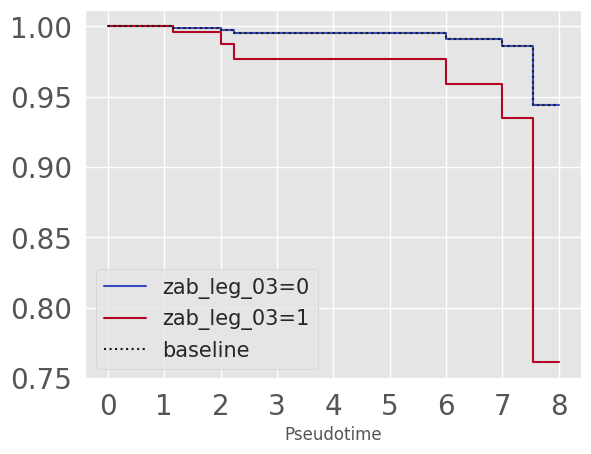

In [23]:
from lifelines import CoxPHFitter

# If we want to do global regression (which is dangerous because pseudo-times are not comparable)
df2 = df1

# Here we want to focus on a particular trajectory
traj_num = 3
if traj_num>=0:
    pstt = PseudoTimeTraj[traj_num]
    TrajName = 'Trajectory:'+str(pstt['Trajectory'][0])+'--'+str(pstt['Trajectory'][-1])
    print('Trajectory: '+TrajName)
    points = pstt['Points']
    print('Number of points=',len(points))
    print('Number of lethal cases=',np.sum(event_data[points,1]==1))
    df2 = df1.iloc[points]

nonredundant_cols = ['AGE','SEX','INF_ANAM','STENOK_AN','IBS_POST','GB','SIM_GIPERT','DLIT_AG','ZSN_A','nr_11','FIBR_JELUD','A_V_BLOK','OTEK_LANC','DRESSLER','ZSN','REC_IM','P_IM_STEN','nr_01','nr_02','nr_03','nr_04','nr_08','np_01','np_04','np_05','np_08','np_10','endocr_01','endocr_02','endocr_03','zab_leg_01','zab_leg_02','zab_leg_03','zab_leg_04','zab_leg_06','D_AD_ORIT','O_L_POST','K_SH_POST','MP_TP_POST','SVT_POST','FIB_G_POST','ant_im','lat_im','inf_im','post_im','IM_PG_P','ritm_ecg_p_01','ritm_ecg_p_04','ritm_ecg_p_07','ritm_ecg_p_08','n_r_ecg_p_01','n_r_ecg_p_02']
    
df2 = remove_constant_columns_from_dataframe(df2)
colnames = df2.columns.to_list()
#colnames.remove('DEATH_EVENT')
#colnames.remove('PSEUDOTIME')
colnames = list(set(colnames)&set(nonredundant_cols))
print('Num of variables',len(colnames))
formula = '+'.join(colnames)

cph = CoxPHFitter(penalizer=0.01)
cph.fit(df2, duration_col='PSEUDOTIME', event_col='DEATH_EVENT',formula=formula)


#cph.print_summary()
plt.figure(figsize=(3,15),dpi=50)
cph.plot()
plt.yticks(fontsize=15)
plt.show()

var = 'zab_leg_03'

#cph.plot_partial_effects_on_outcome(covariates='n_r_ecg_p_02', values=[0, 1], cmap='coolwarm')
#cph.plot_partial_effects_on_outcome(covariates='nr_08', values=[0, 1], cmap='coolwarm')
#cph.plot_partial_effects_on_outcome(covariates='REC_IM', values=[0, 1], cmap='coolwarm')
#cph.plot_partial_effects_on_outcome(covariates='O_L_POST', values=[0, 1], cmap='coolwarm')
#cph.plot_partial_effects_on_outcome(covariates='zab_leg_03', values=[0, 1], cmap='coolwarm')
#cph.plot_partial_effects_on_outcome(covariates='SIM_GIPERT', values=[0, 1], cmap='coolwarm')
cph.plot_partial_effects_on_outcome(covariates=var, values=[0, 1], cmap='coolwarm')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Pseudotime')
plt.legend(fontsize=15)
plt.savefig('cov_effect.png', dpi = 600)
plt.show()

In [24]:
cl = df1.columns[30:50]
print('+'.join(cl))

zab_leg_06+D_AD_ORIT+O_L_POST+K_SH_POST+MP_TP_POST+SVT_POST+GT_POST+FIB_G_POST+ant_im+lat_im+inf_im+post_im+IM_PG_P+ritm_ecg_p_01+ritm_ecg_p_04+ritm_ecg_p_06+ritm_ecg_p_07+ritm_ecg_p_08+n_r_ecg_p_01+n_r_ecg_p_02


(0.0, 1.0)

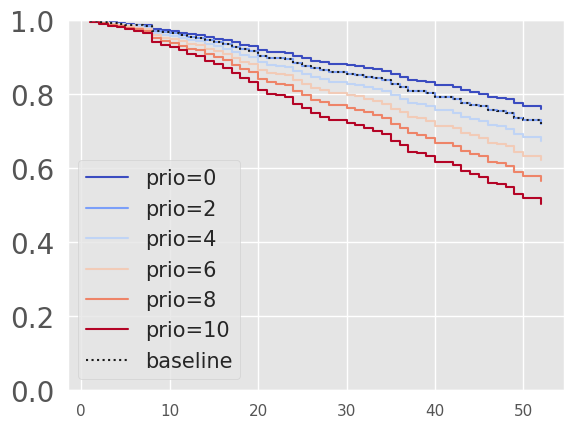

In [25]:
from lifelines.datasets import load_rossi
from lifelines import CoxPHFitter

rossi = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest')

cph.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.ylim(0,1)

/home/zinovyev/miniforge3/envs/clintrajan/lib/python3.10/site-packages/lifelines/fitters/__init__.py:1011: ApproximationWarning: 
The Hessian for PiecewiseExponentialFitter's fit was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

  warnings.warn(warning_text, exceptions.ApproximationWarning)


(array([0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 [Text(0, 0.8, '0.80'),
  Text(0, 0.8500000000000001, '0.85'),
  Text(0, 0.9, '0.90'),
  Text(0, 0.9500000000000001, '0.95'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.05, '1.05')])

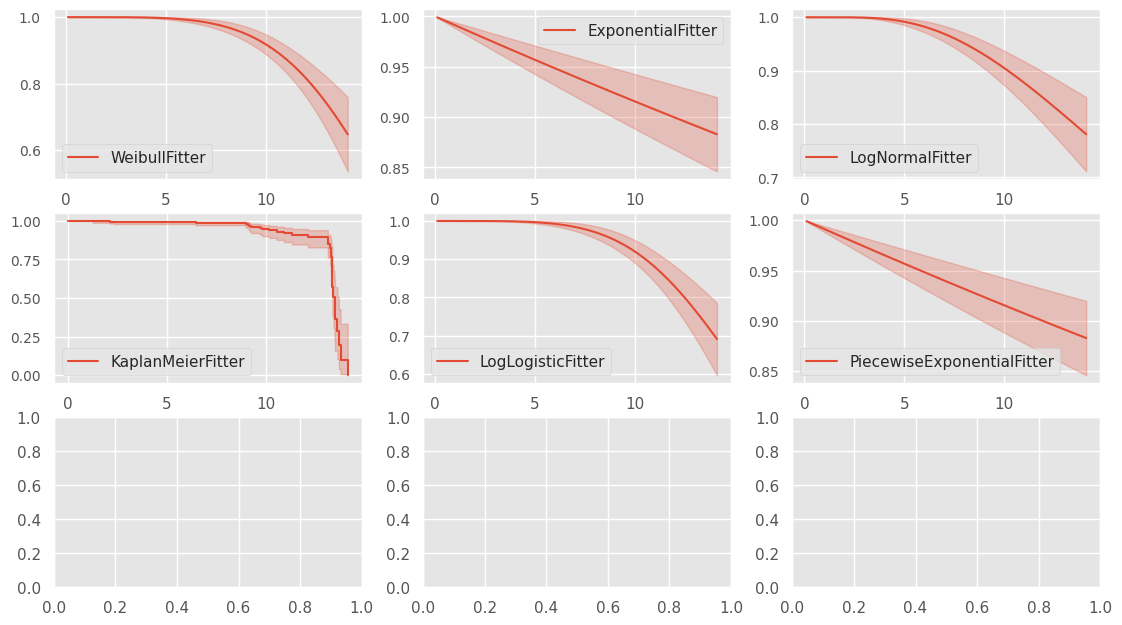

In [26]:
from lifelines import *

pt = PseudoTimeTraj[1]

#plt.plot(pt['Pseudotime'],events[pt['Points']],'ko')
#plt.yticks(fontsize=20)
#plt.show()

#kmf.fit(pt['Pseudotime'],events[pt['Points']])  
#kmf.plot()
#plt.yticks(fontsize=10)
#plt.ylim(0,1)

T = pt['Pseudotime']+0.1
E = events[pt['Points']]

#exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
#exf.plot_survival_function()
#plt.yticks(fontsize=10)
#plt.ylim(0,1)

fig, axes = plt.subplots(3, 3, figsize=(13.5, 7.5))

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
#ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
#sf = SplineFitter(np.percentile(T.loc[E.astype(bool)], [0, 50, 100])).fit(T, E, label='SplineFitter')

plt.subplot(331)
wbf.plot_survival_function()
plt.yticks(fontsize=10)
plt.subplot(332)
exf.plot_survival_function()
plt.yticks(fontsize=10)
plt.subplot(333)
lnf.plot_survival_function()
plt.yticks(fontsize=10)
plt.subplot(334)
kmf.plot_survival_function()
plt.yticks(fontsize=10)
plt.subplot(335)
llf.plot_survival_function()
plt.yticks(fontsize=10)
plt.subplot(336)
pwf.plot_survival_function()
plt.yticks(fontsize=10)
#ggf.plot_survival_function(ax=axes[2][0])
#sf.plot_survival_function(ax=axes[2][1])
